In [1]:
import os
import numpy as np
import glob
import json
import h5py
import csv
from igibson.utils.vi_log_util import VIDataLib
from itertools import product
import matplotlib.pyplot as plt 


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



In [3]:
data_path = "../../../data/vi_data"
vis = [f"{i}_{j}" for i in ["cataract", "amd", "glaucoma", "presbyopia", "myopia"] for j in [1, 2, 3]] + ["normal_1"]
tasks = ["catch", "navigate", "place", "slice", "throw", "wipe"]
ids =  [5]
save_json = False

logfiles = {}
for task in tasks:
    for vi in vis:
        logfiles[f"{task}_{vi}"] = {}
        for id in ids:
            logfiles[f"{task}_{vi}"][id] = {}
            for i, path in enumerate(glob.glob(rf"{data_path}/demo/{id}/{task}/{vi}/*/*.hdf5")):
                logfiles[f"{task}_{vi}"][id][i] = path

In [3]:
vi_data = VIDataLib(logfiles)

total_experiment_time = 0
for hf1 in vi_data.hfs.values():
    for hf2 in hf1.values():
        for hf3 in hf2.values():
            total_experiment_time += hf3.attrs["/metadata/task_completion_time"]
print(total_experiment_time / 60)

80.2034681558609


## Eye tracking data

### Total gaze movement

In [4]:
eye_data = vi_data.get_gaze_movement()

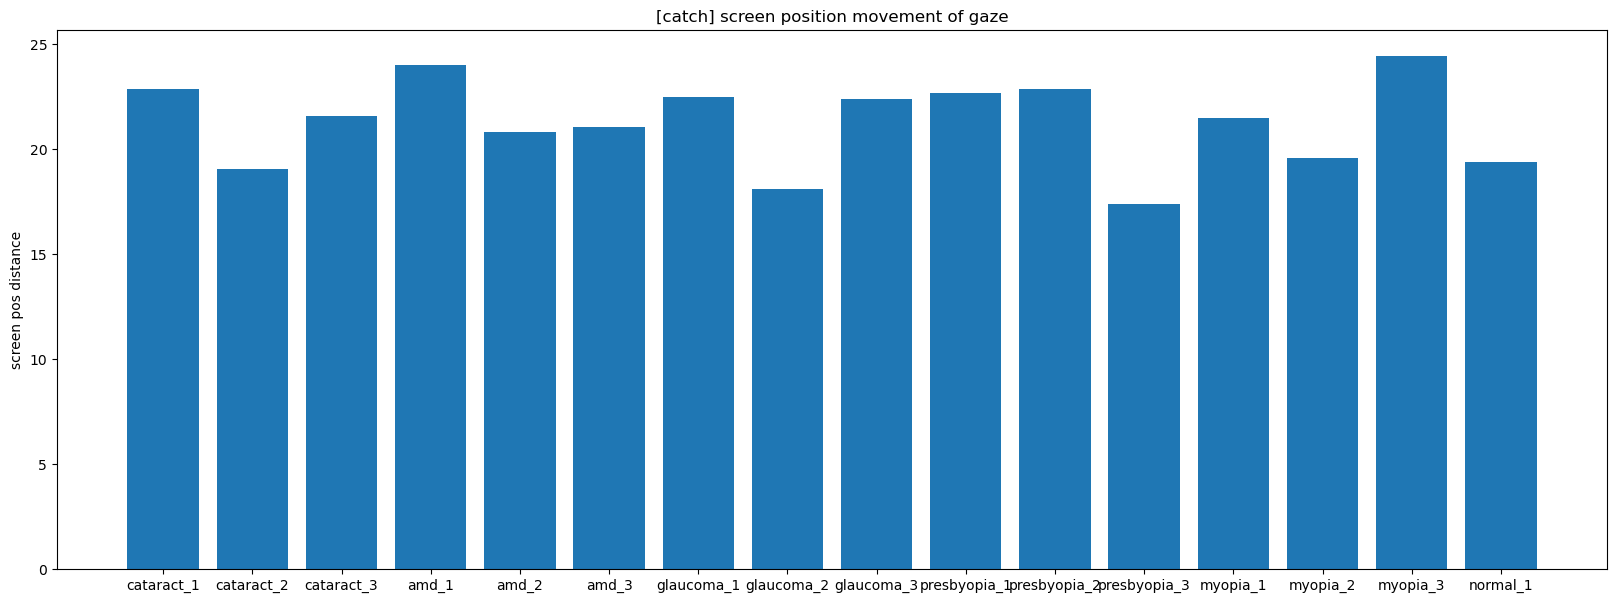

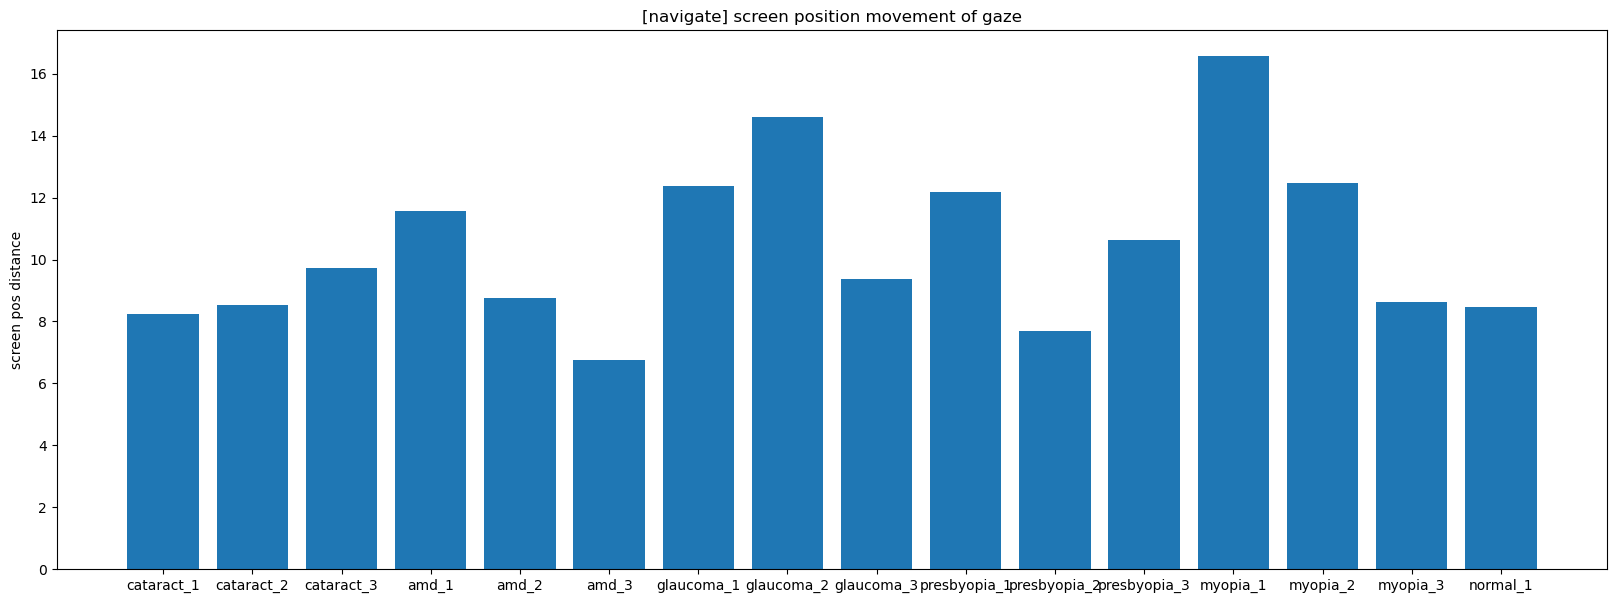

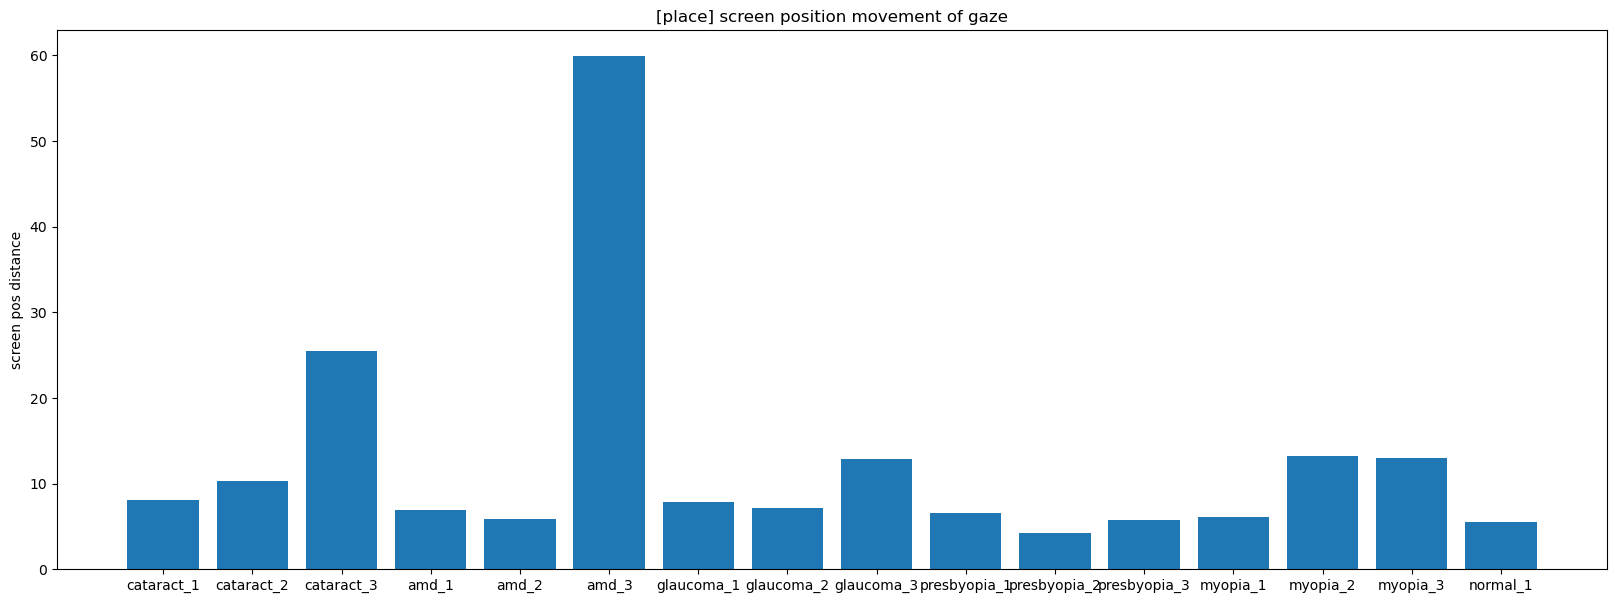

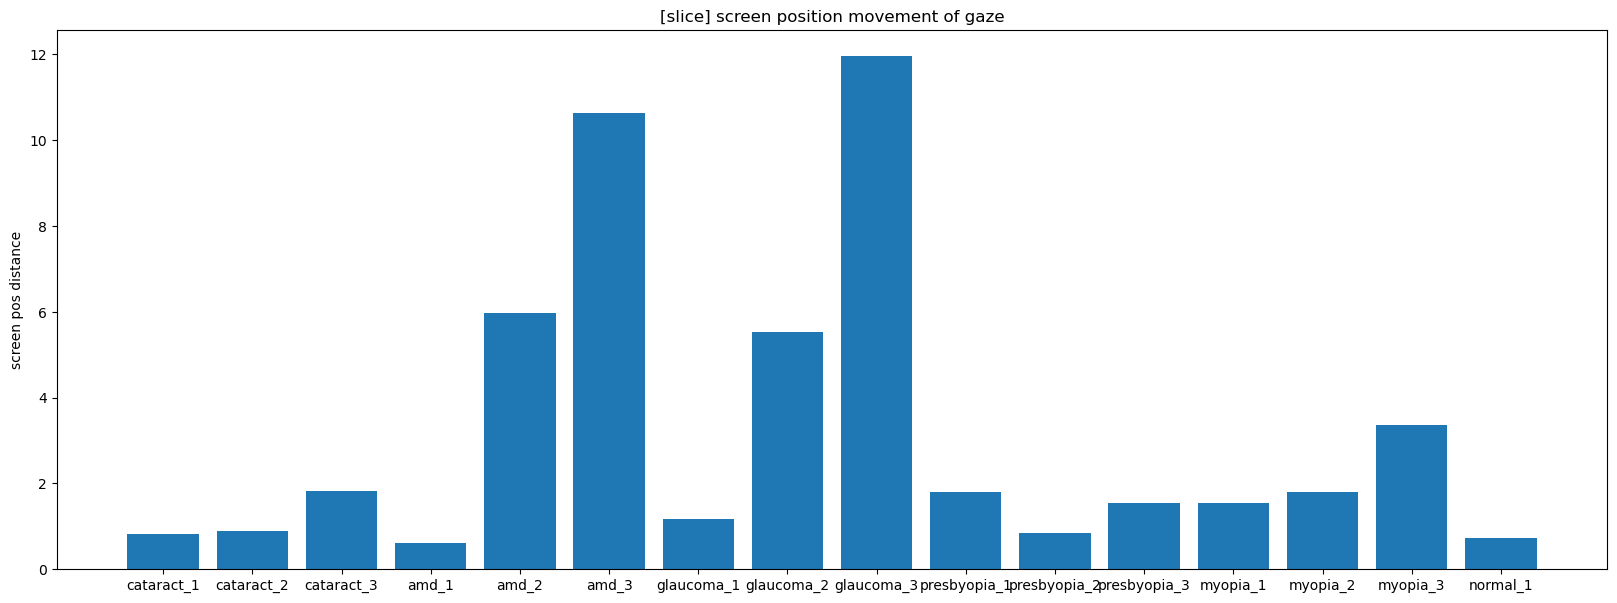

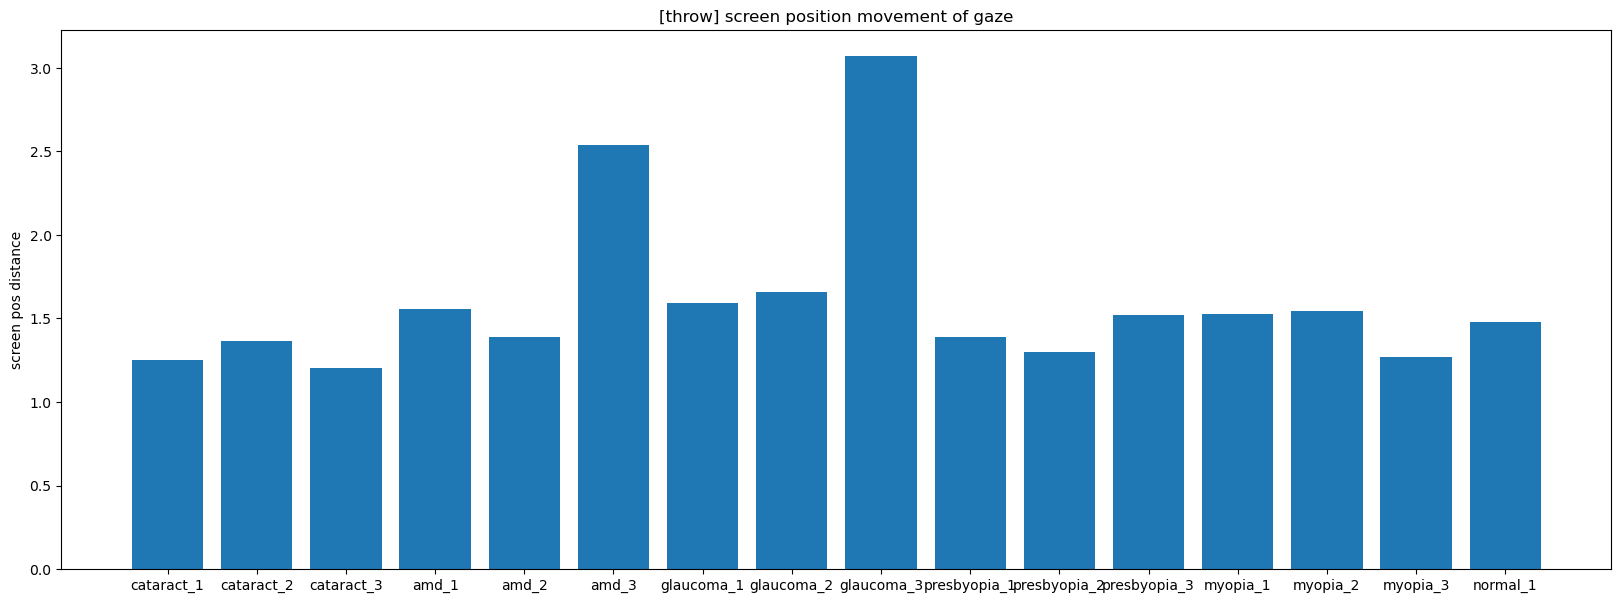

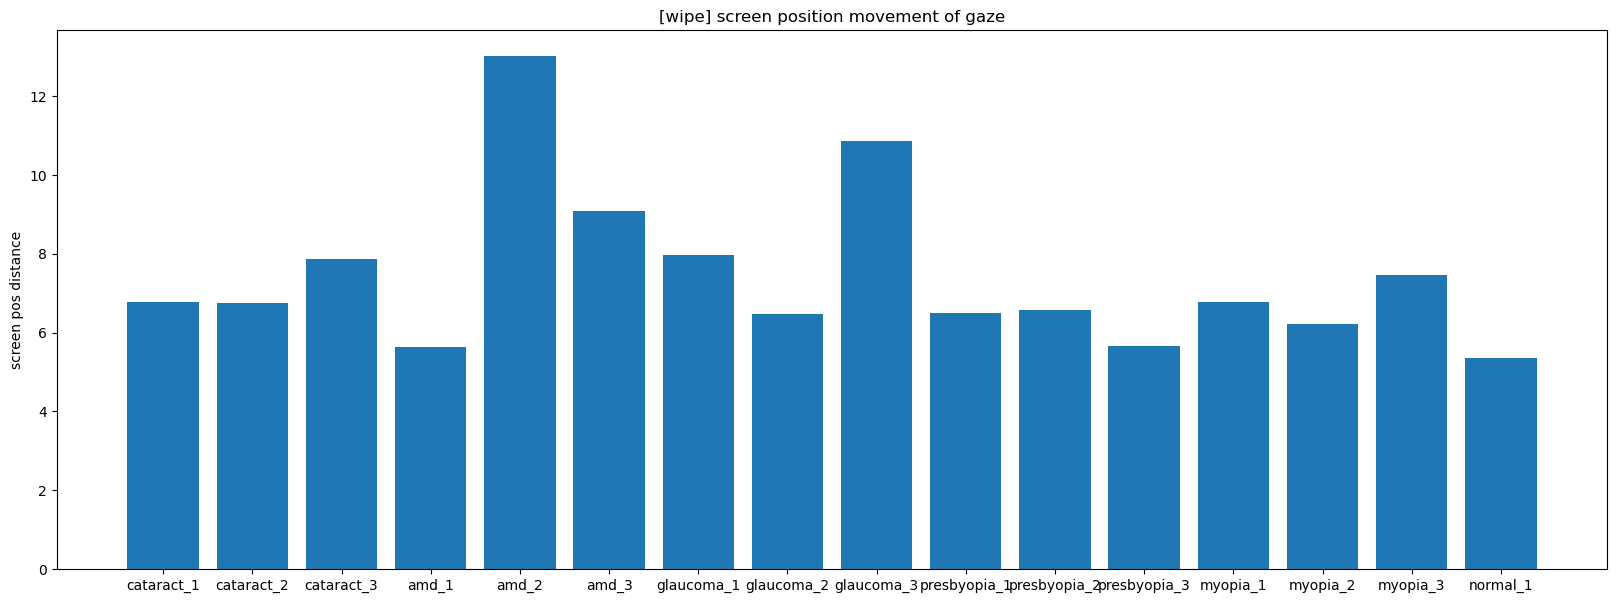

In [5]:
if save_json:
    with open(rf"{data_path}/json/dv2/total_gaze_movement.json", "w") as f:
        json.dump(eye_data, f)
avg_eye_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_eye_data[task][vi] = []
        for id in ids:
            avg_eye_data[task][vi].append(np.mean(list(eye_data[f"{task}_{vi}"][id].values())))
        avg_eye_data[task][vi] = np.mean(avg_eye_data[task][vi])
    vi_data.bar_plot(data=list(avg_eye_data[task].values()), tick_label=vis, title=f"[{task}] screen position movement of gaze", ylabel="screen pos distance")

### Pupil dilation

In [6]:
pupil_diameter = vi_data.get_pupil_dilation()

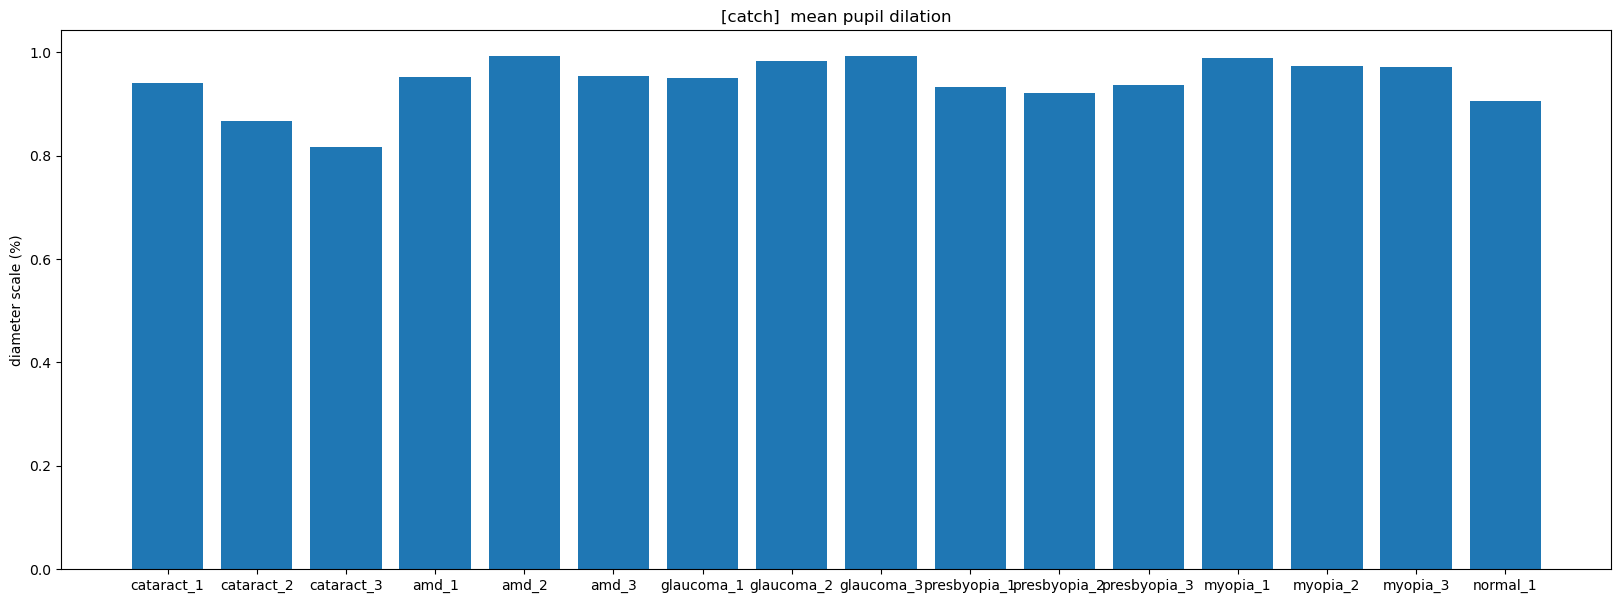

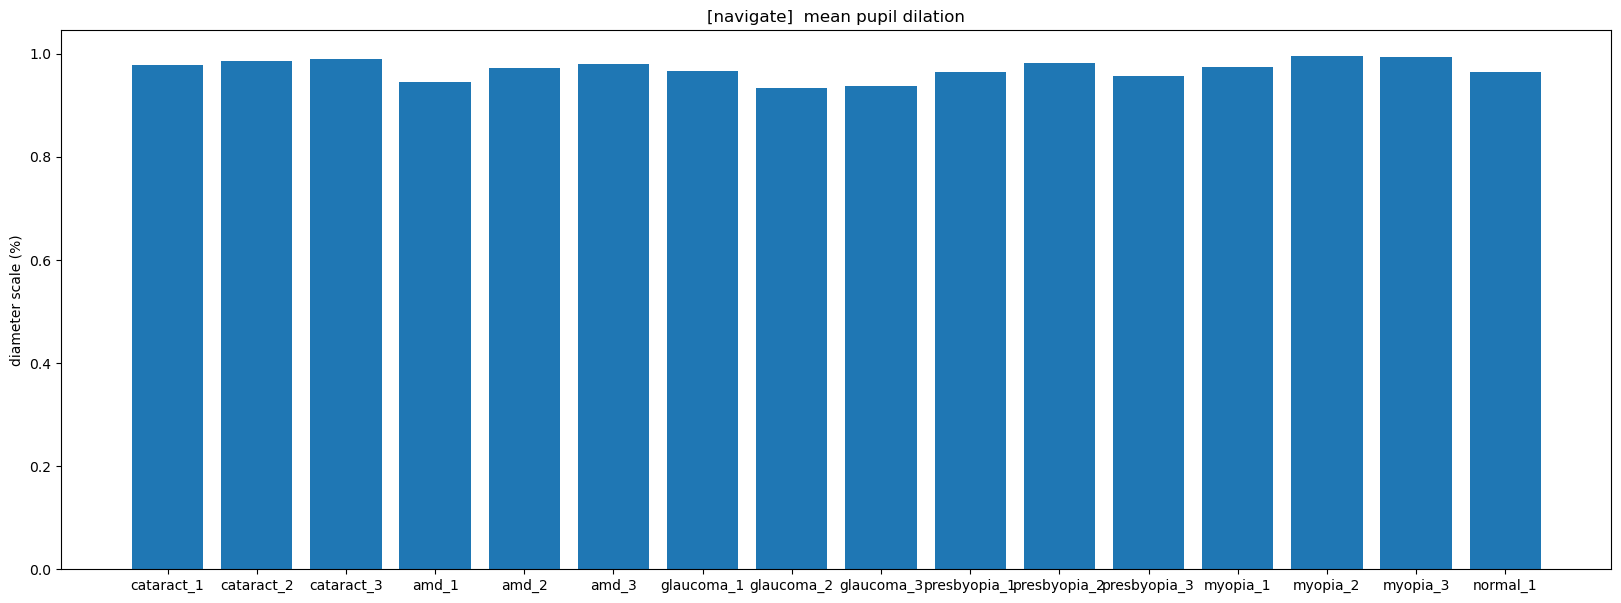

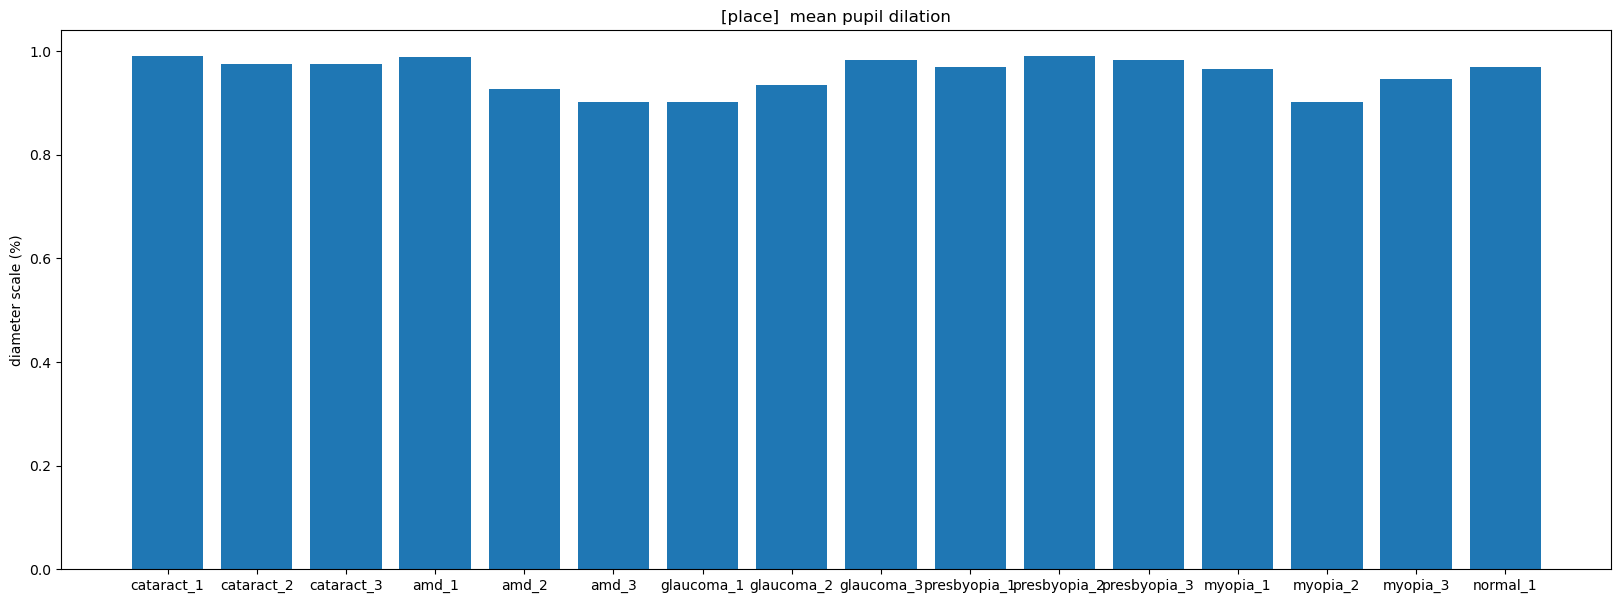

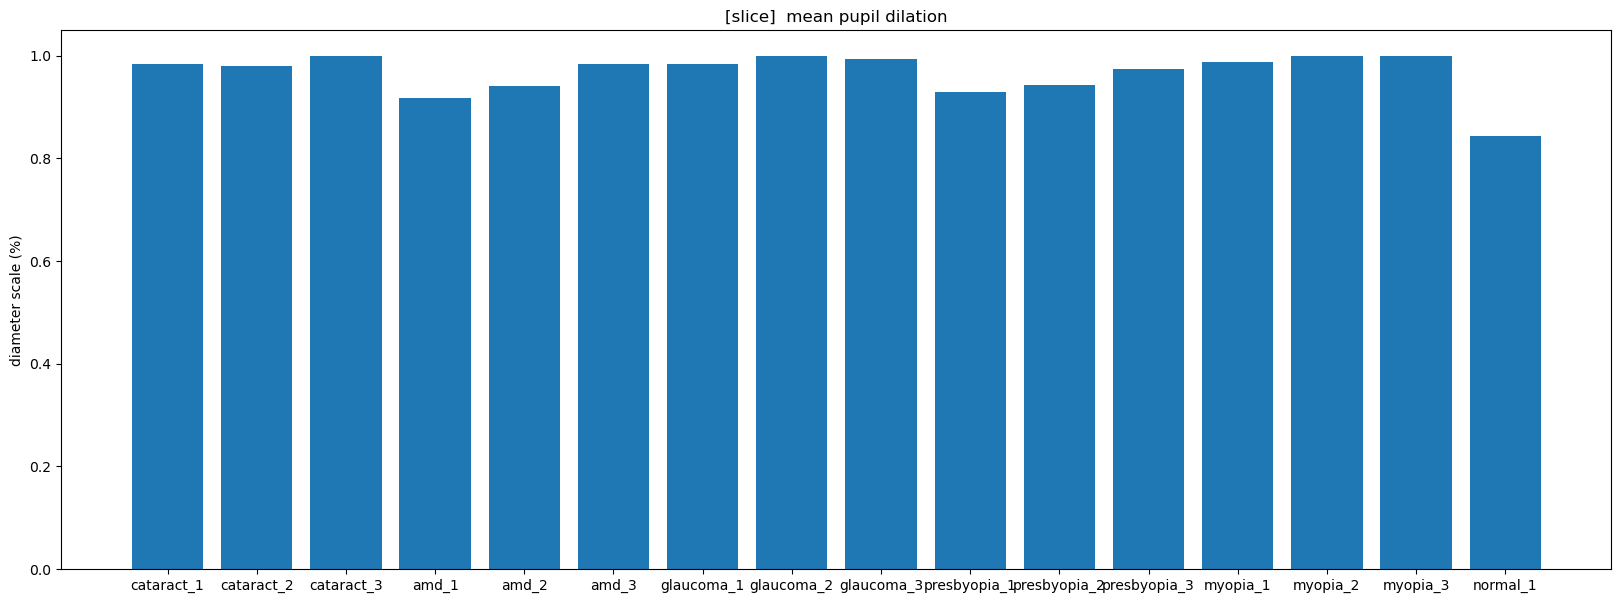

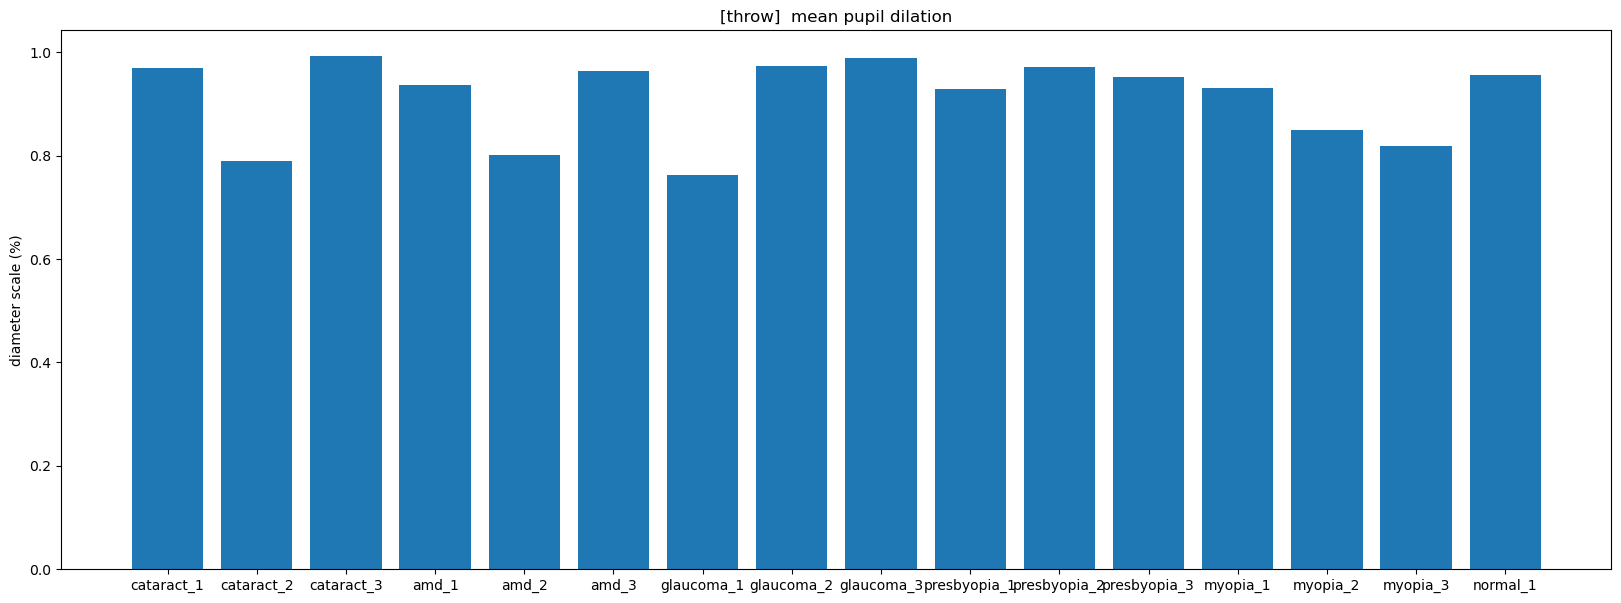

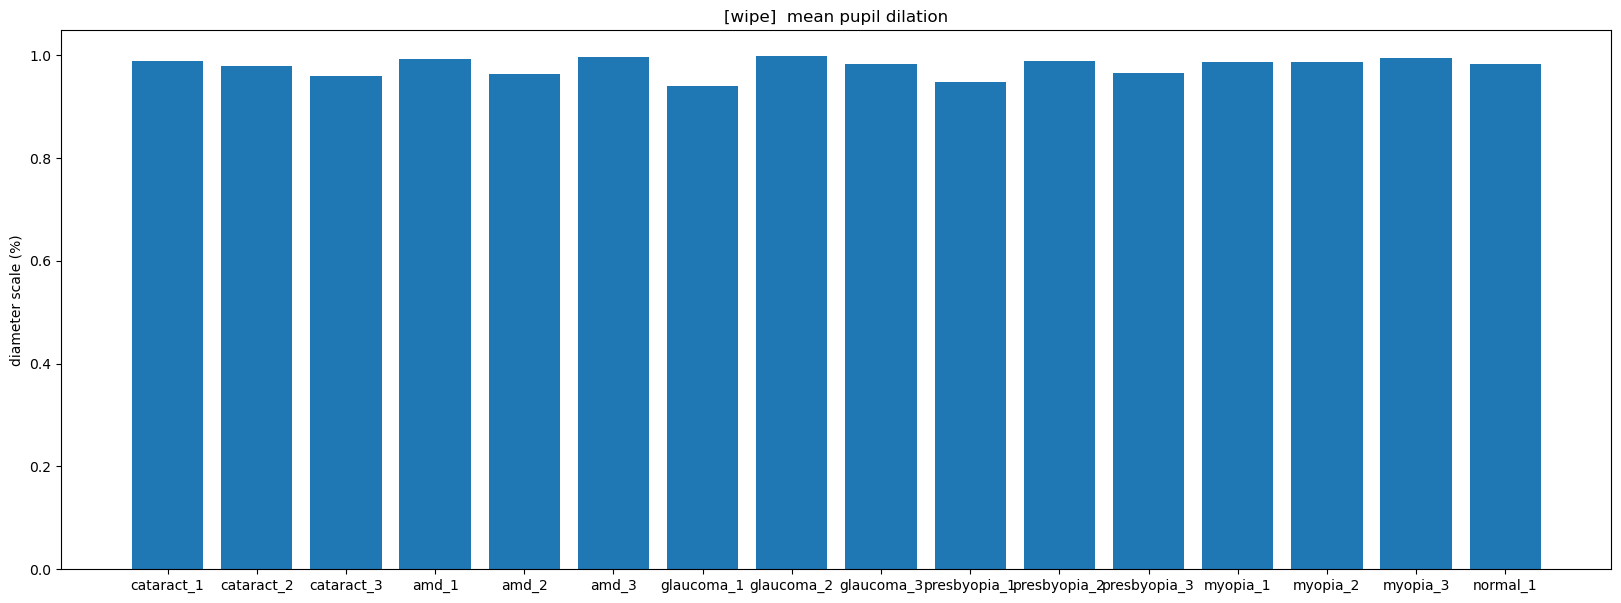

In [7]:
if save_json:
    with open(rf"{data_path}/json/dv2/mean_pupil_dilation.json", "w") as f:
        json.dump(pupil_diameter, f)
avg_pupil_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_pupil_data[task][vi] = []
        for id in ids:
            avg_pupil_data[task][vi].append(np.mean(list(pupil_diameter[f"{task}_{vi}"][id].values())))
        avg_pupil_data[task][vi] = np.mean(avg_pupil_data[task][vi])
    vi_data.bar_plot(data=list(avg_pupil_data[task].values()), tick_label=vis, title=f"[{task}]  mean pupil dilation", ylabel="diameter scale (%)")

### Fixation extraction

In [8]:
fixation_data = vi_data.get_fixation(threshold=6, smooth_coordinates=True, smooth_saccades=True)

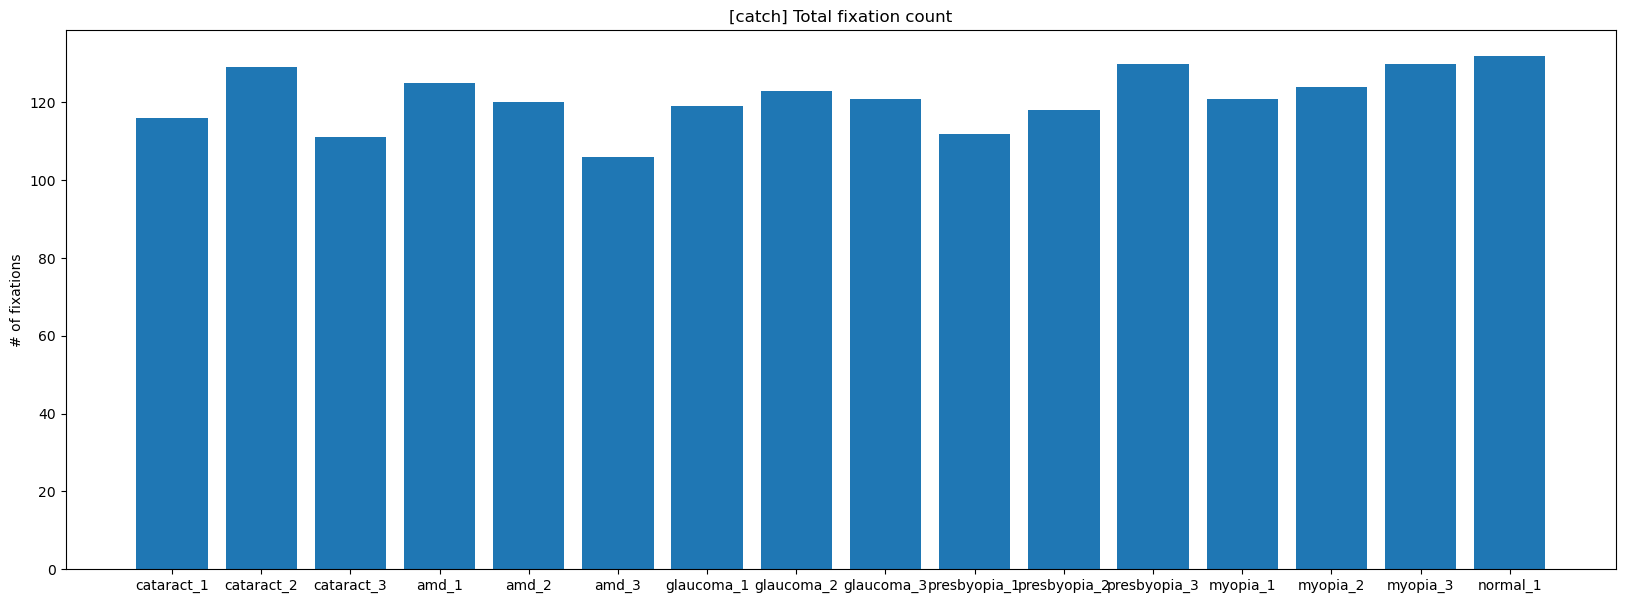

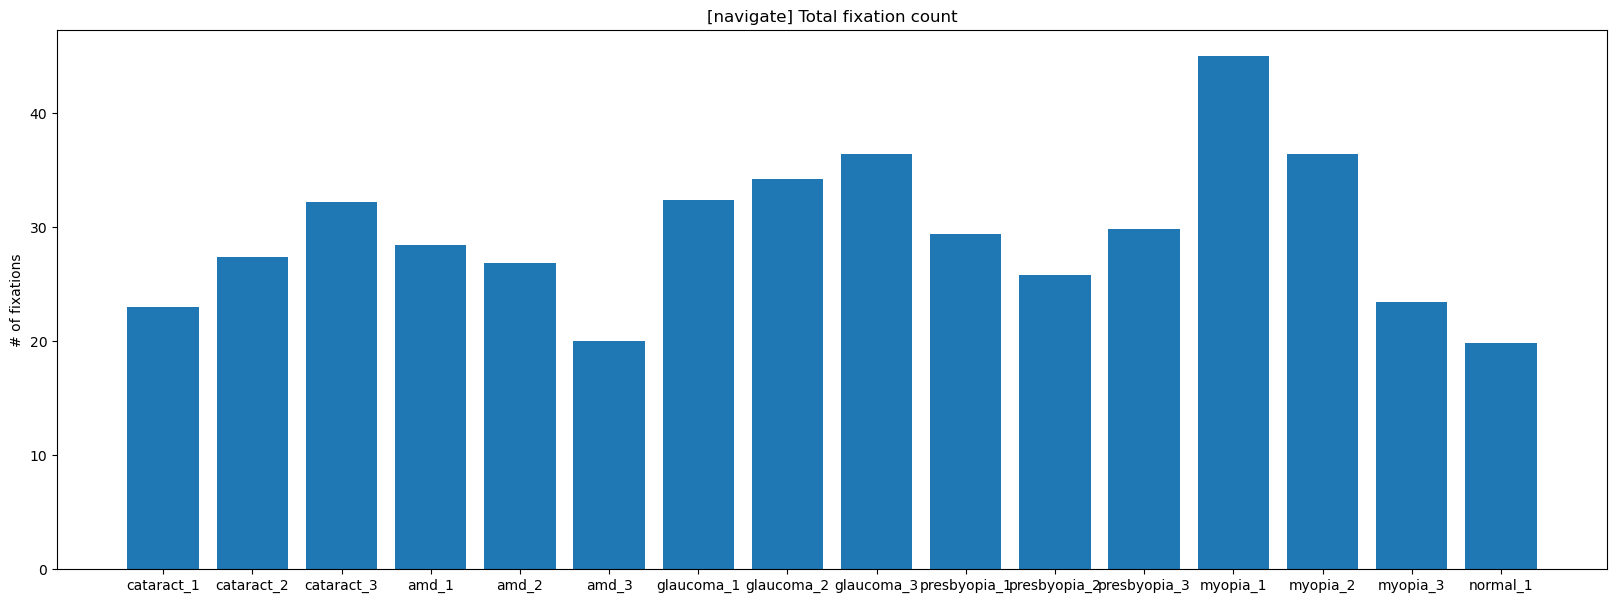

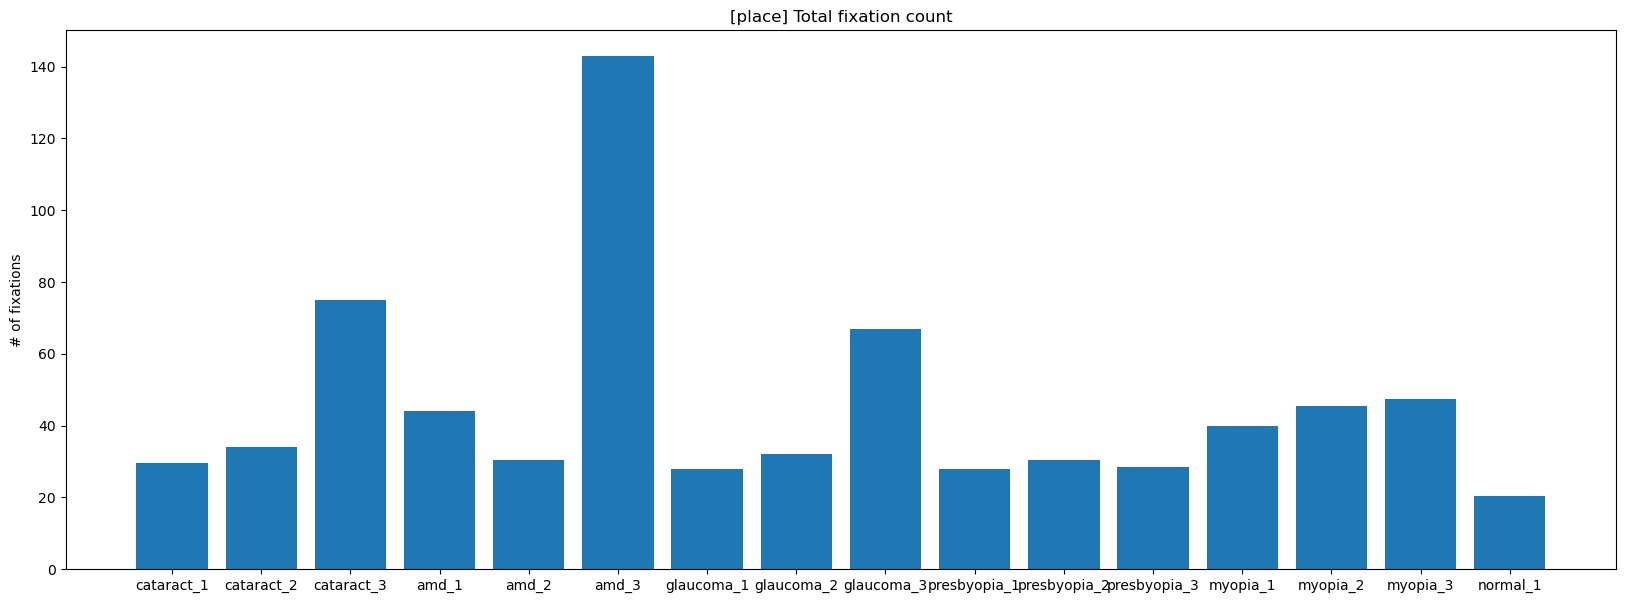

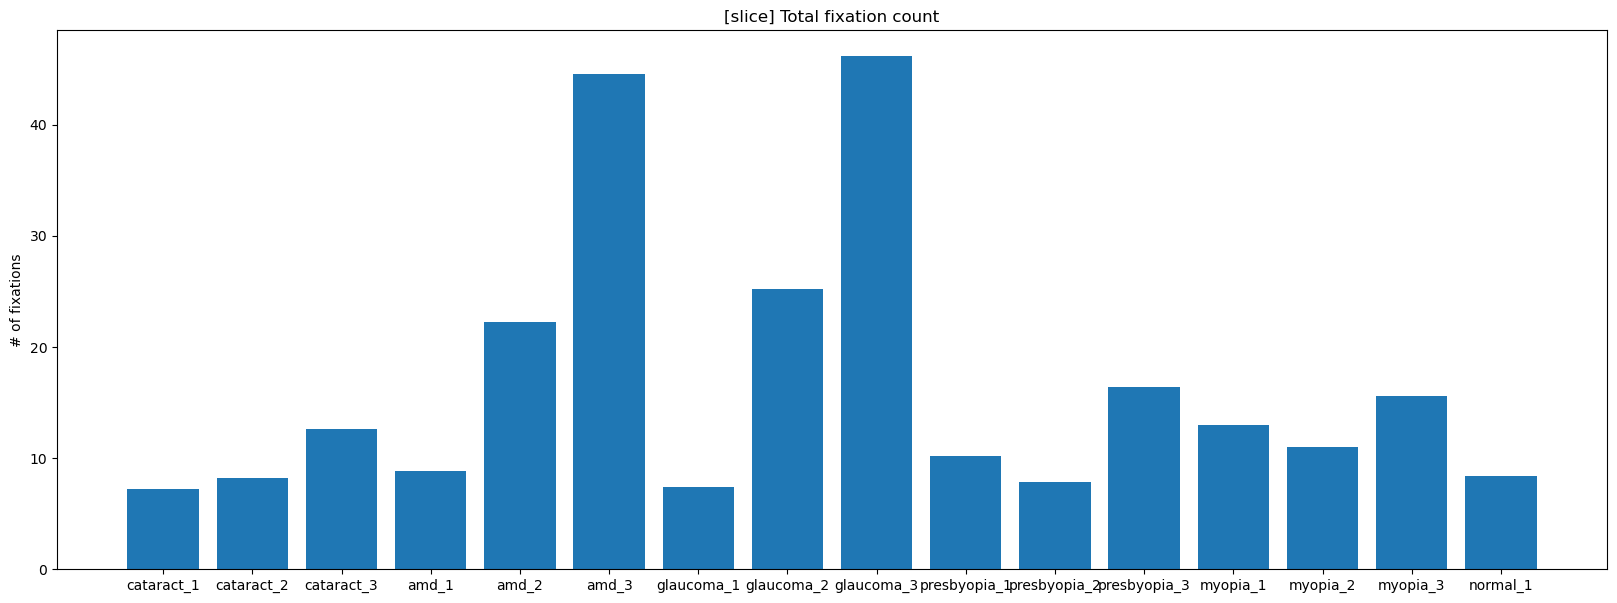

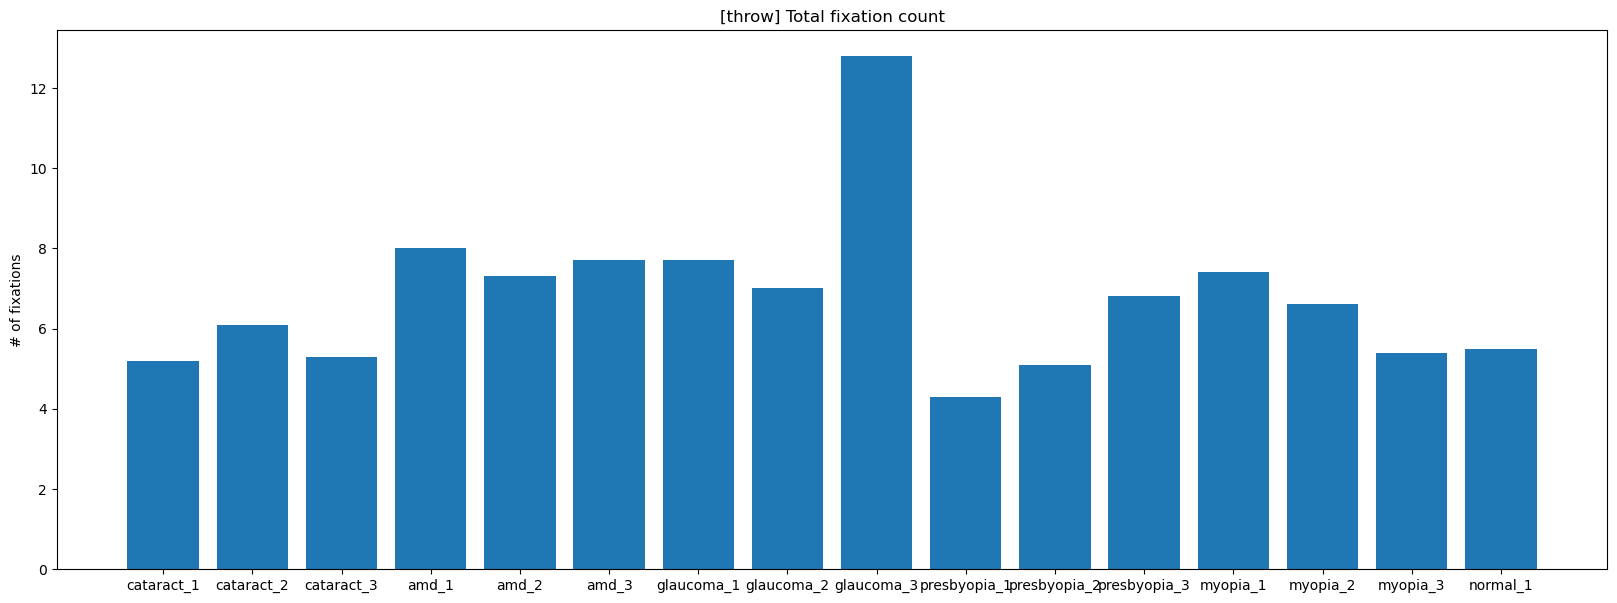

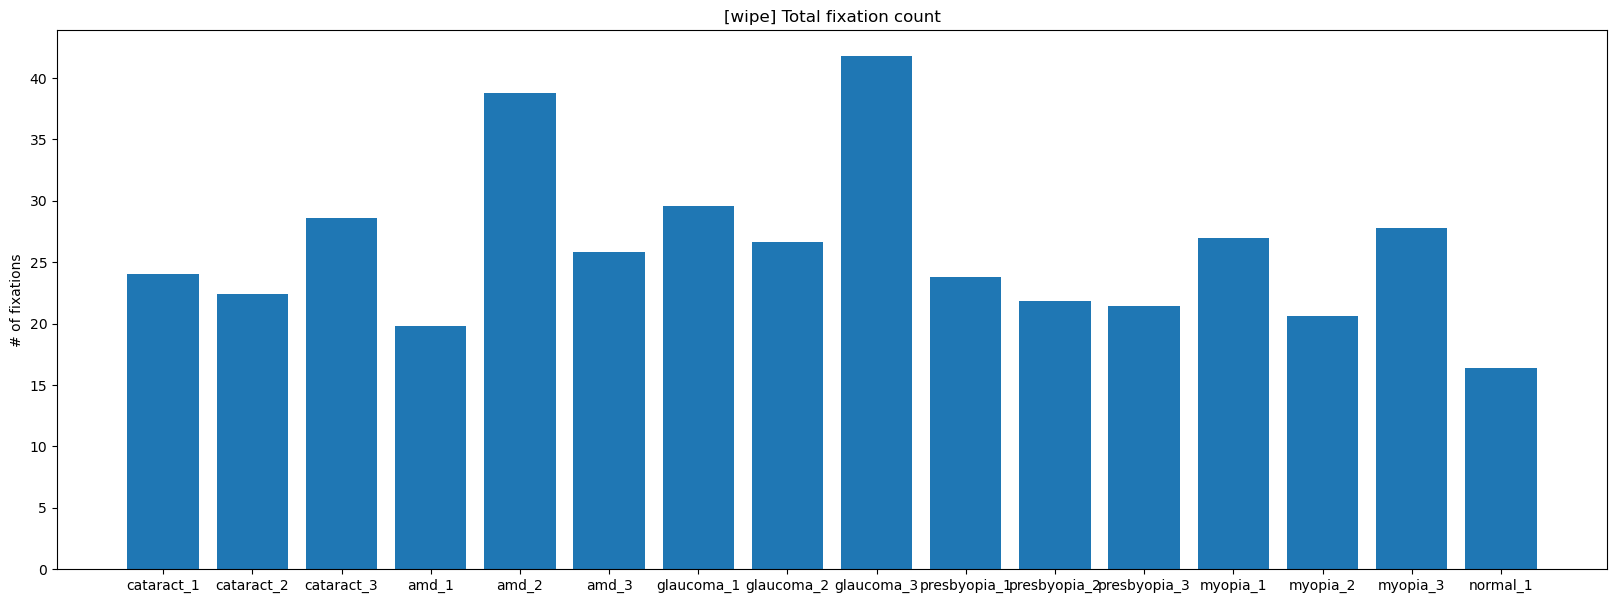

In [9]:
# Total fixation count
if save_json:
    with open(rf"{data_path}/json/dv2/total_fixation_count.json", "w") as f:
        json.dump(fixation_data["fixation_count"], f)
avg_fixation_count = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_fixation_count[task][vi] = []
        for id in ids:
            avg_fixation_count[task][vi].append(np.mean(list(fixation_data["fixation_count"][f"{task}_{vi}"][id].values())))
        avg_fixation_count[task][vi] = np.mean(avg_fixation_count[task][vi])
    vi_data.bar_plot(data=list(avg_fixation_count[task].values()), tick_label=vis, title=f"[{task}] Total fixation count", ylabel="# of fixations")

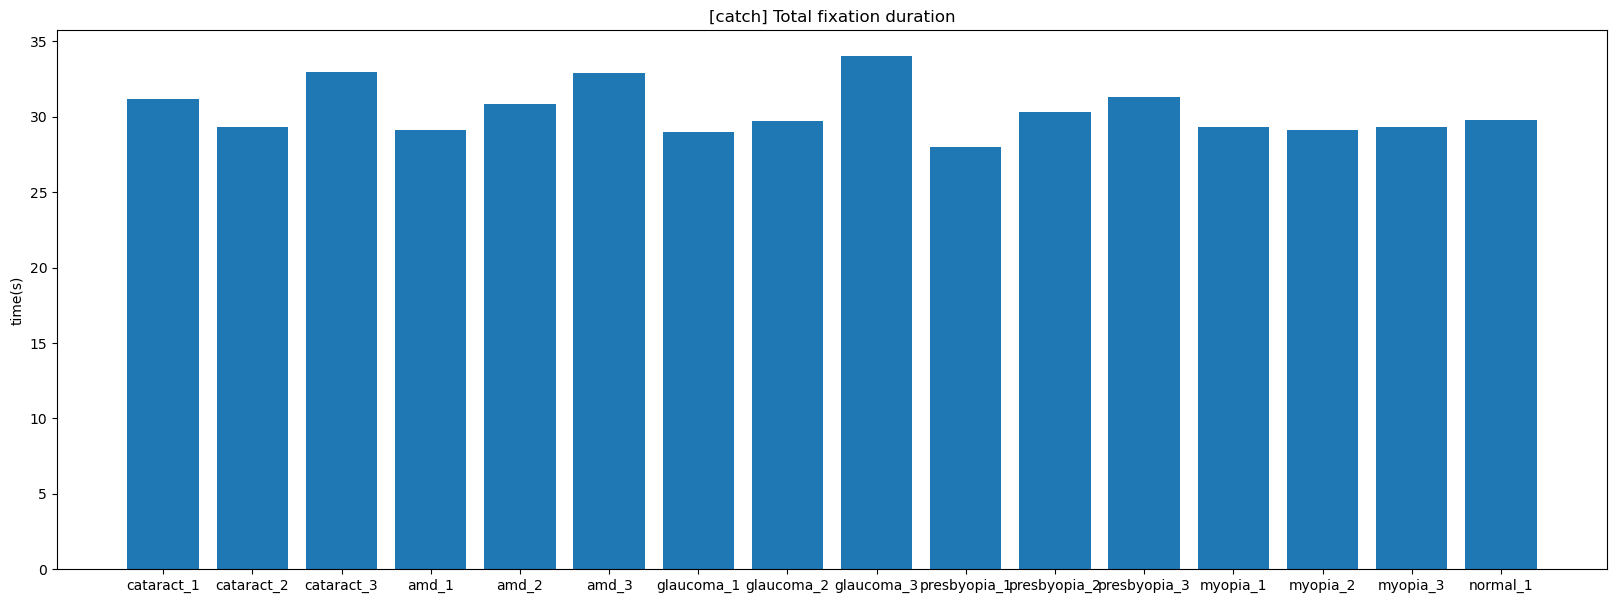

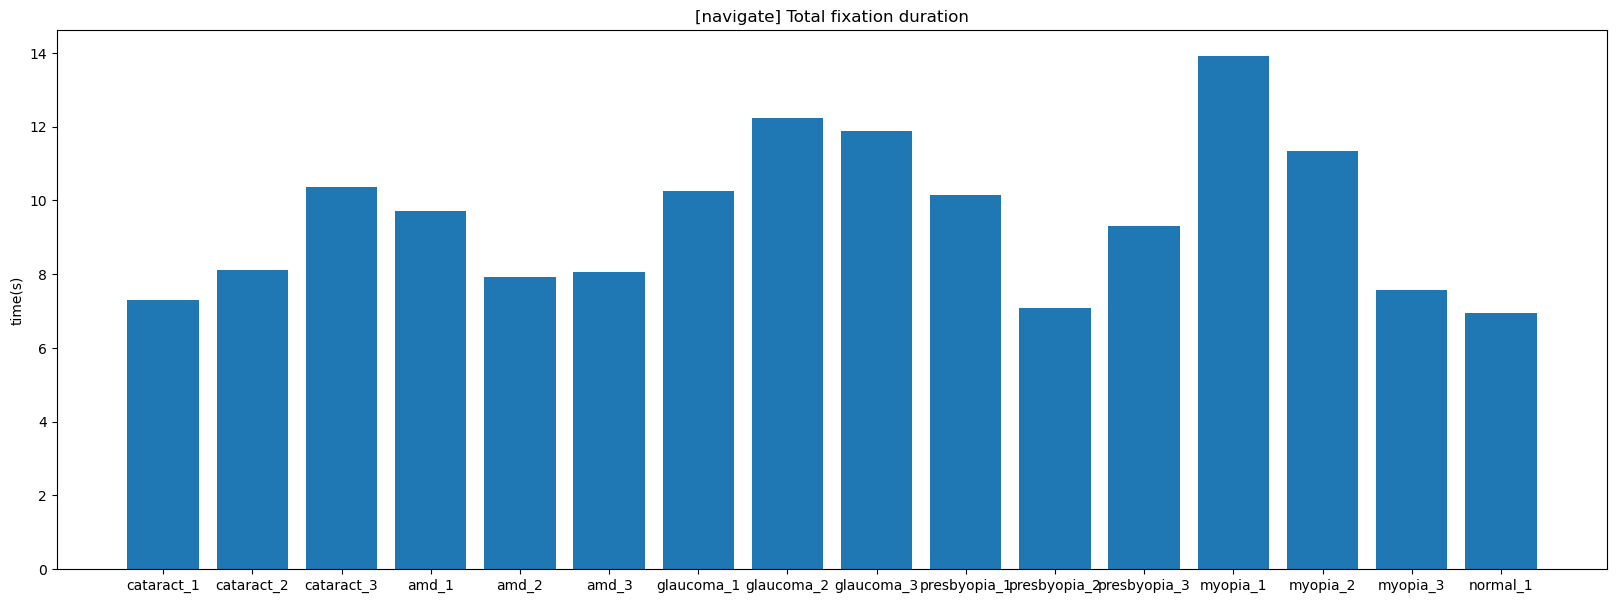

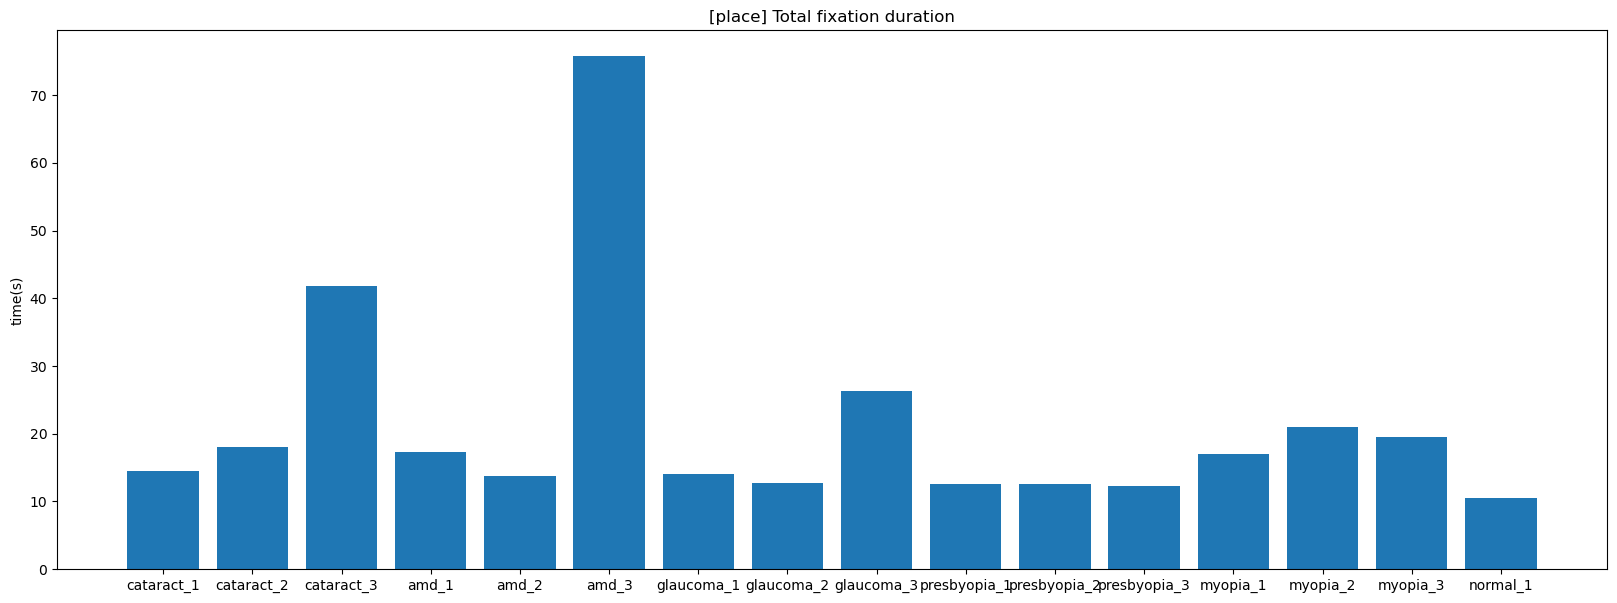

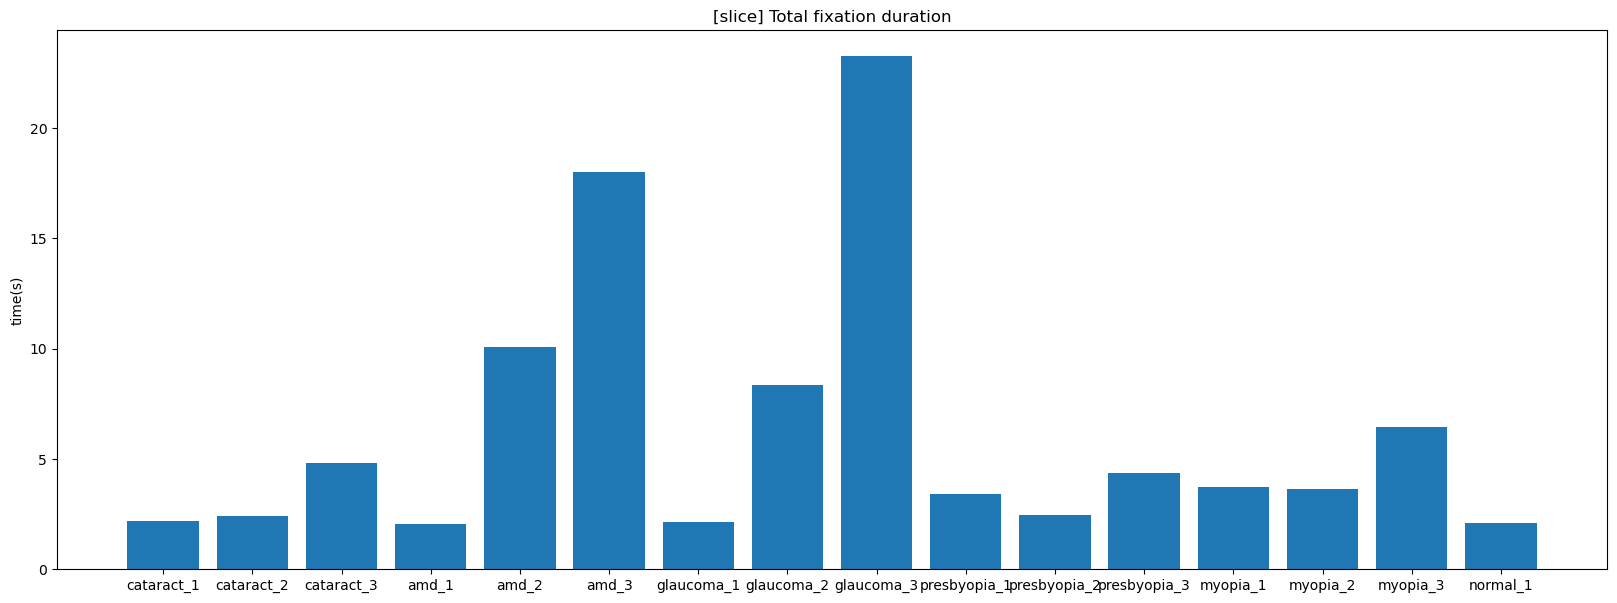

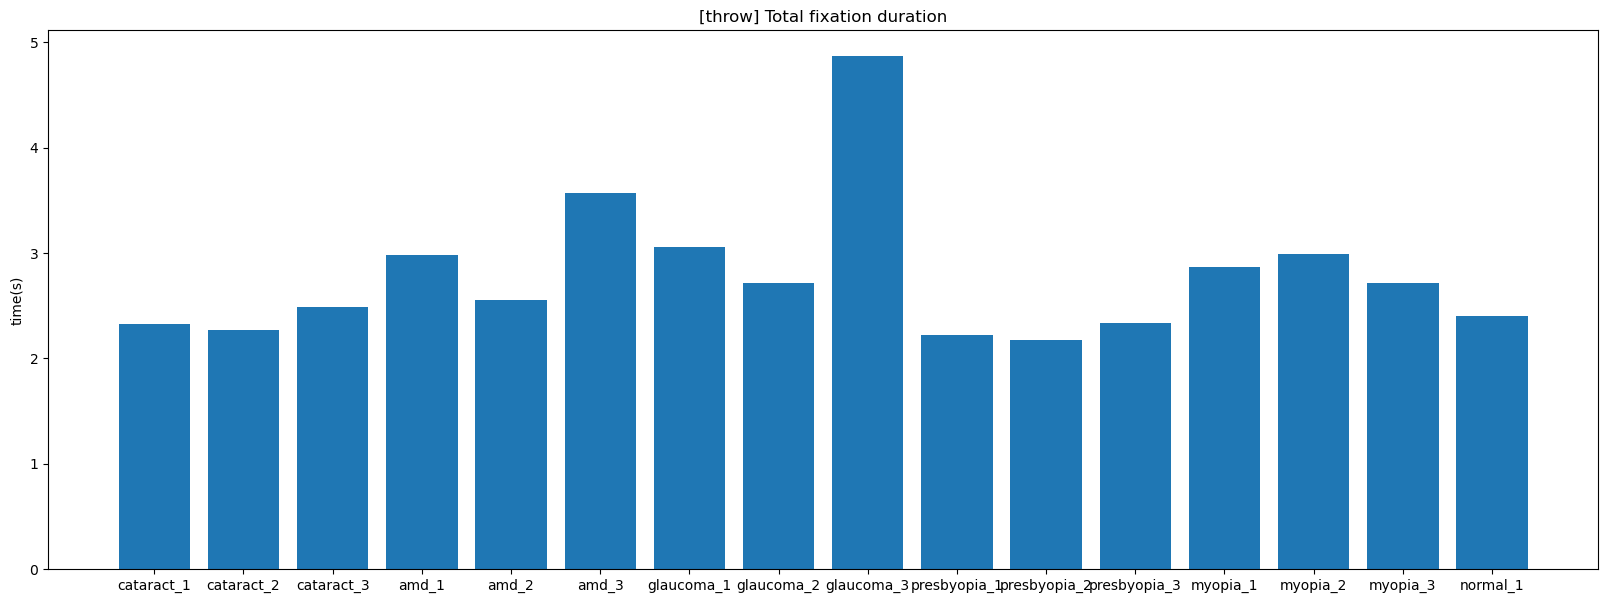

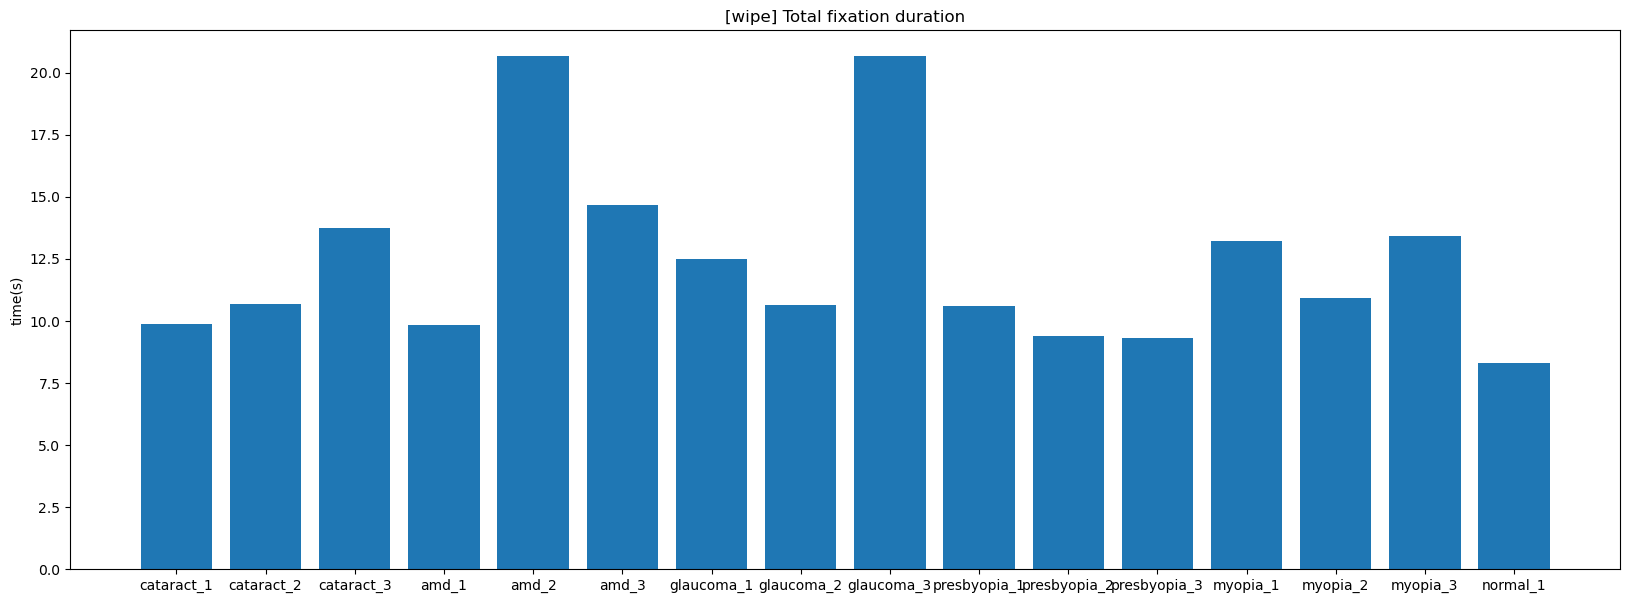

In [10]:
# Total fixation duration
if save_json:
    with open(rf"{data_path}/json/dv2/total_fixation_duration.json", "w") as f:
        json.dump(fixation_data["fixation_duration"], f)
avg_fixation_dur = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_fixation_dur[task][vi] = []
        for id in ids:
            avg_fixation_dur[task][vi].append(np.mean(list(fixation_data["fixation_duration"][f"{task}_{vi}"][id].values())))
        avg_fixation_dur[task][vi] = np.mean(avg_fixation_dur[task][vi])
    vi_data.bar_plot(data=list(avg_fixation_dur[task].values()), tick_label=vis, title=f"[{task}] Total fixation duration", ylabel="time(s)")

In [11]:
# Plotting sample fixations
# %matplotlib ipympl
# id = 6
# original_pos = np.array(vi_data.hfs["catch_normal_1"][id][0]["vr/vr_eye_tracking_data"])[:, 7:9]
# fixation_pos = np.zeros((len(original_pos), 2))
# for i in range(fixation_data["fixation_count"]["catch_normal_1"][id][0]):
#     s, e = fixation_data["fixation_start"]["catch_normal_1"][id][0][i], fixation_data["fixation_end"]["catch_normal_1"][id][0][i]
#     x, y = fixation_data["fixation_x"]["catch_normal_1"][id][0][i], fixation_data["fixation_y"]["catch_normal_1"][id][0][i]
#     fixation_pos[s:e] = [x, y]
# vi_data.plot_fixation(original_pos, fixation_pos)

## Task completion time

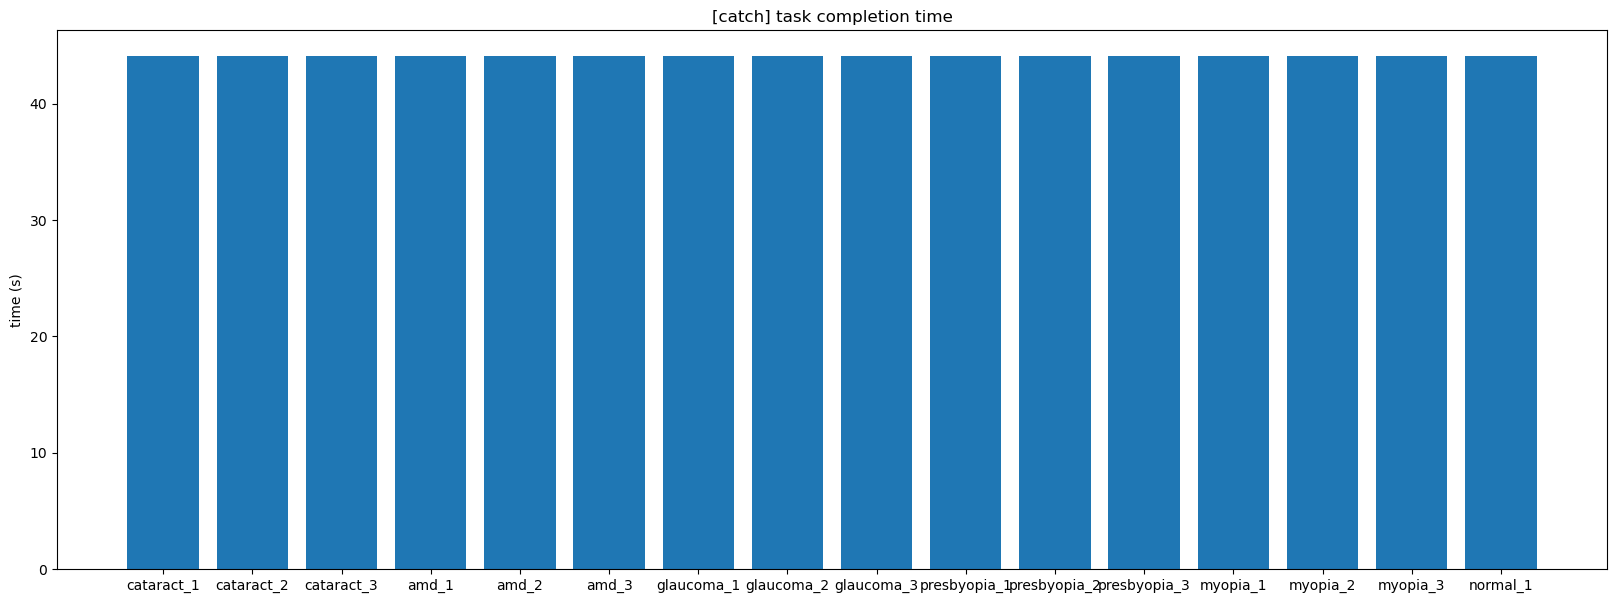

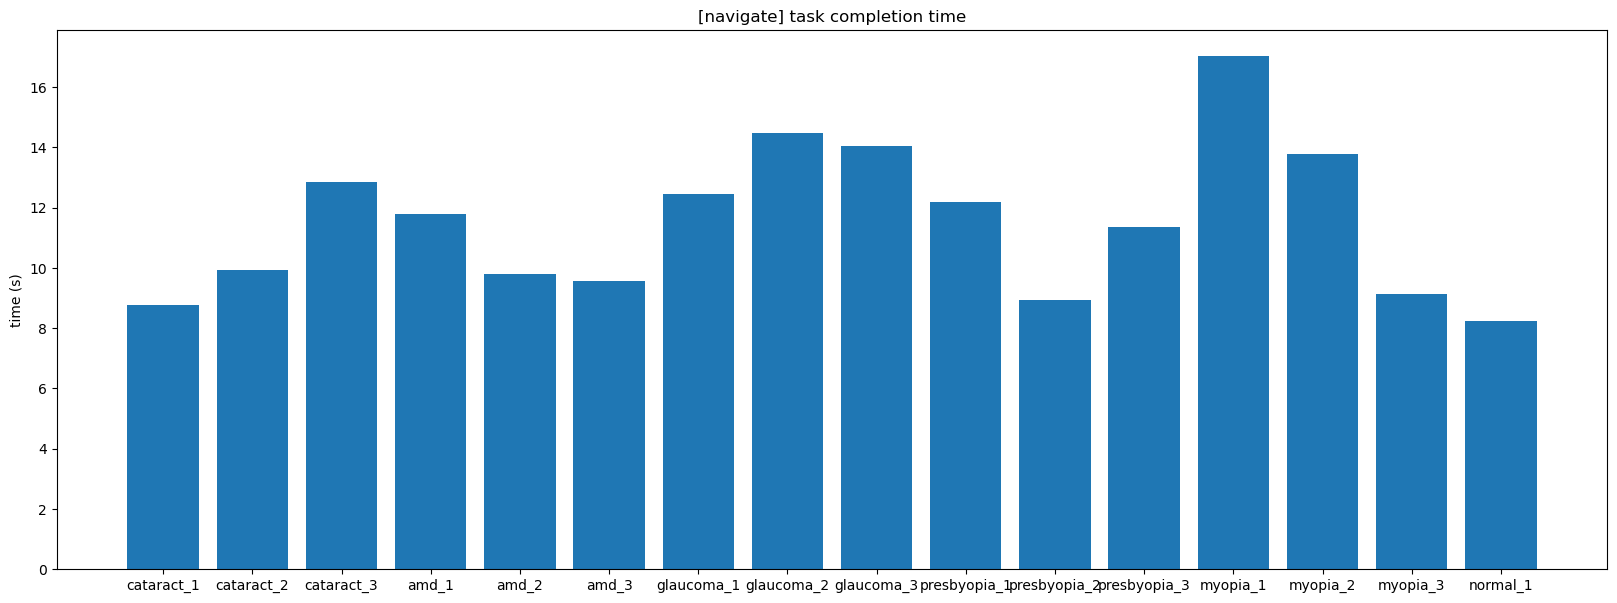

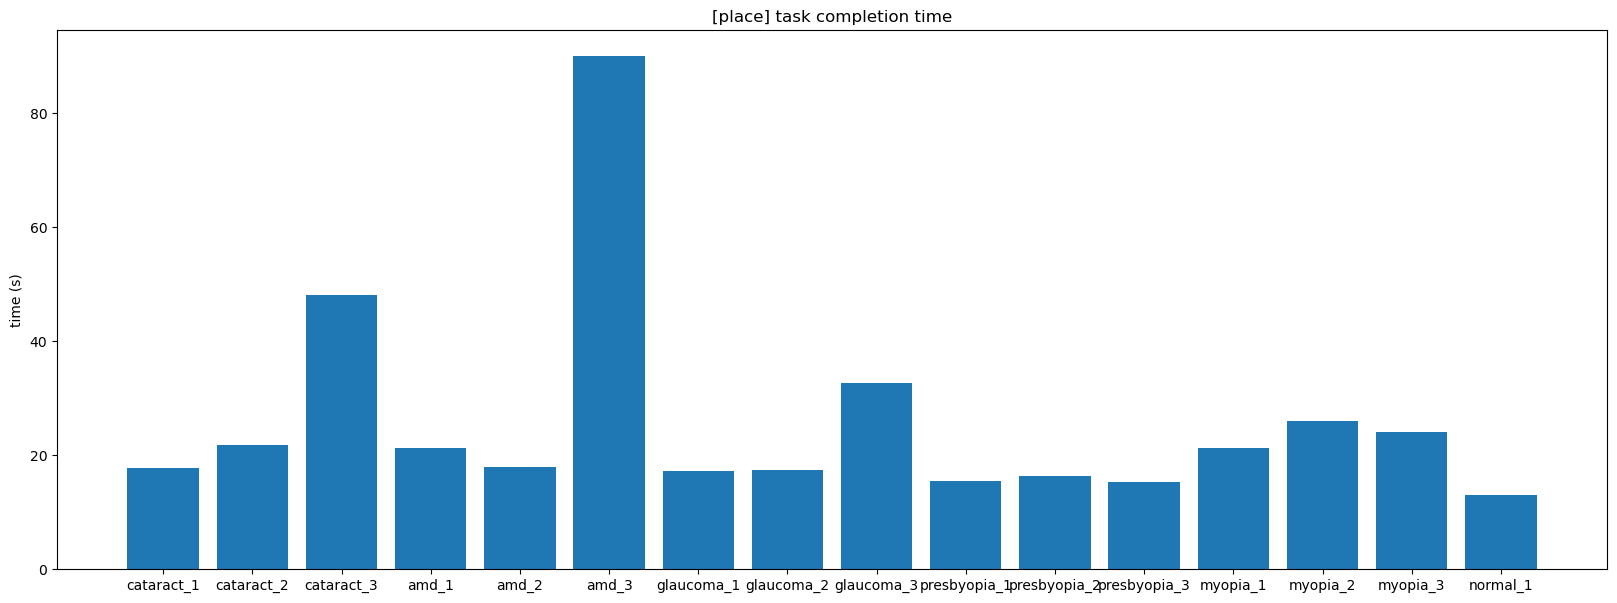

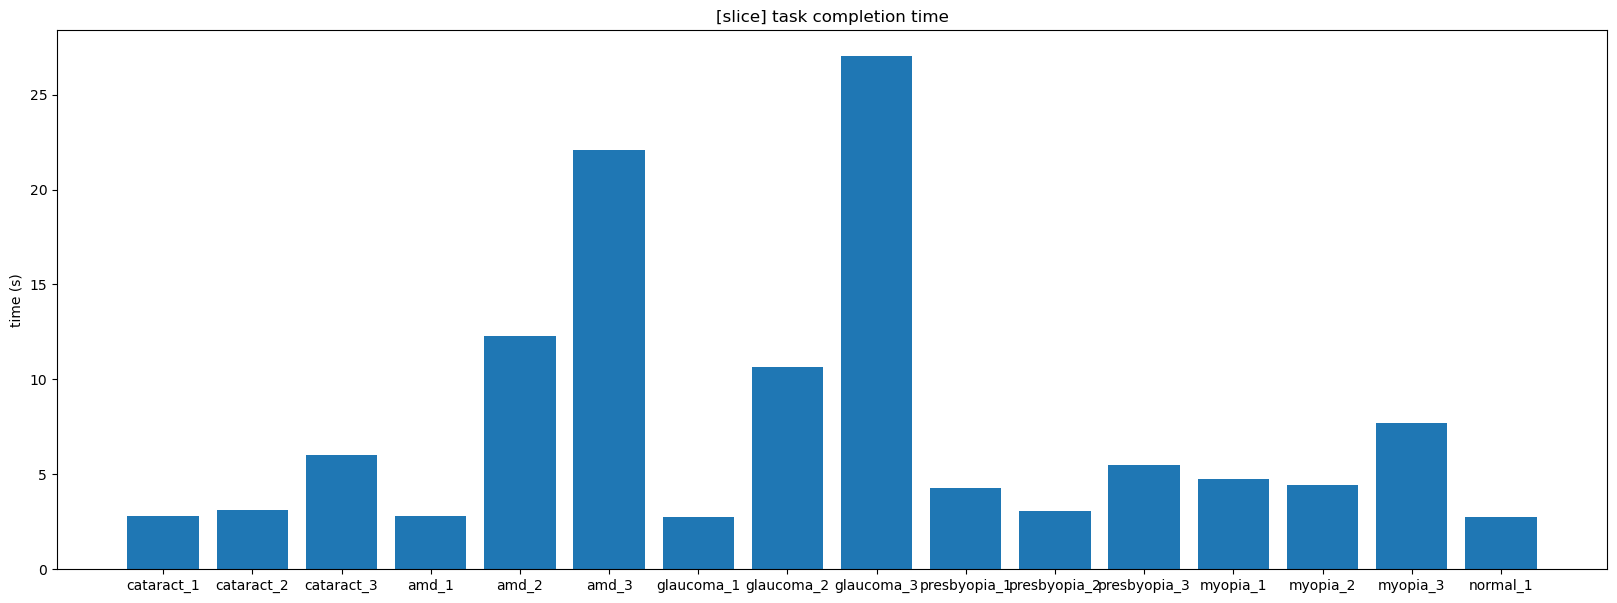

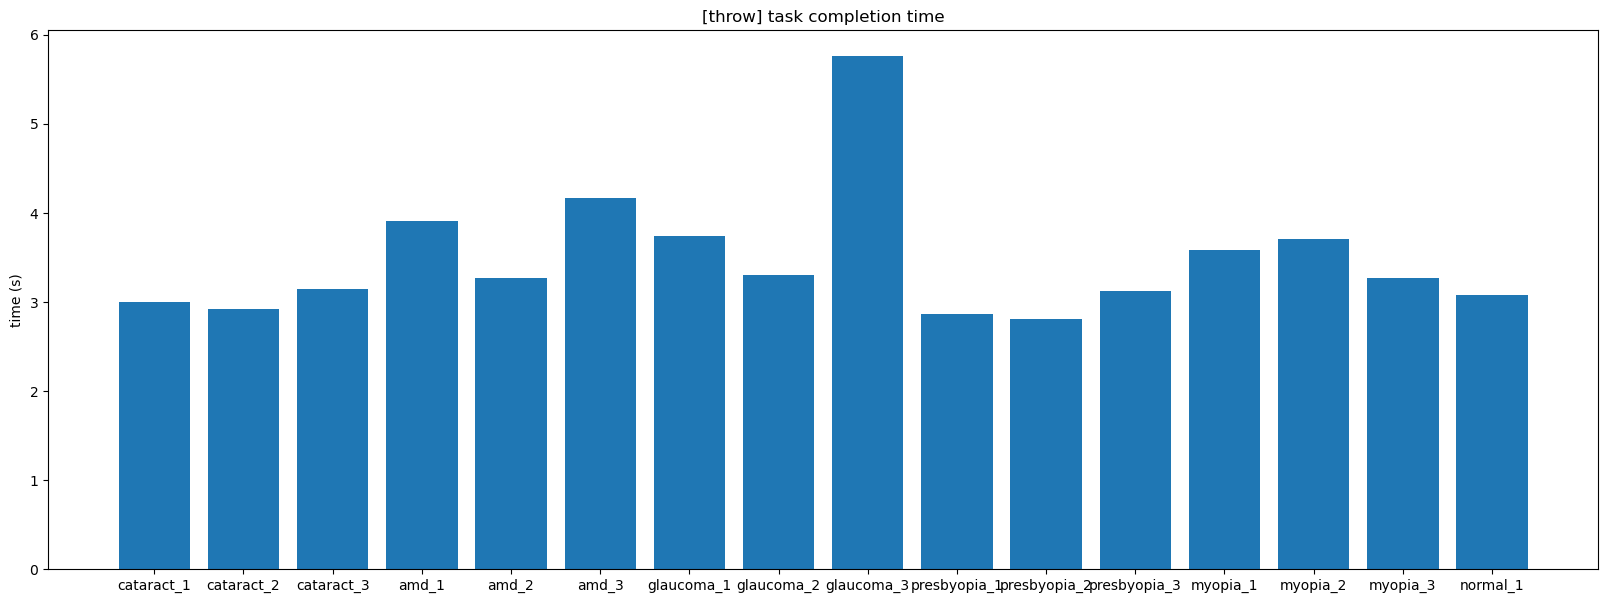

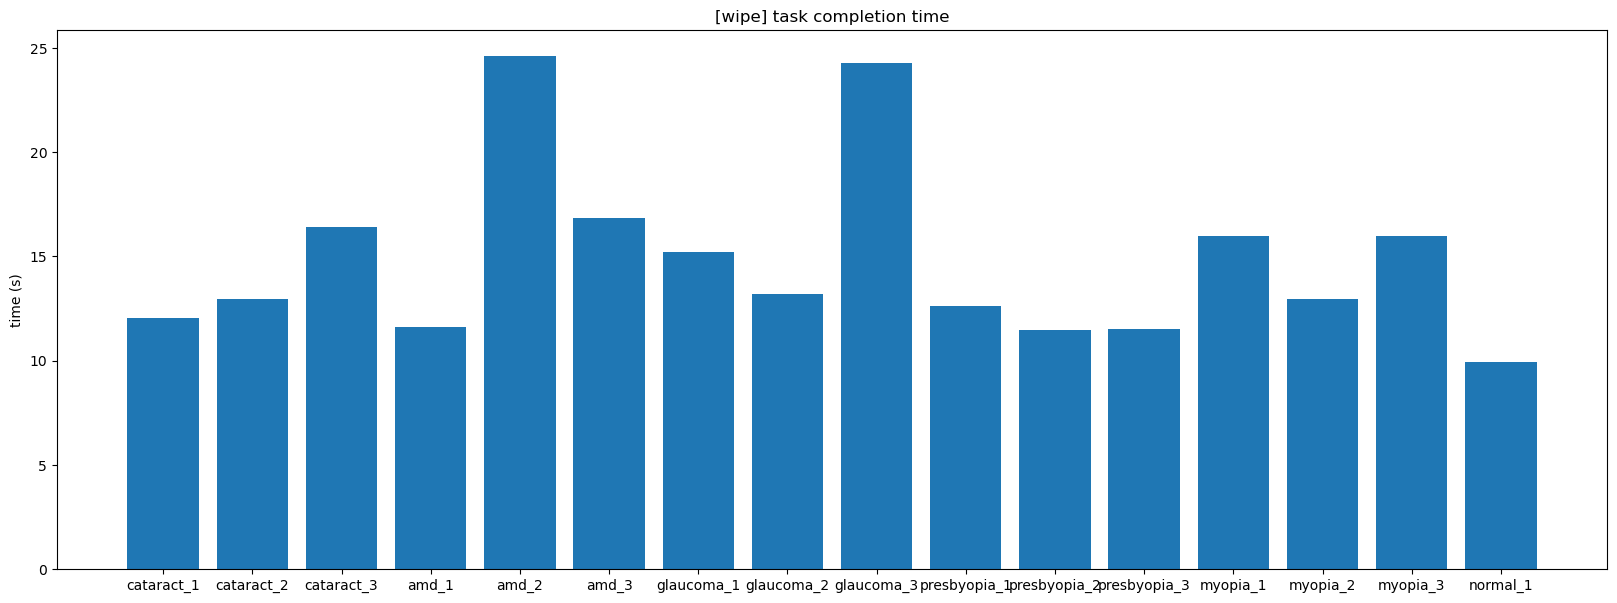

In [12]:
completion_time = vi_data.get_attr('/metadata/task_completion_time')
if save_json:
    with open(f"{data_path}/json/dv1/task_completion_time.json", "w") as f:
        json.dump(completion_time, f)
        
avg_completion_time = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_completion_time[task][vi] = []
        for id in ids:
            avg_completion_time[task][vi].append(np.mean(list(completion_time[f"{task}_{vi}"][id].values())))
        avg_completion_time[task][vi] = np.mean(avg_completion_time[task][vi])
    vi_data.bar_plot(data=list(avg_completion_time[task].values()), tick_label=vis, title=f"[{task}] task completion time", ylabel="time (s)")

## Tracker Movements

### Head Movements

In [13]:
hmd_translation_data = vi_data.get_device_translation(device="hmd", method=np.sum)
hmd_rotation_data = vi_data.get_device_rotation(device="hmd", method=np.sum)

if save_json:
    with open(f"{data_path}/json/dv2/total_hmd_translation.json", "w") as f:
        json.dump(hmd_translation_data, f)
    with open(f"{data_path}/json/dv2/total_hmd_rotation.json", "w") as f:
        json.dump(hmd_rotation_data, f)

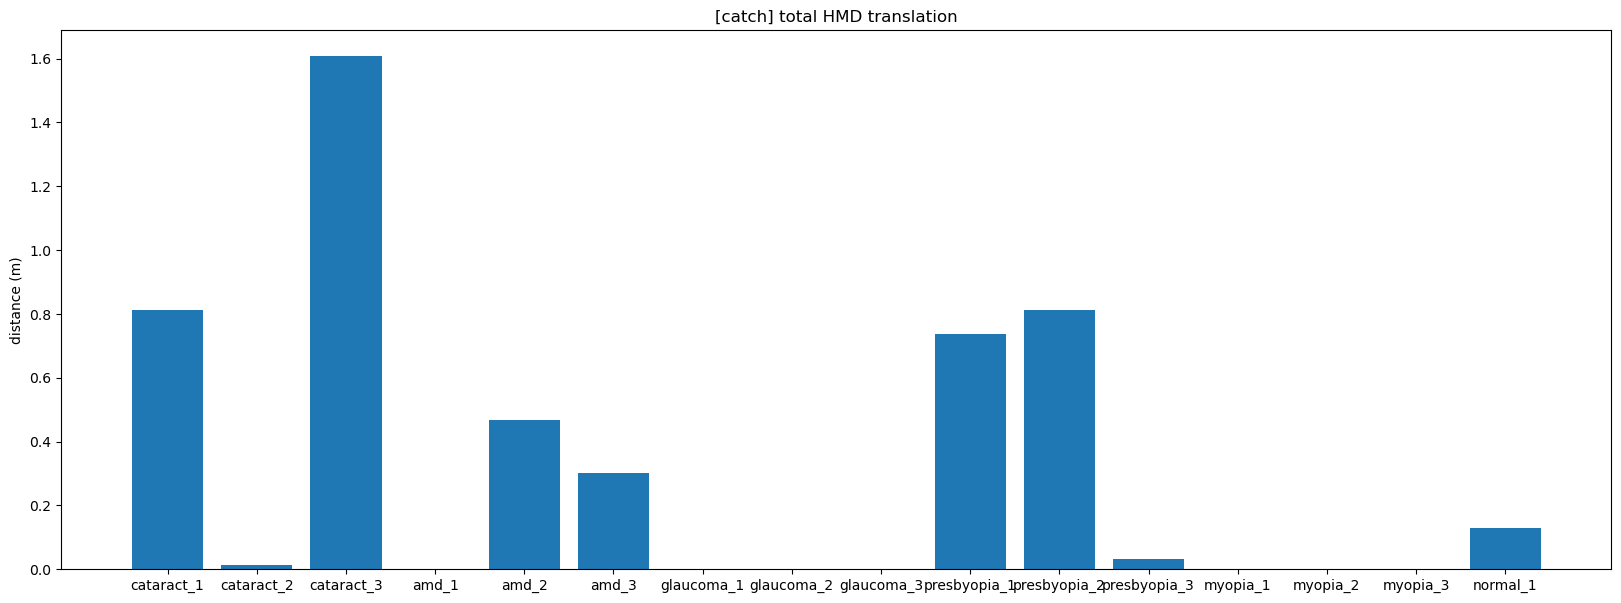

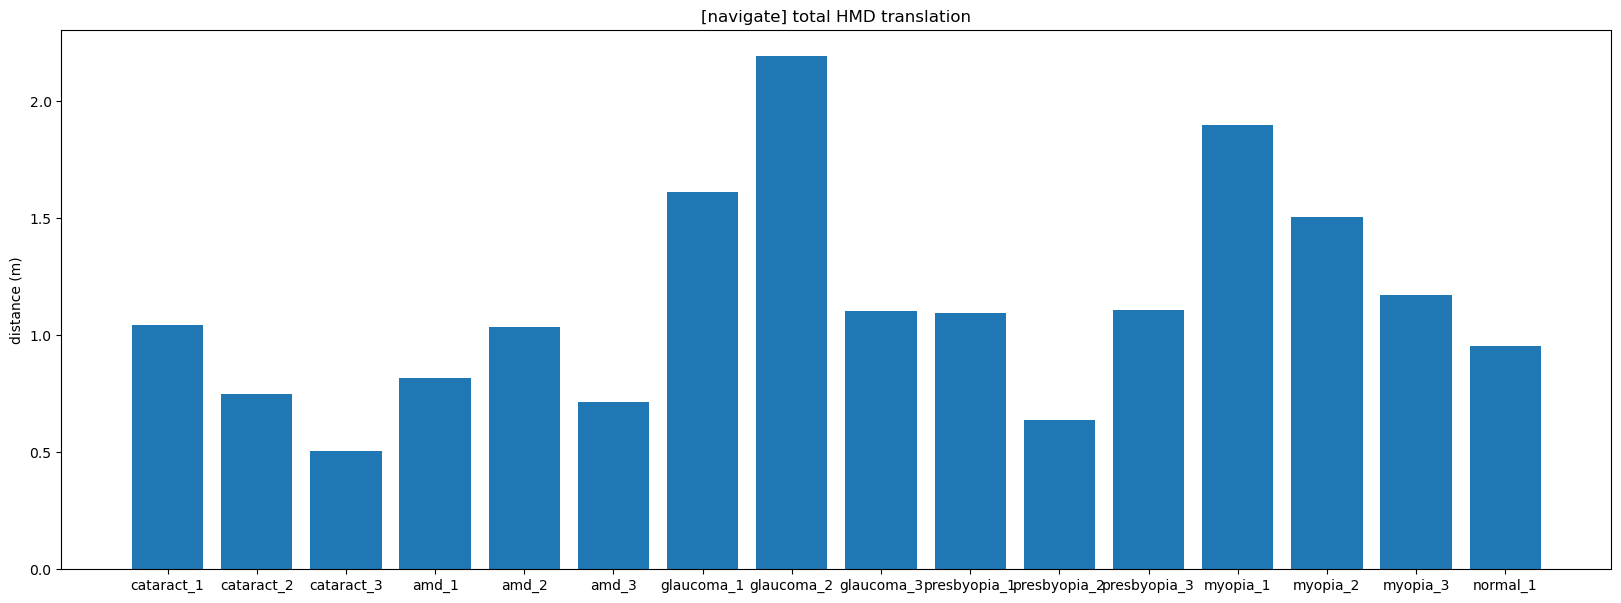

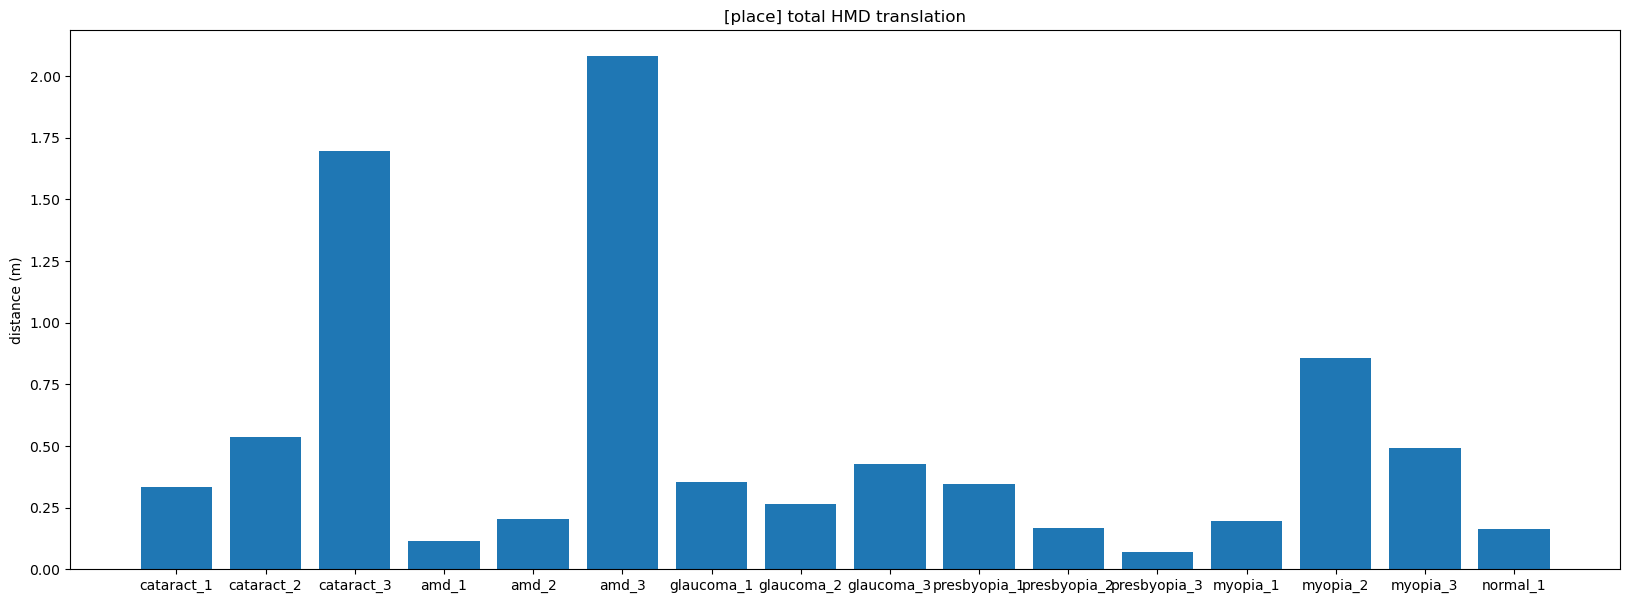

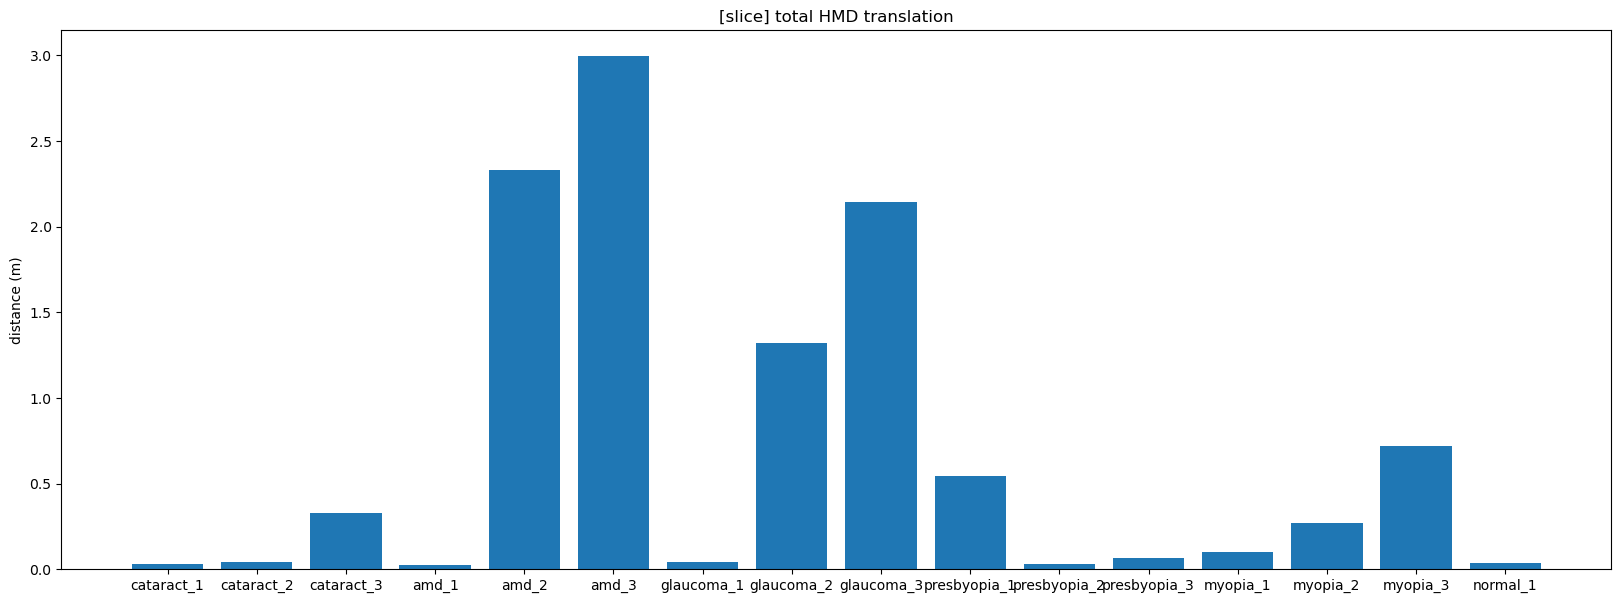

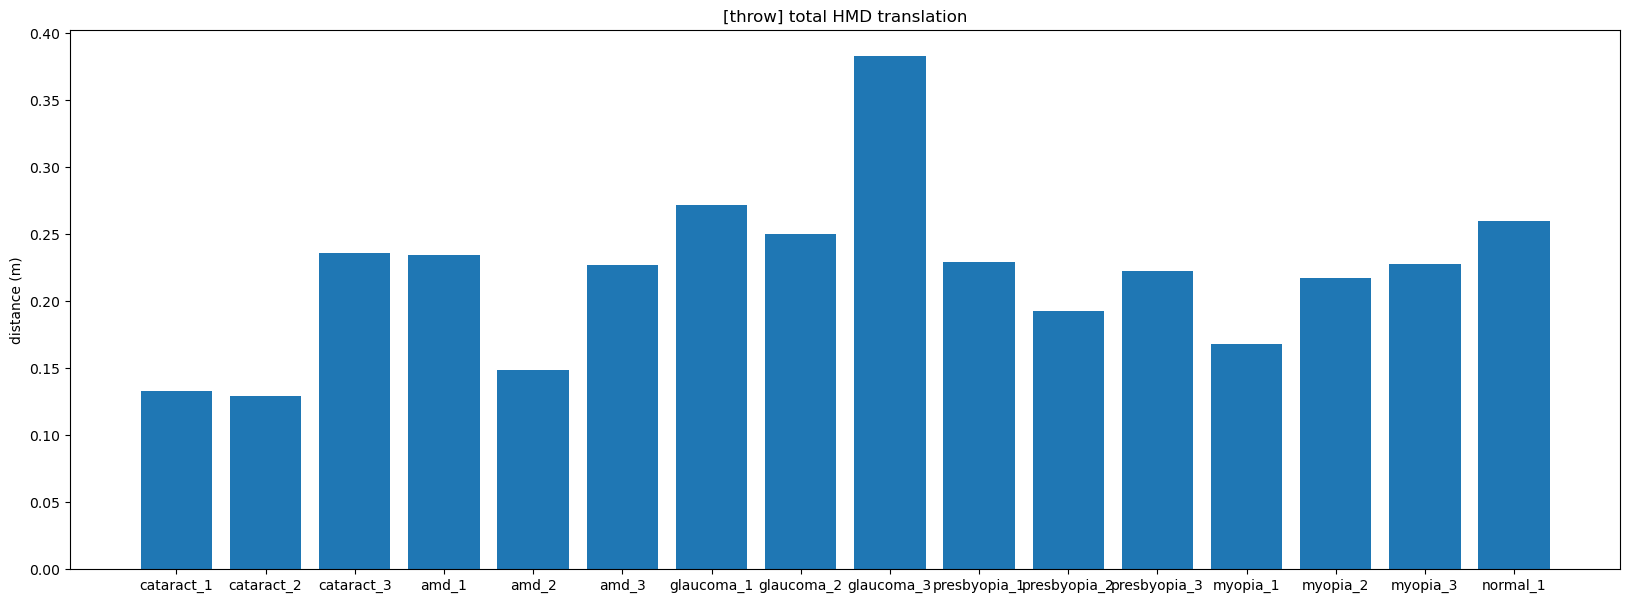

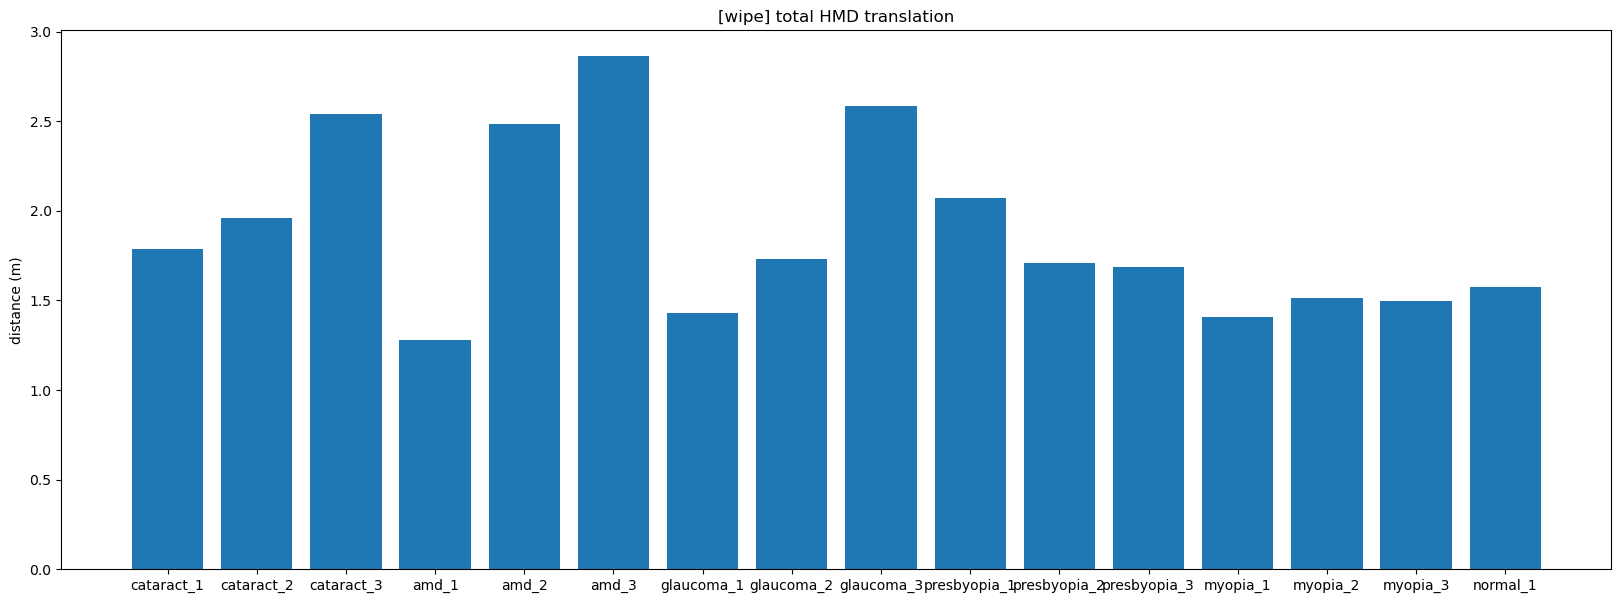

In [14]:
avg_hmd_translation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_hmd_translation_data[task][vi] = []
        for id in ids:
            avg_hmd_translation_data[task][vi].append(np.mean(list(hmd_translation_data[f"{task}_{vi}"][id].values())))
        avg_hmd_translation_data[task][vi] = np.mean(avg_hmd_translation_data[task][vi])
    vi_data.bar_plot(data=list(avg_hmd_translation_data[task].values()), tick_label=vis, title=f"[{task}] total HMD translation", ylabel="distance (m)")

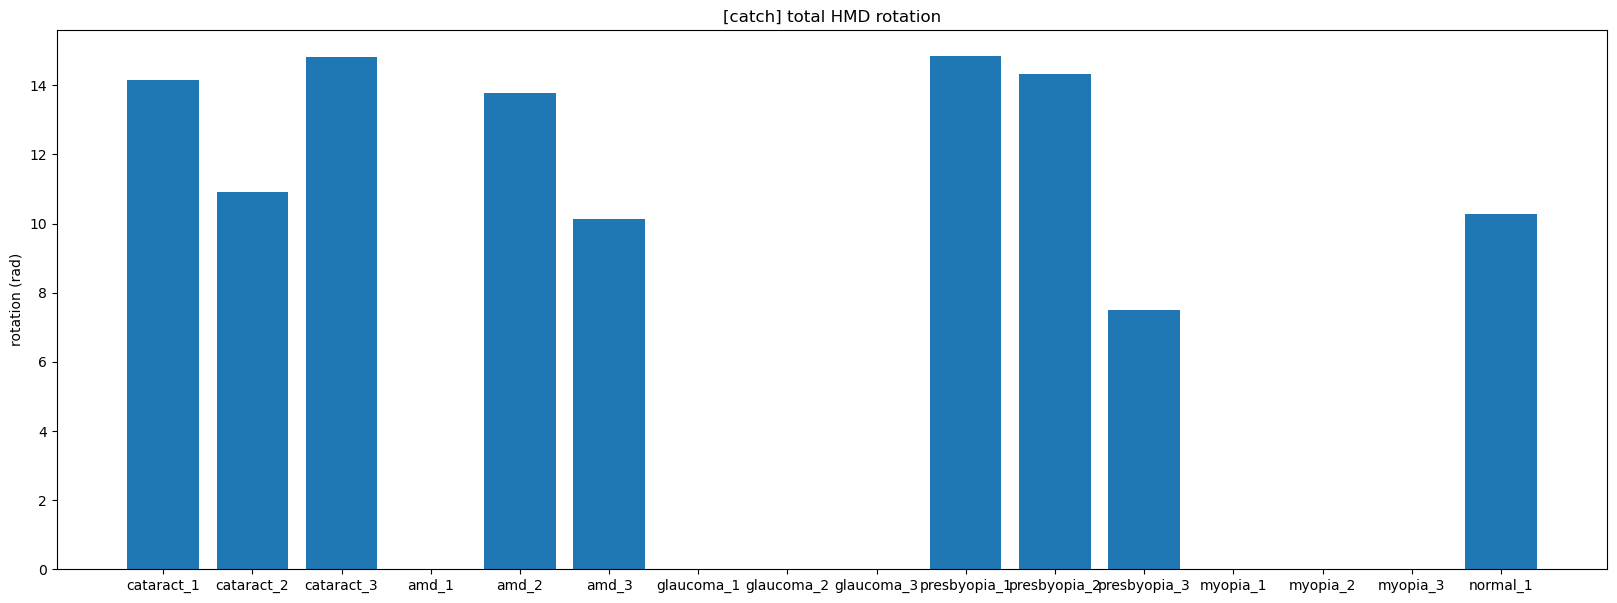

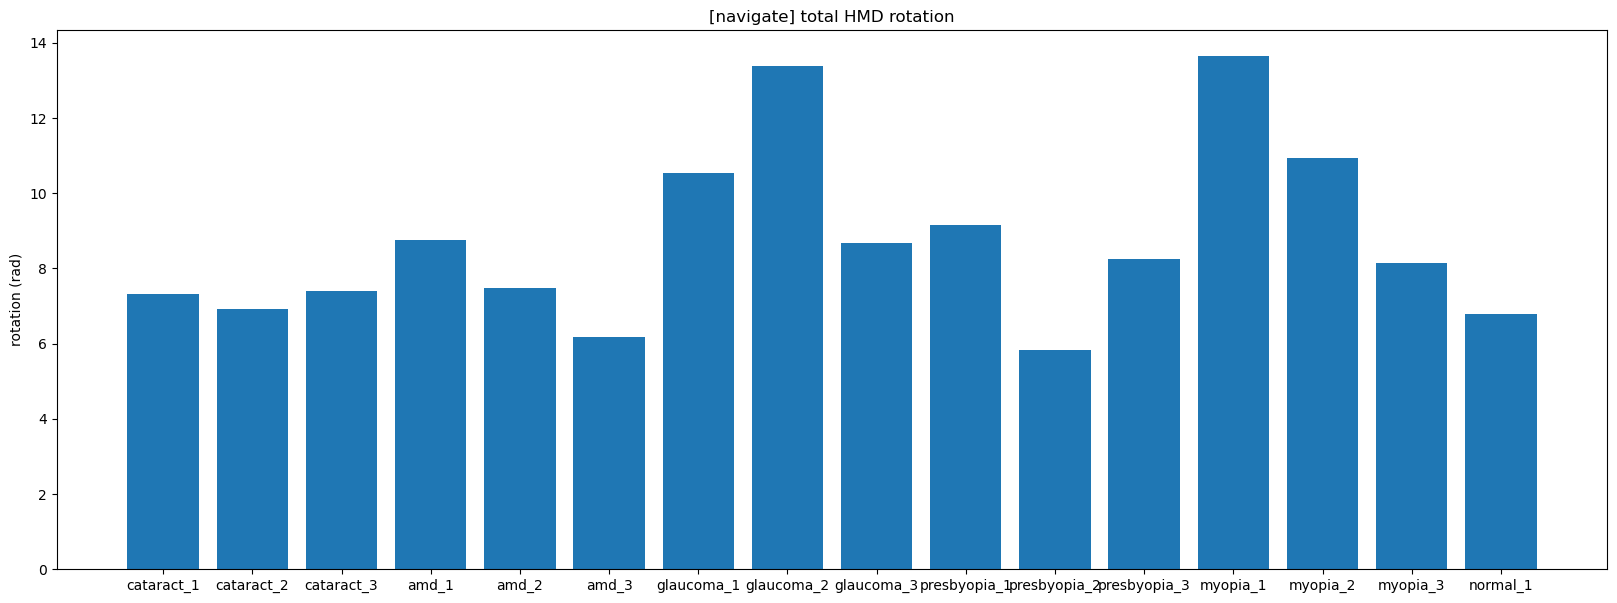

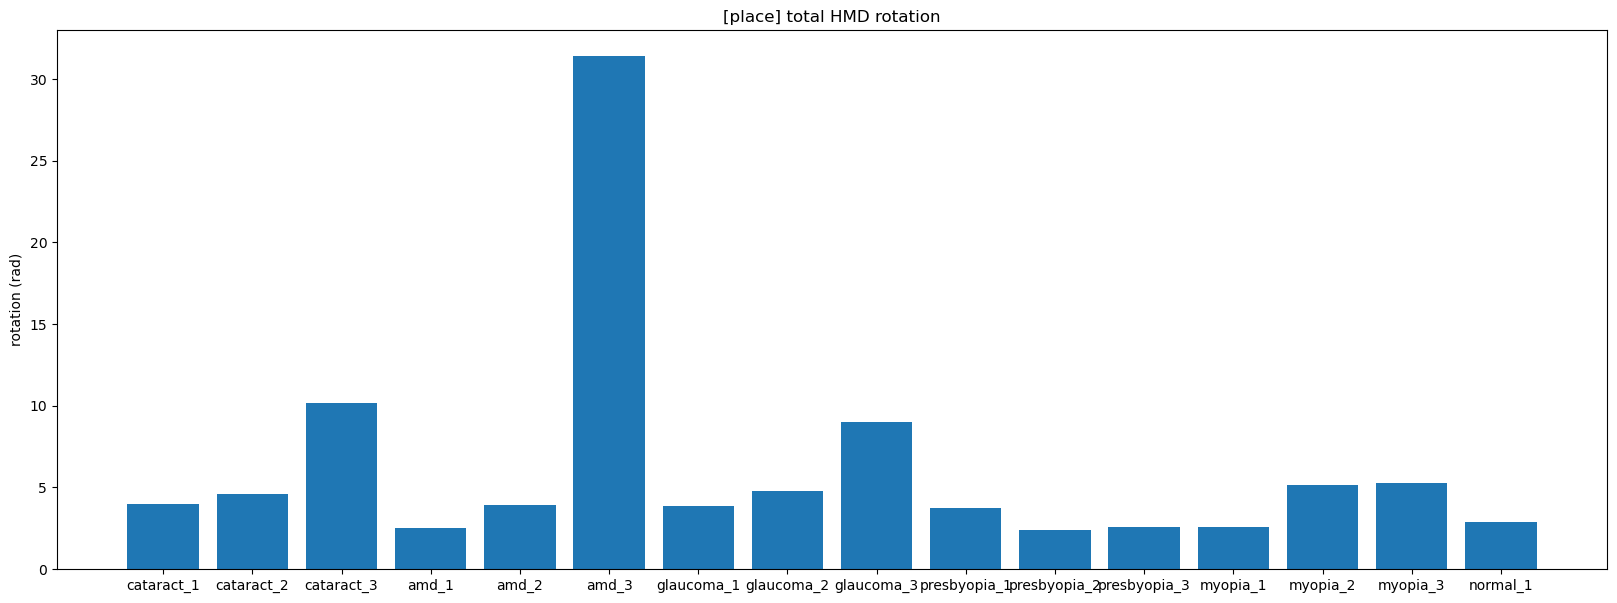

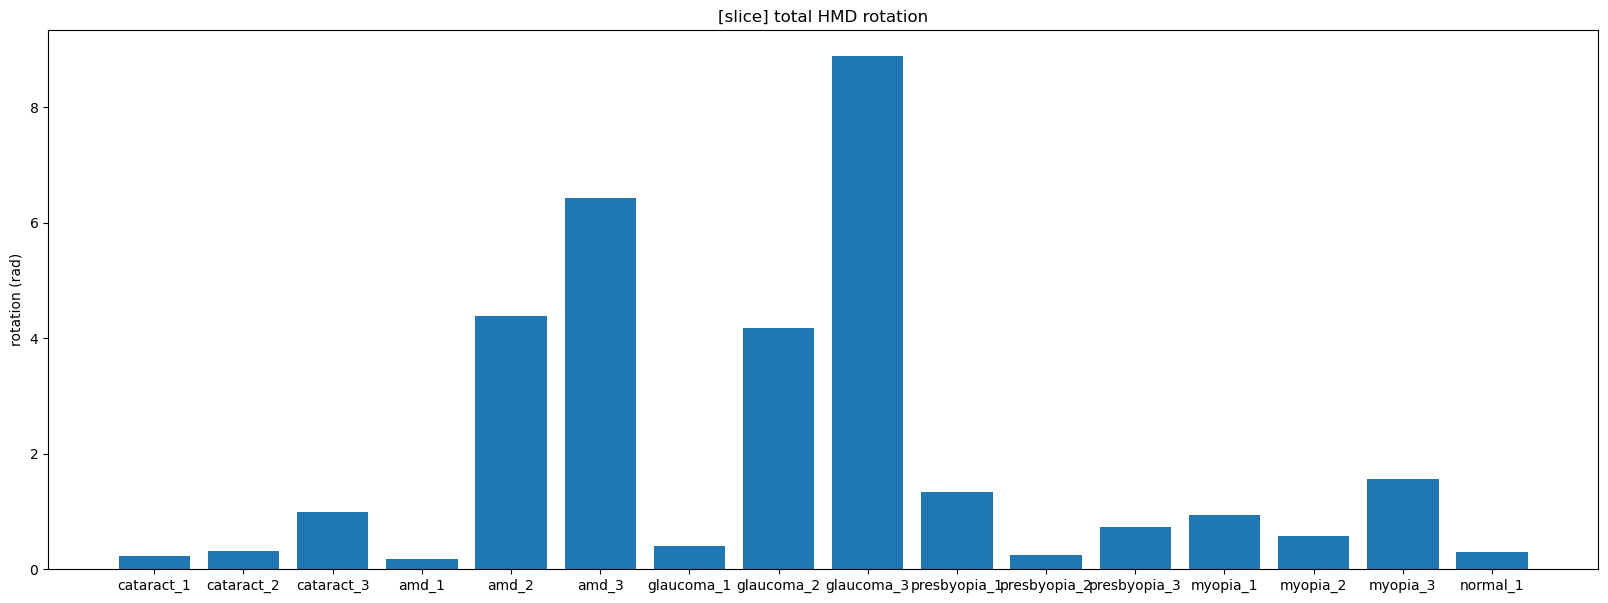

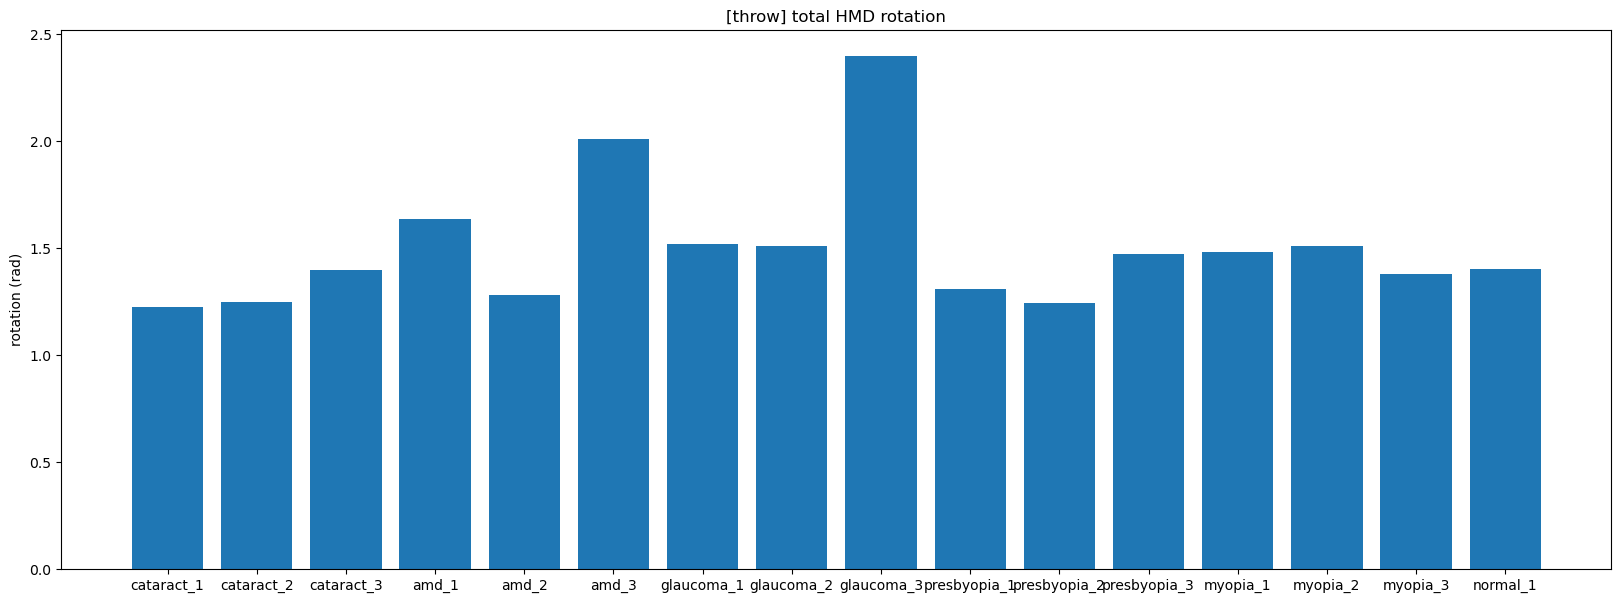

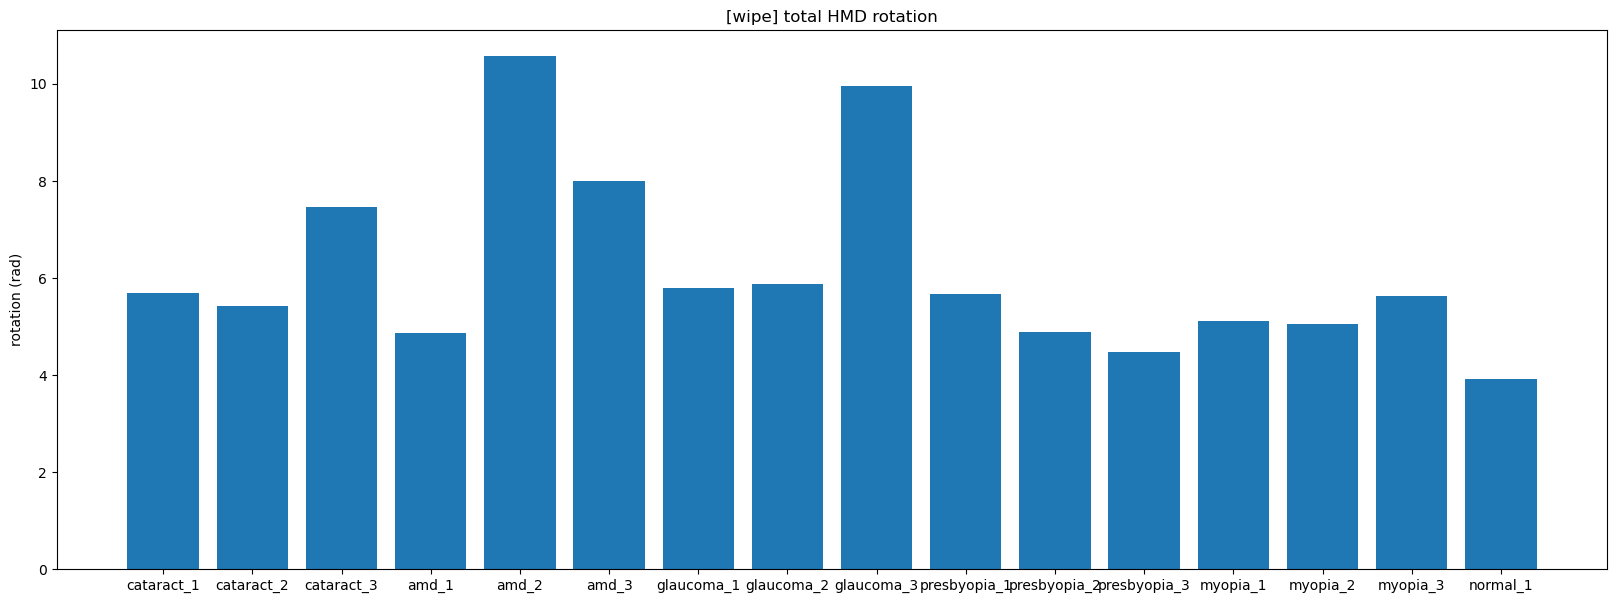

In [15]:
avg_hmd_rotation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_hmd_rotation_data[task][vi] = []
        for id in ids:
            avg_hmd_rotation_data[task][vi].append(np.mean(list(hmd_rotation_data[f"{task}_{vi}"][id].values())))
        avg_hmd_rotation_data[task][vi] = np.mean(avg_hmd_rotation_data[task][vi])
    vi_data.bar_plot(data=list(avg_hmd_rotation_data[task].values()), tick_label=vis, title=f"[{task}] total HMD rotation", ylabel="rotation (rad)")

### Body Movements

In [16]:
body_translation_data = vi_data.get_device_translation(device="torso_tracker", method=np.sum)
body_rotation_data = vi_data.get_device_rotation(device="torso_tracker", method=np.sum)

if save_json:
    with open(f"{data_path}/json/dv2/total_body_translation.json", "w") as f:
        json.dump(body_translation_data, f)
    with open(f"{data_path}/json/dv2/total_body_rotation.json", "w") as f:
        json.dump(body_rotation_data, f)

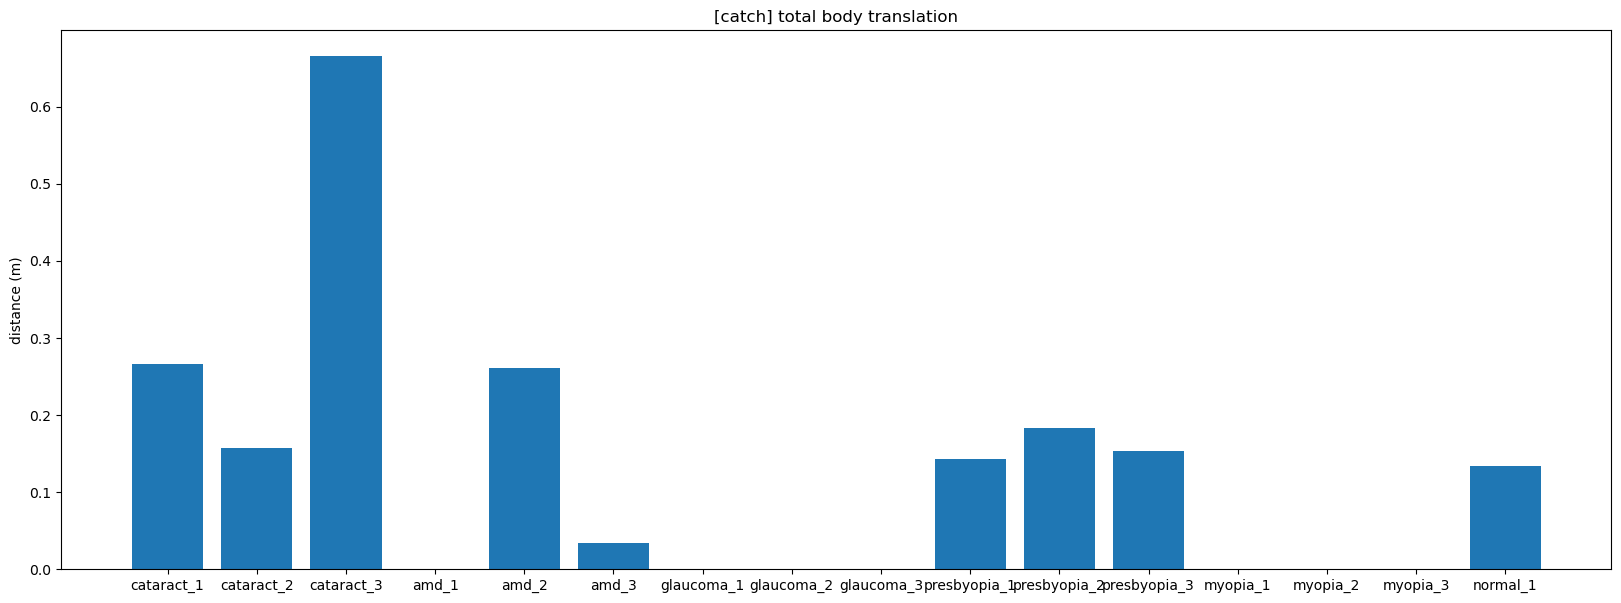

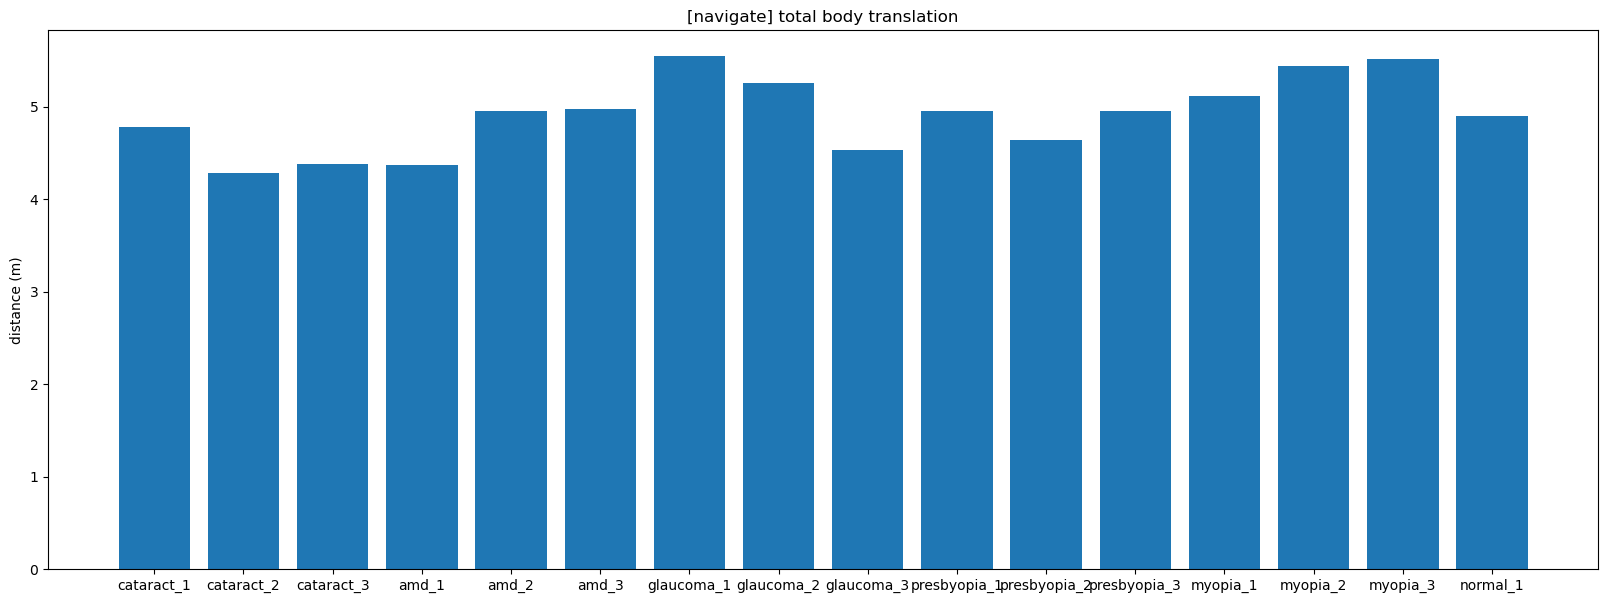

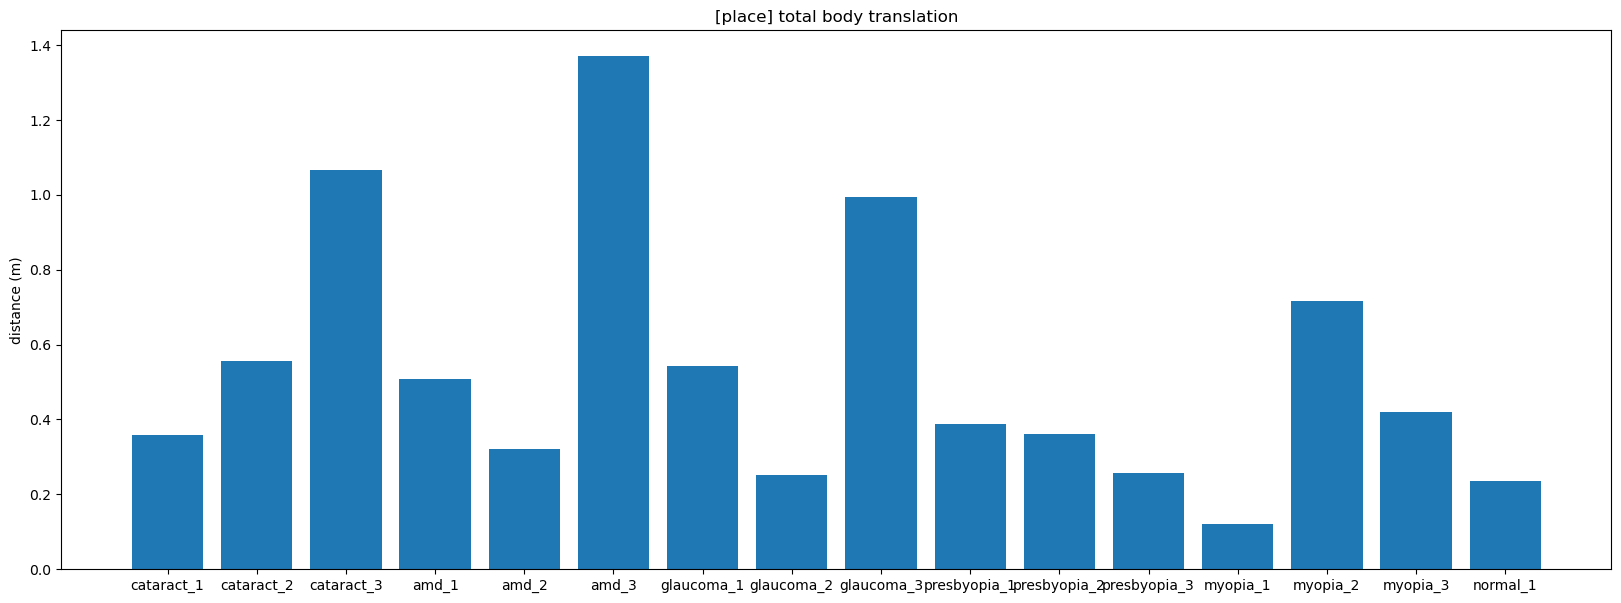

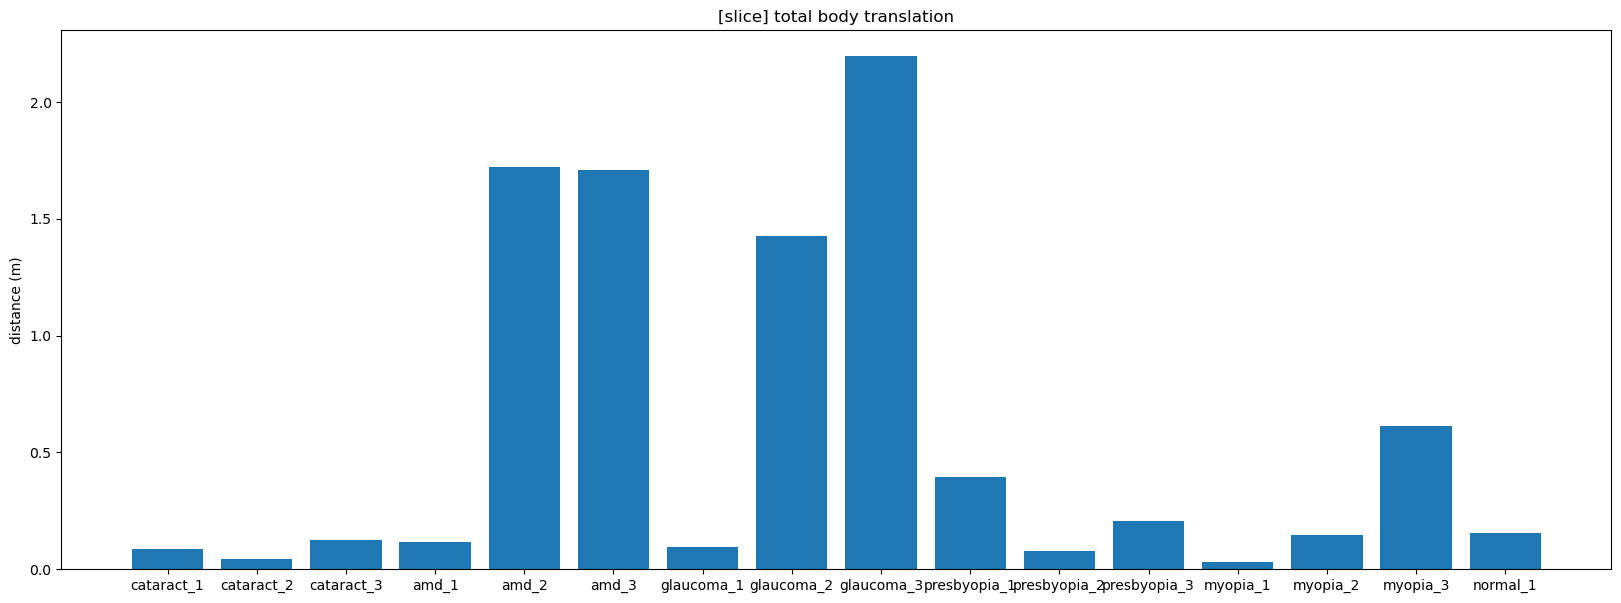

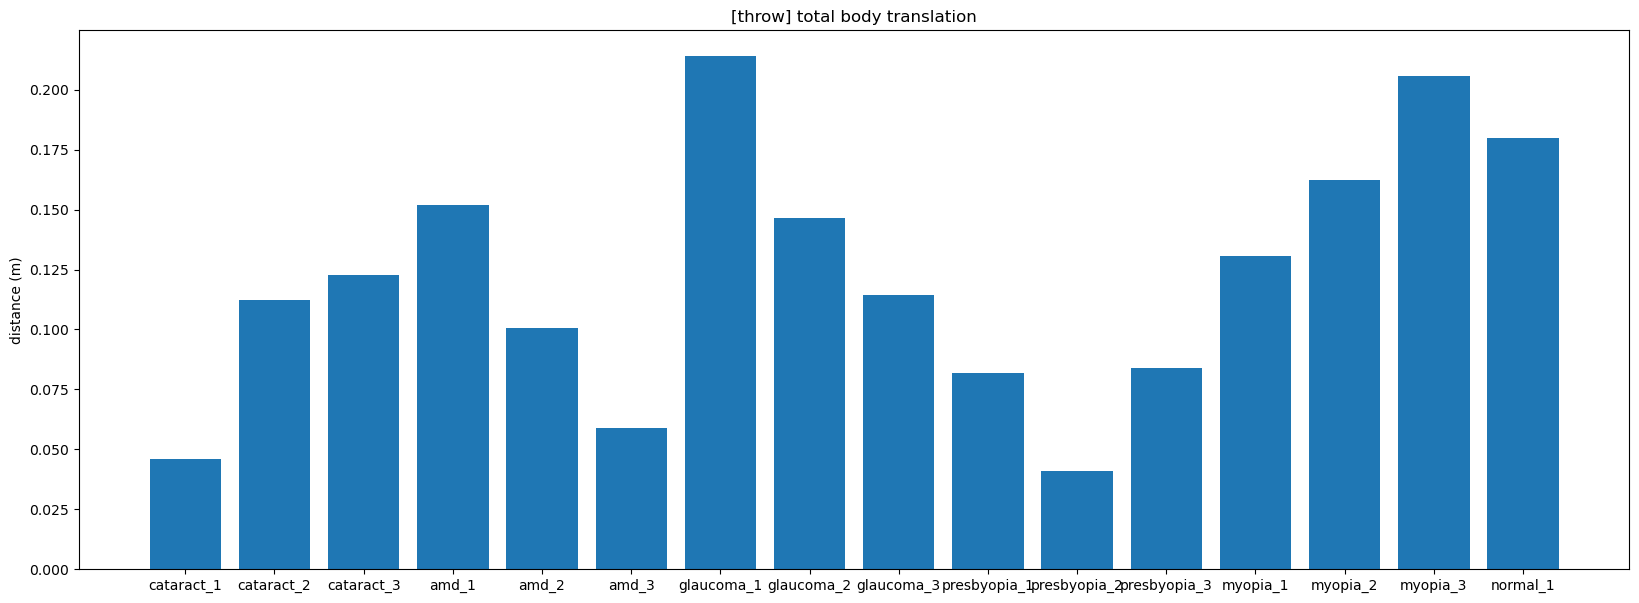

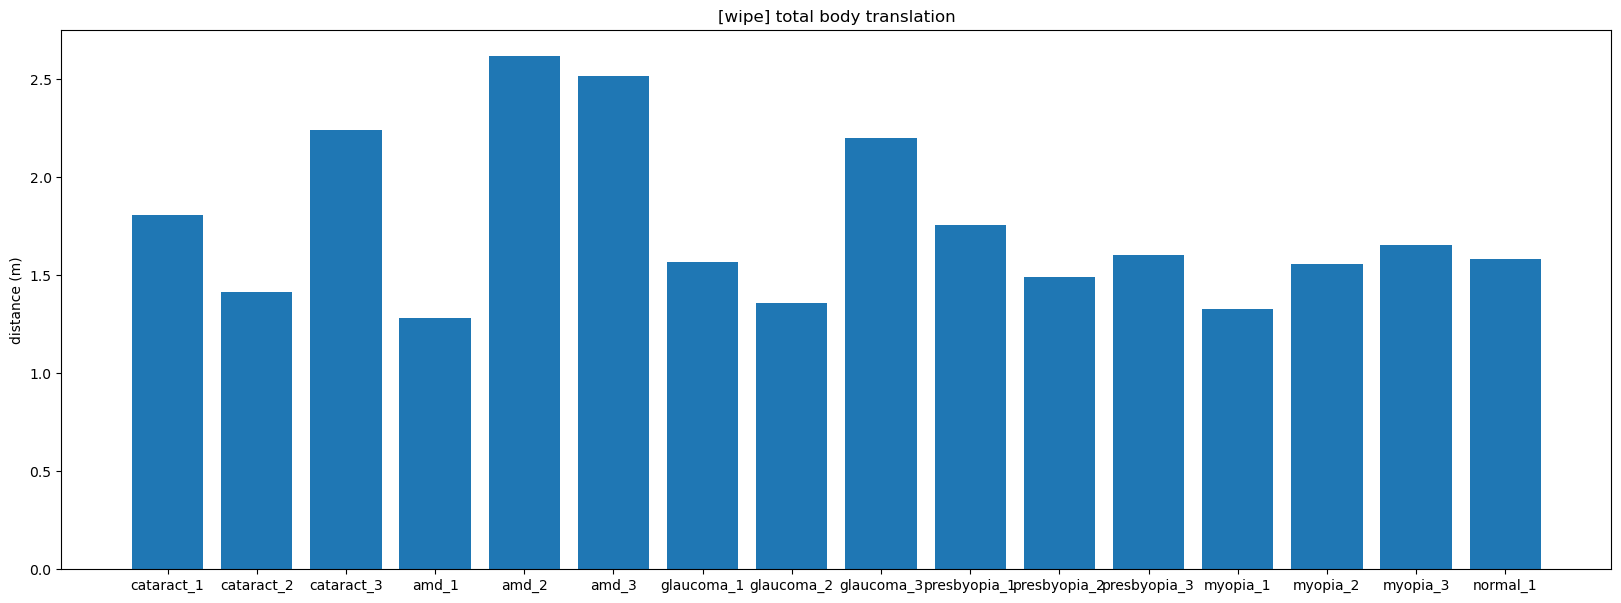

In [17]:
avg_body_translation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_body_translation_data[task][vi] = []
        for id in ids:
            avg_body_translation_data[task][vi].append(np.mean(list(body_translation_data[f"{task}_{vi}"][id].values())))
        avg_body_translation_data[task][vi] = np.mean(avg_body_translation_data[task][vi])
    vi_data.bar_plot(data=list(avg_body_translation_data[task].values()), tick_label=vis, title=f"[{task}] total body translation", ylabel="distance (m)")

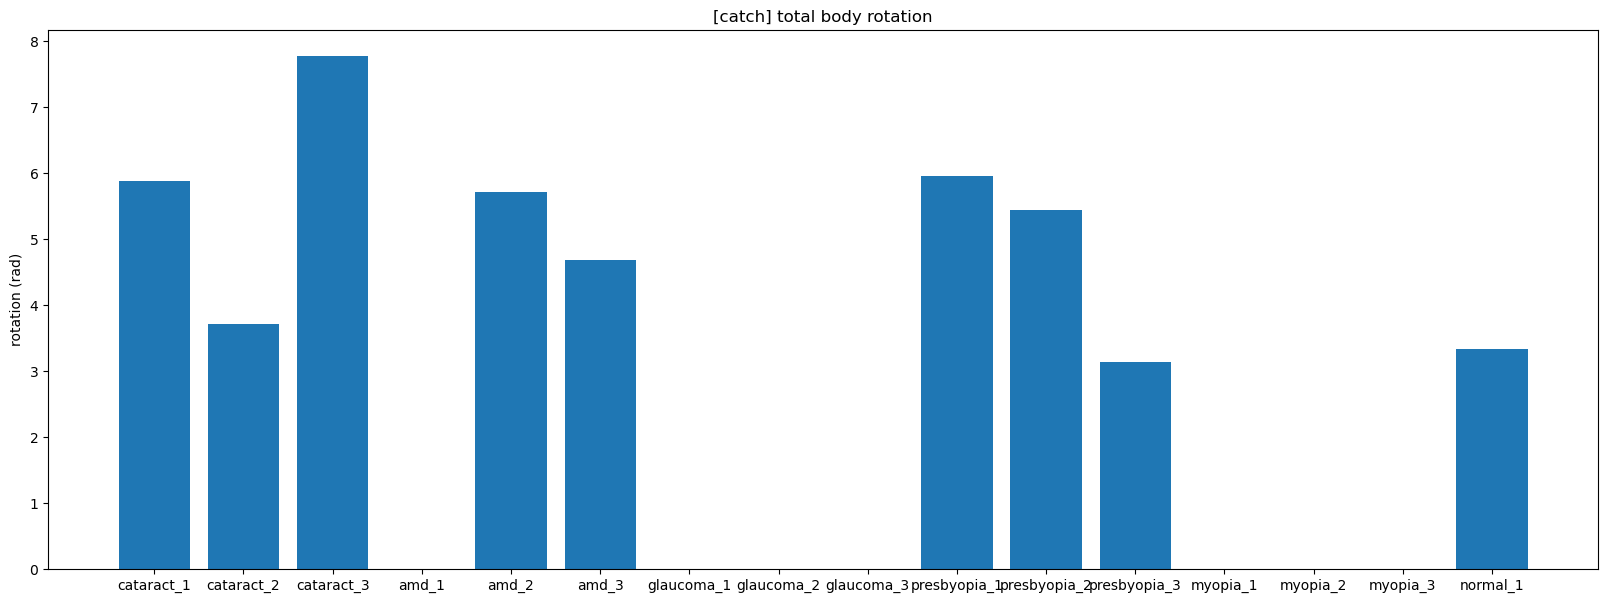

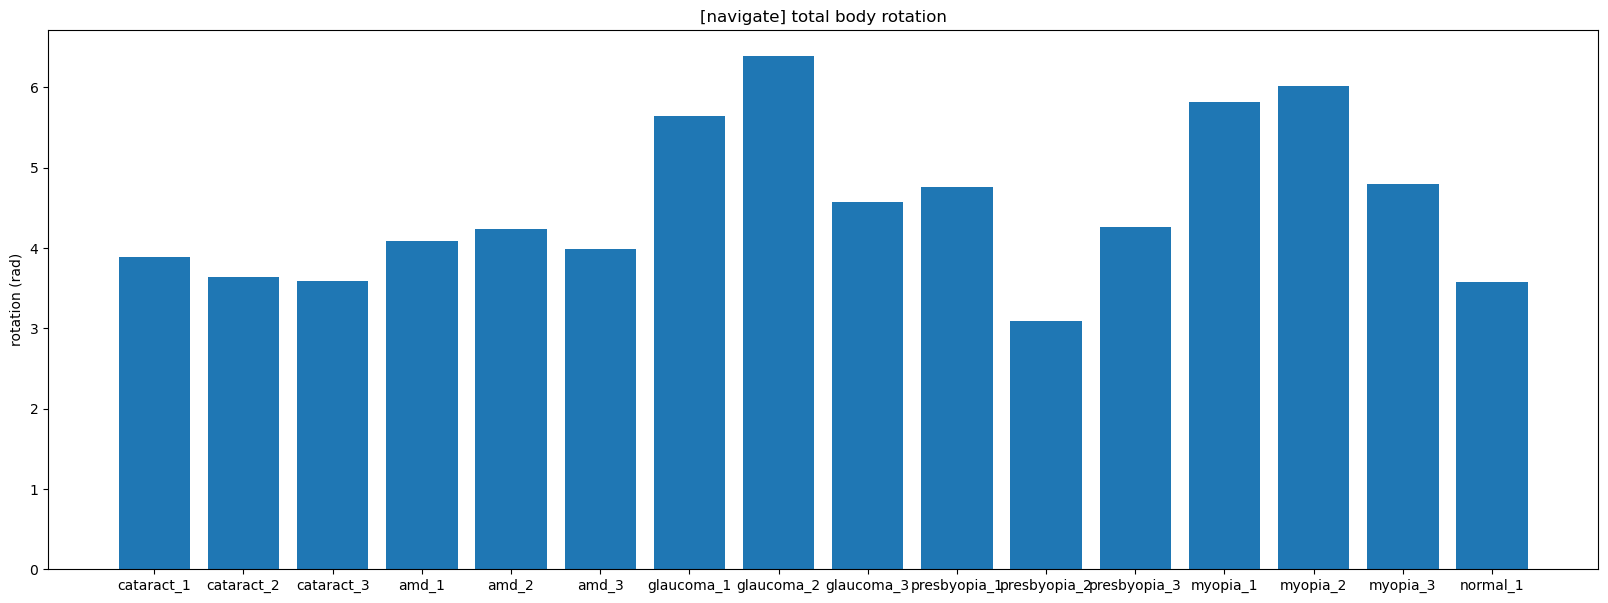

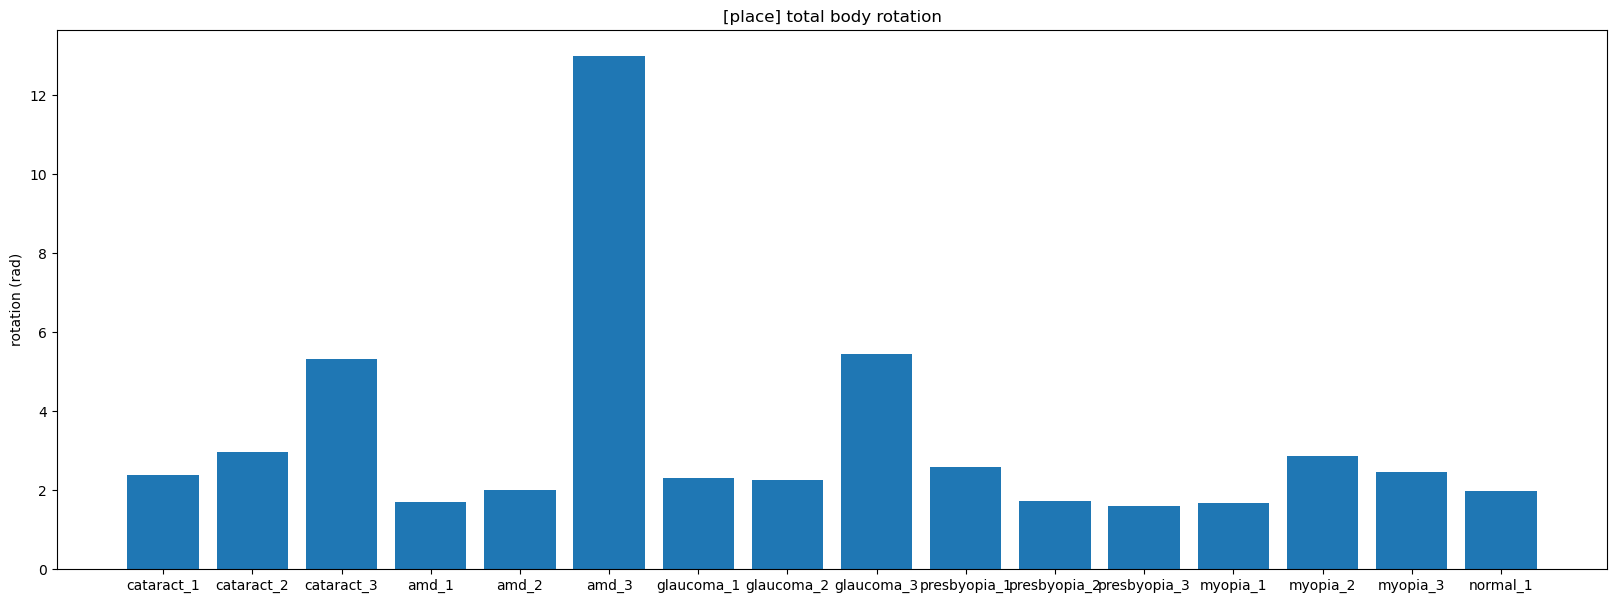

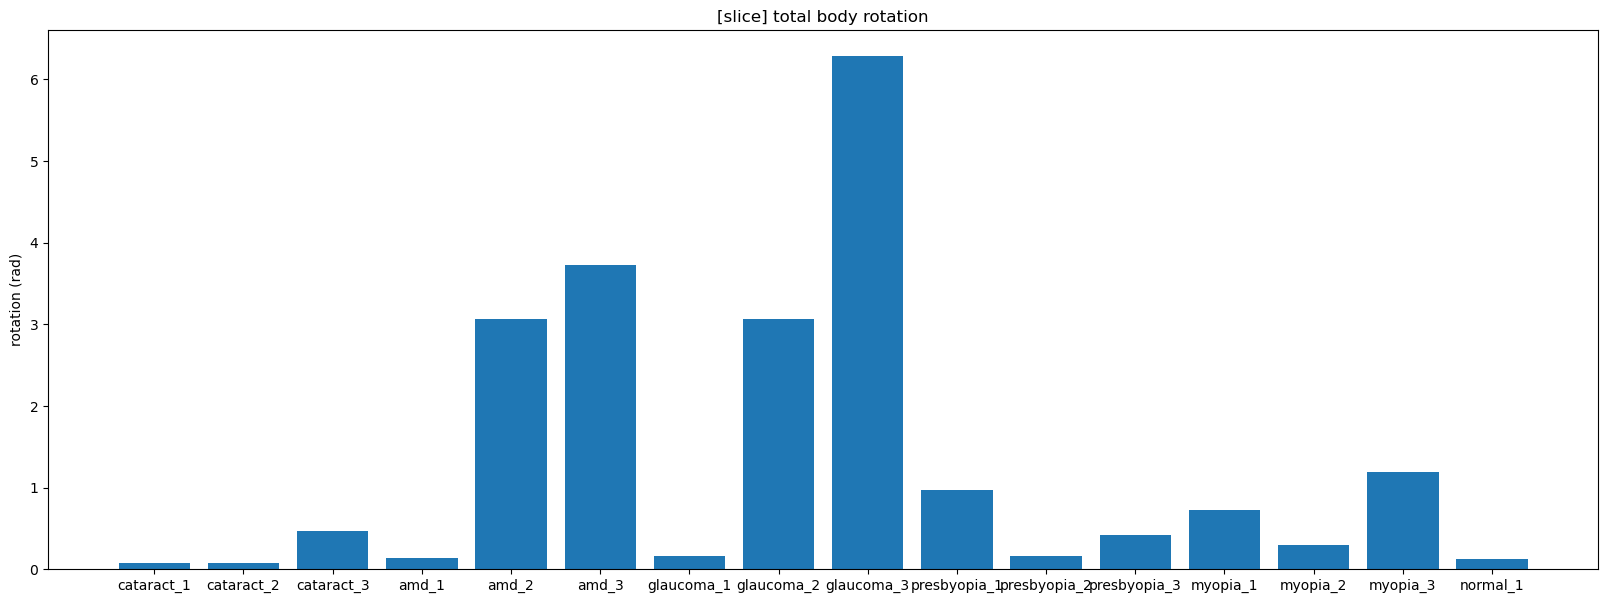

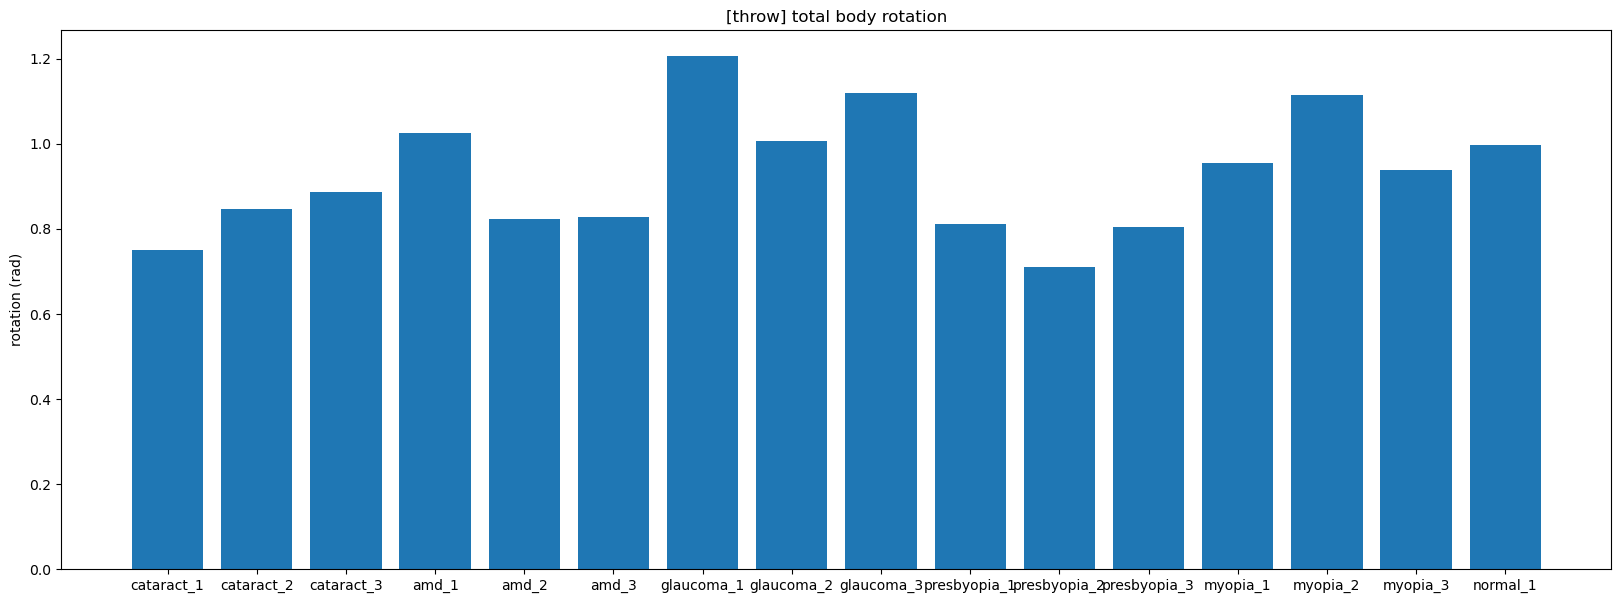

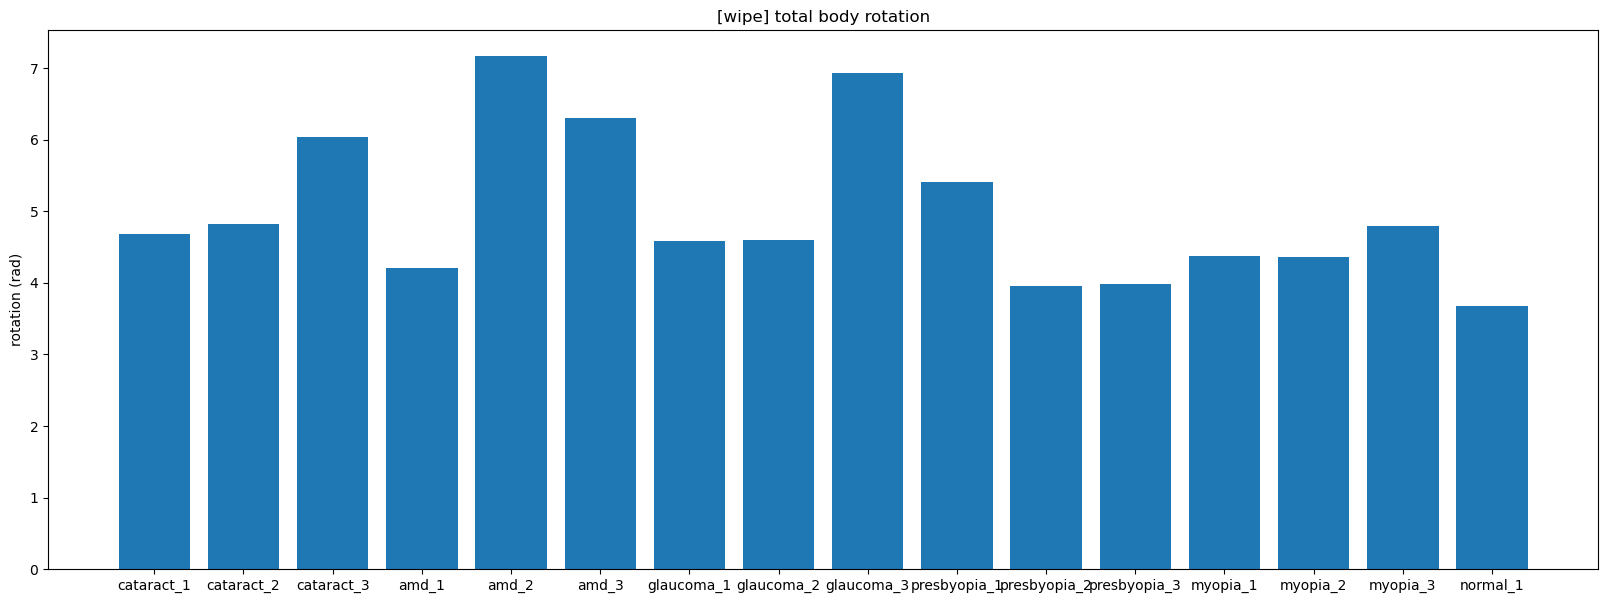

In [18]:
avg_body_rotation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_body_rotation_data[task][vi] = []
        for id in ids:
            avg_body_rotation_data[task][vi].append(np.mean(list(body_rotation_data[f"{task}_{vi}"][id].values())))
        avg_body_rotation_data[task][vi] = np.mean(avg_body_rotation_data[task][vi])
    vi_data.bar_plot(data=list(avg_body_rotation_data[task].values()), tick_label=vis, title=f"[{task}] total body rotation", ylabel="rotation (rad)")

### Left Hand Movements

In [19]:
lh_translation_data = vi_data.get_device_translation(device="left_controller", method=np.sum)
lh_rotation_data = vi_data.get_device_rotation(device="left_controller", method=np.sum)

if save_json:
    with open(f"{data_path}/json/dv2/total_left_hand_translation.json", "w") as f:
        json.dump(lh_translation_data, f)
    with open(f"{data_path}/json/dv2/total_left_hand_rotation.json", "w") as f:
        json.dump(lh_rotation_data, f)

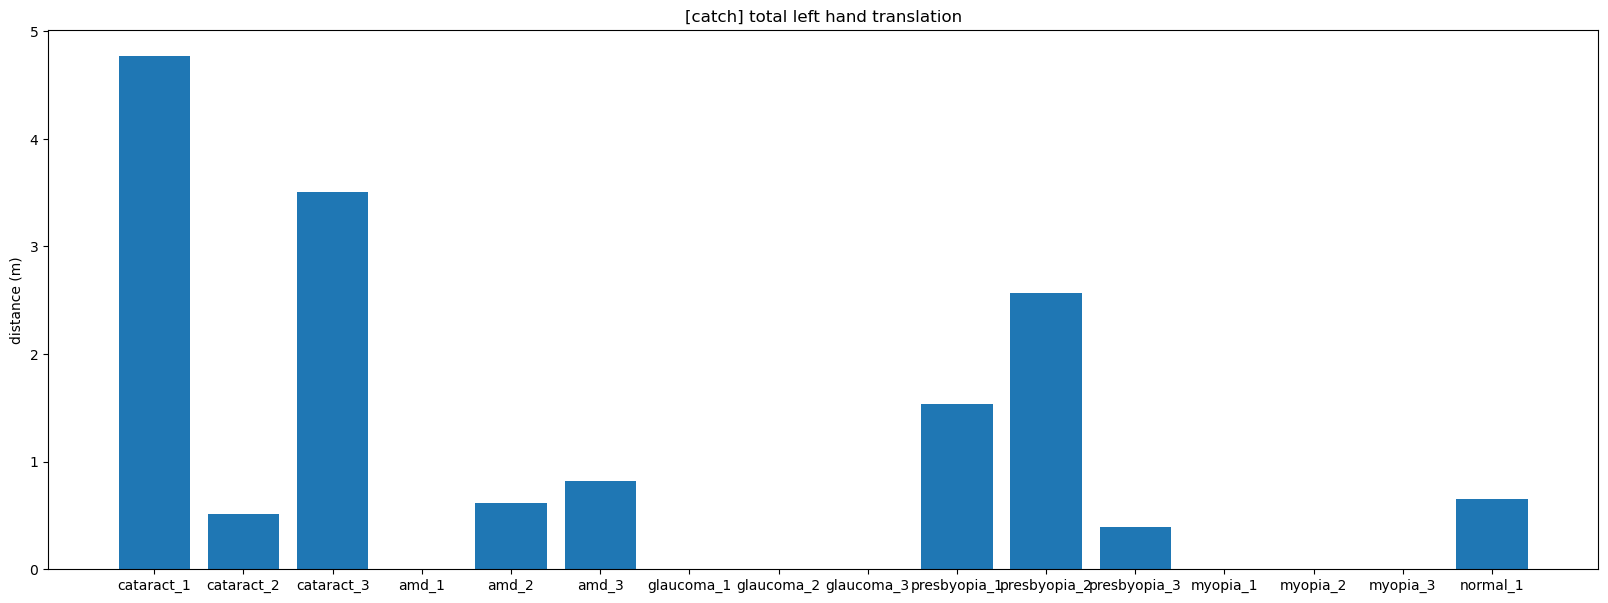

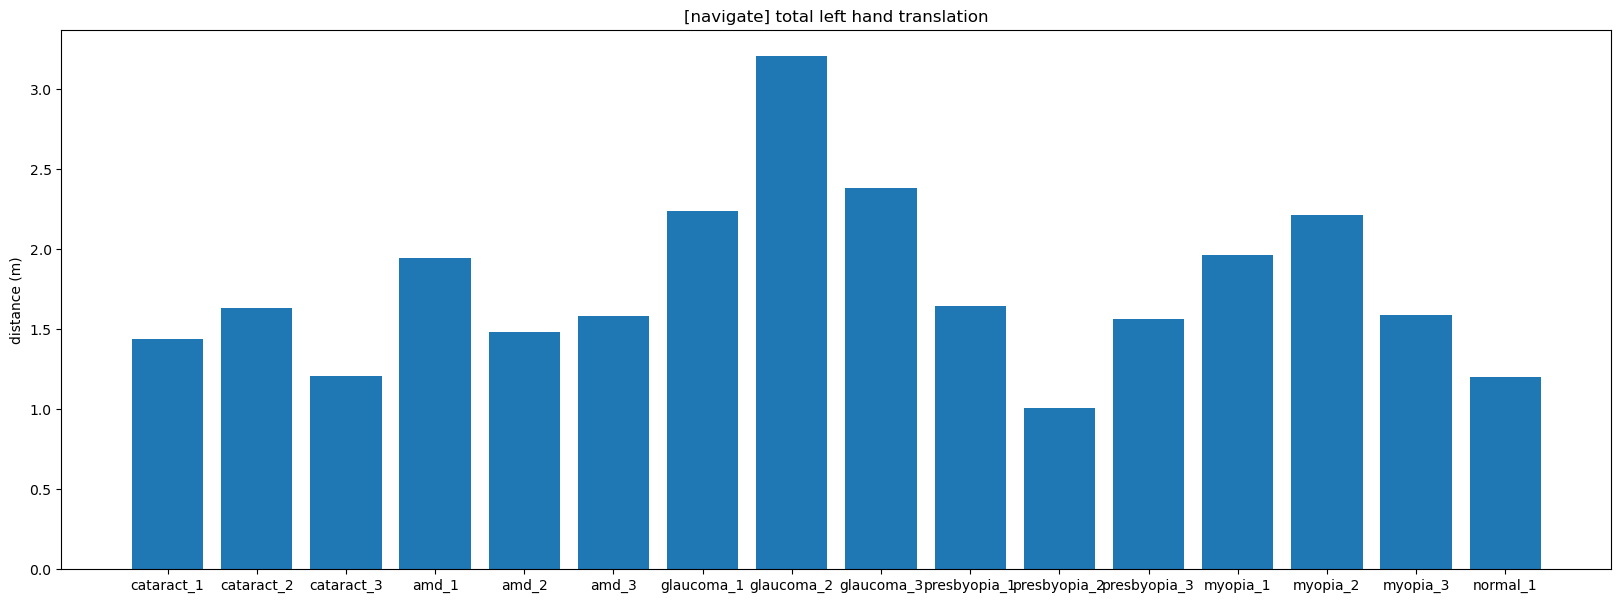

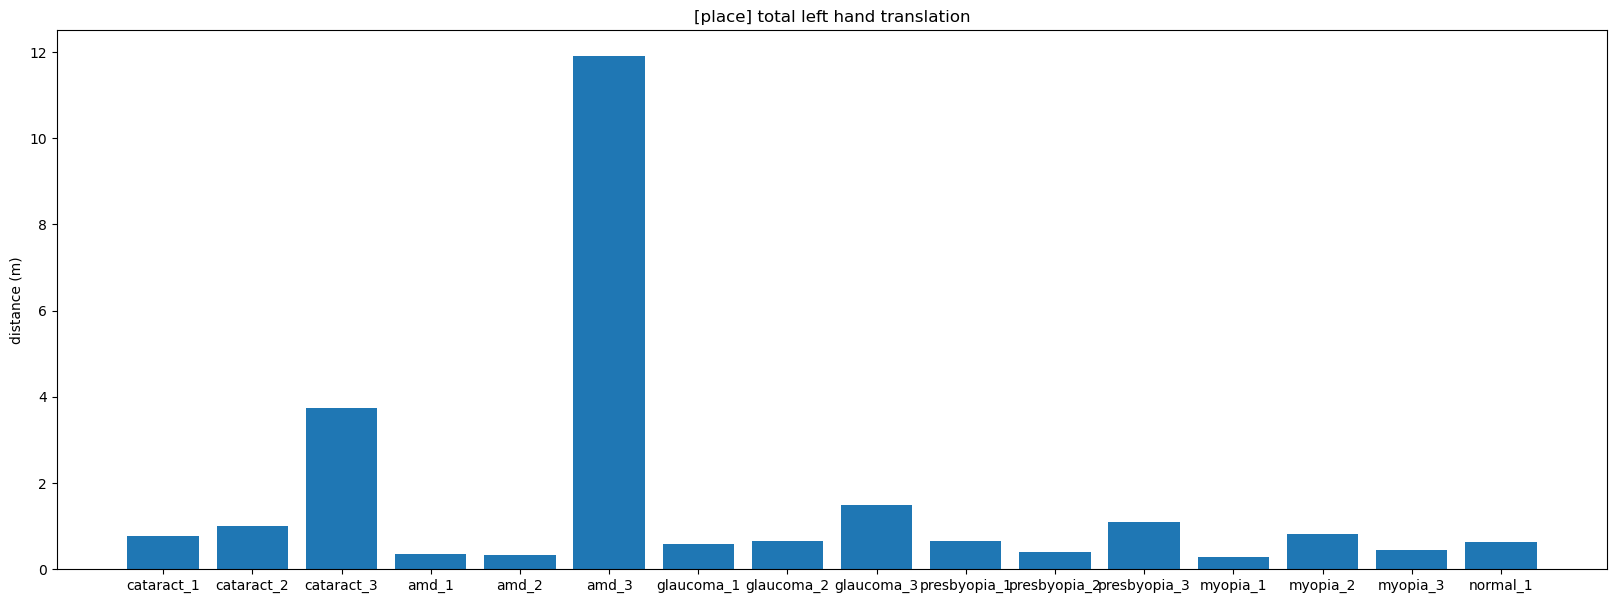

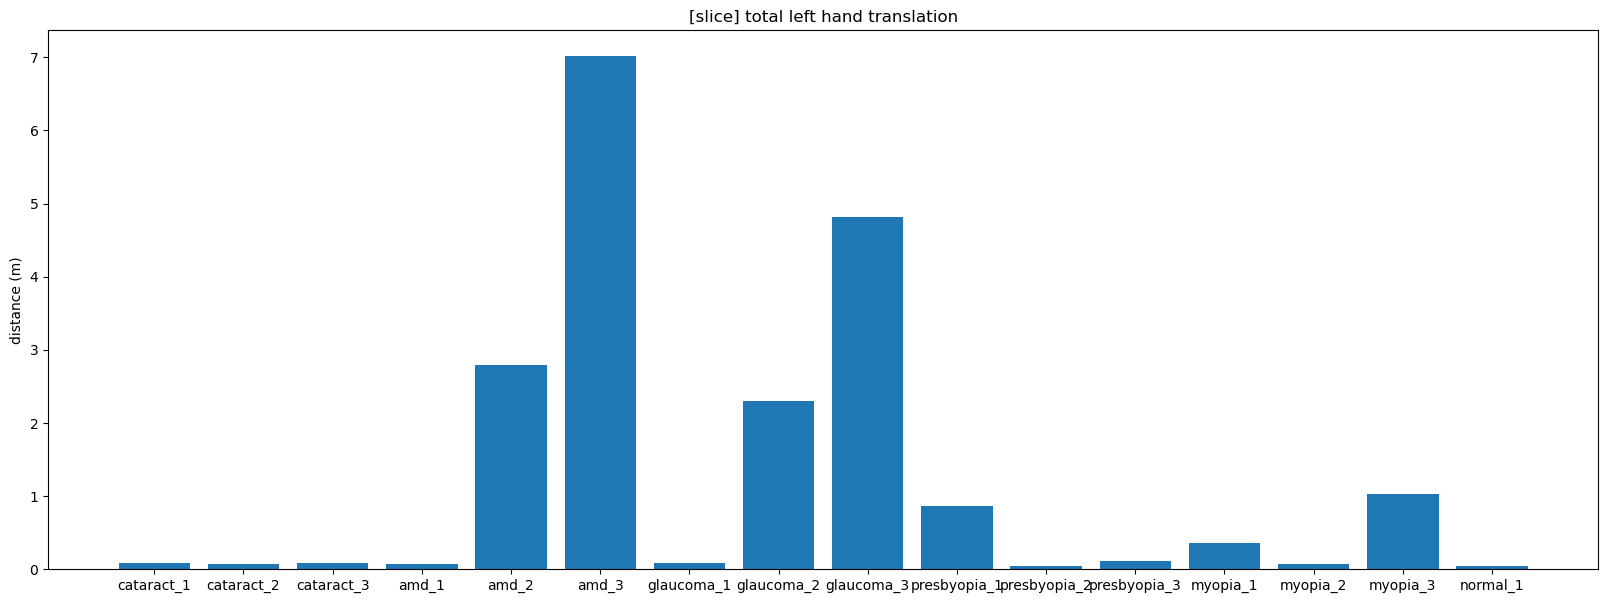

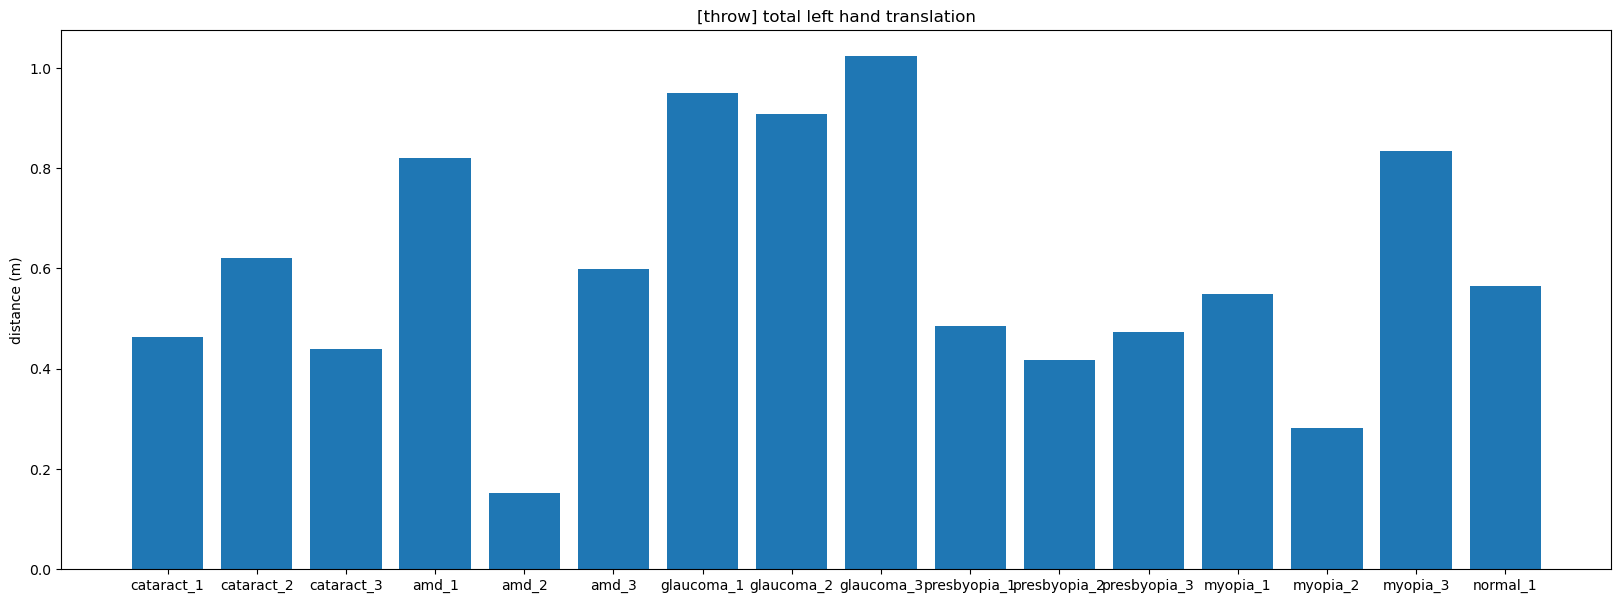

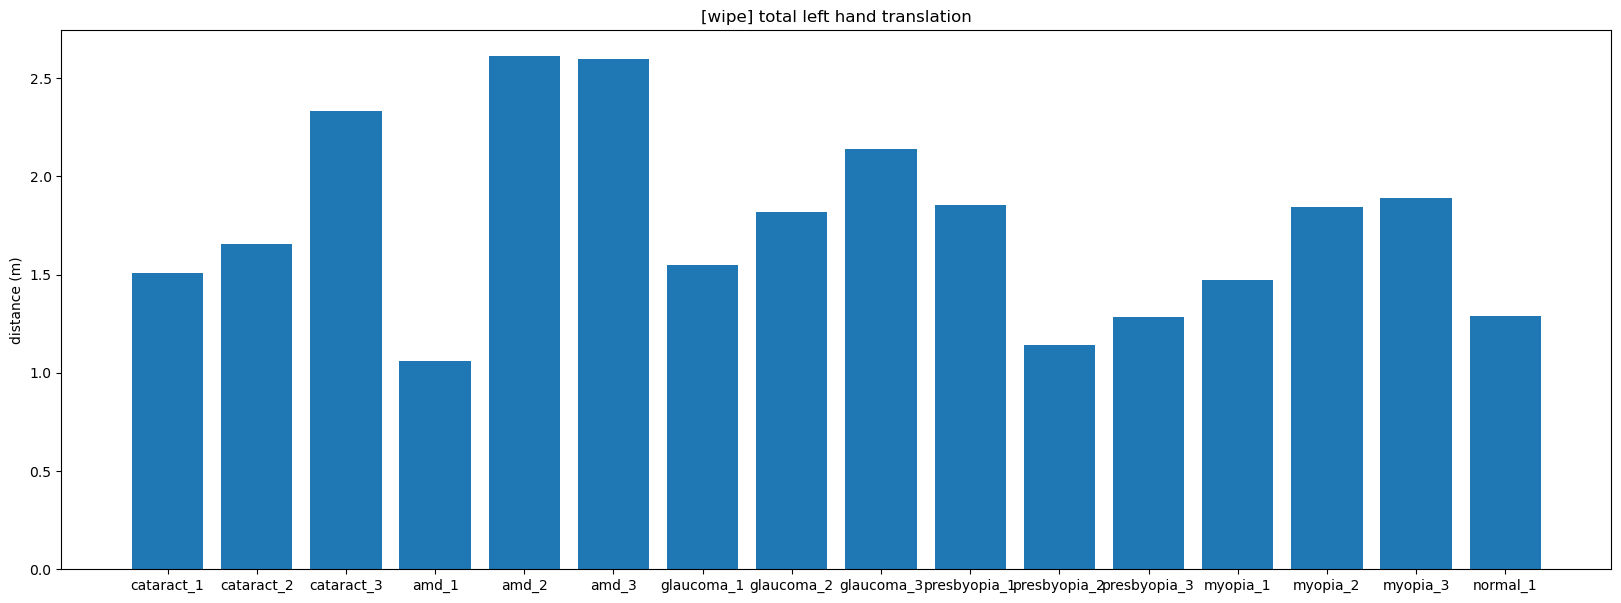

In [20]:
avg_lh_translation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_lh_translation_data[task][vi] = []
        for id in ids:
            avg_lh_translation_data[task][vi].append(np.mean(list(lh_translation_data[f"{task}_{vi}"][id].values())))
        avg_lh_translation_data[task][vi] = np.mean(avg_lh_translation_data[task][vi])
    vi_data.bar_plot(data=list(avg_lh_translation_data[task].values()), tick_label=vis, title=f"[{task}] total left hand translation", ylabel="distance (m)")

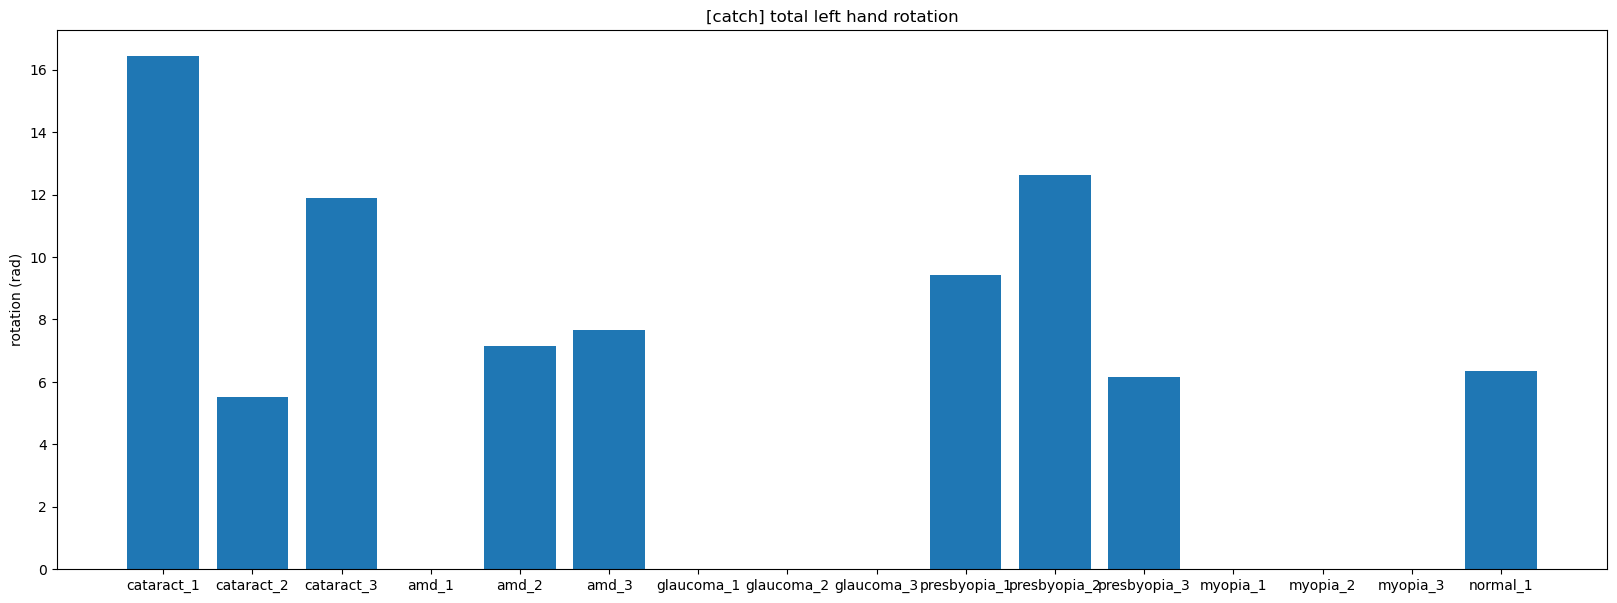

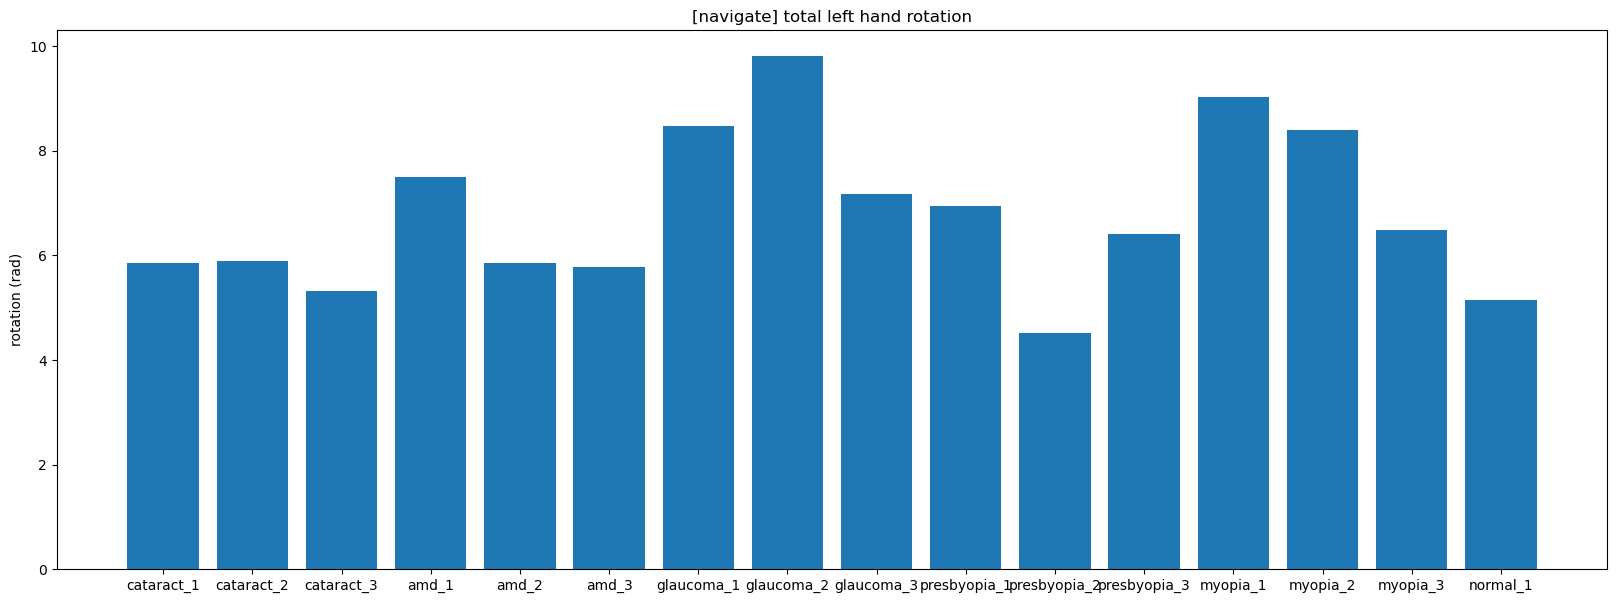

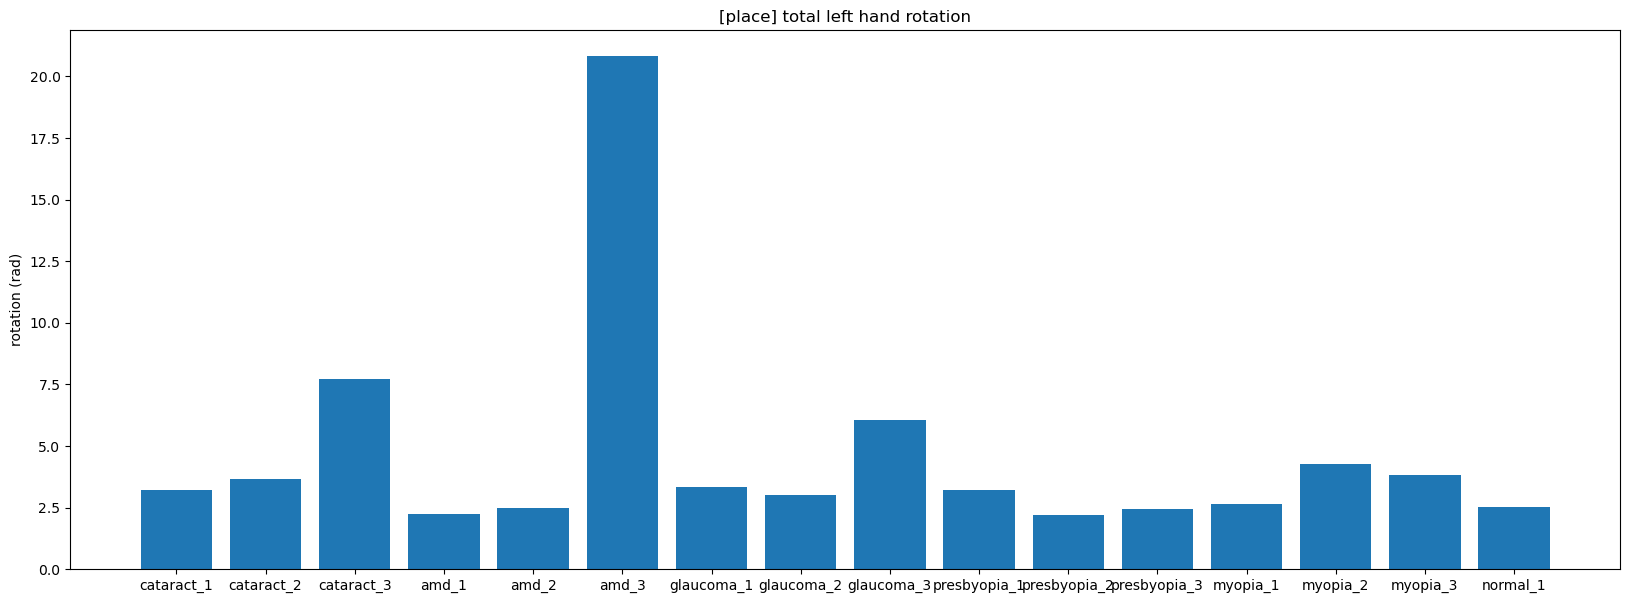

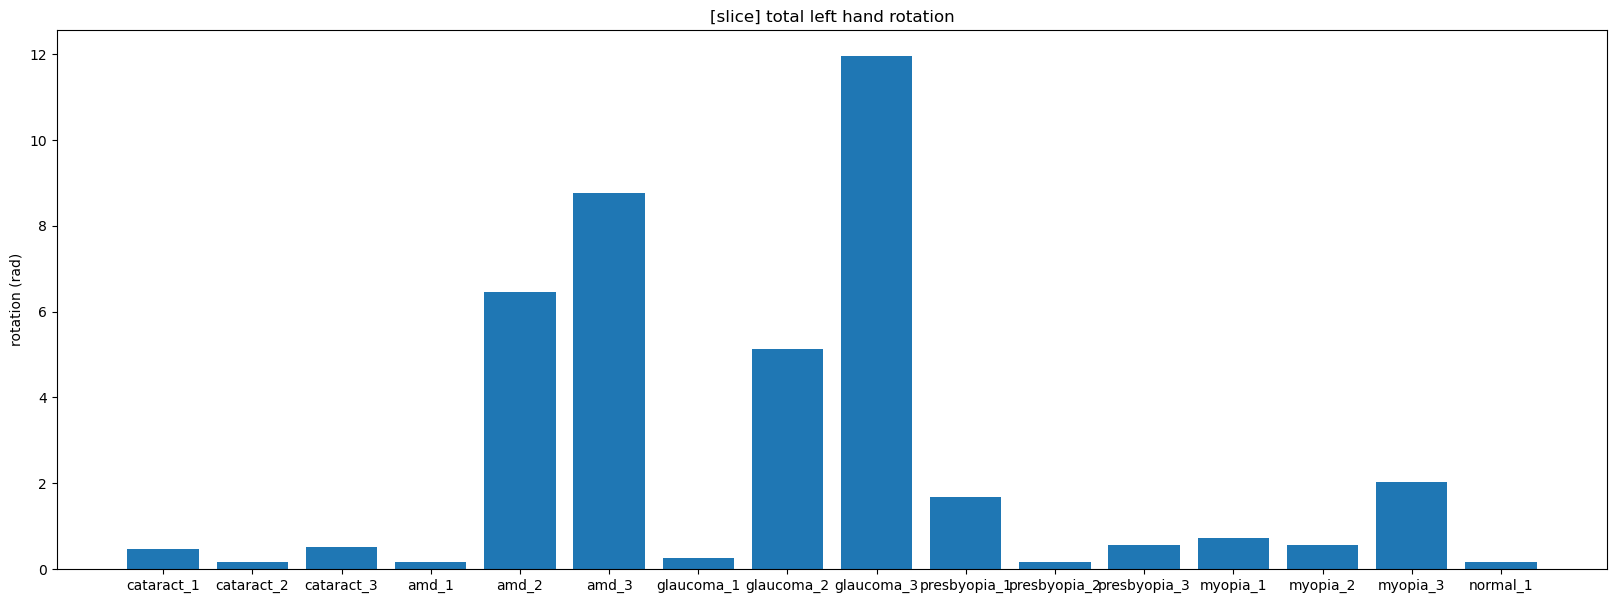

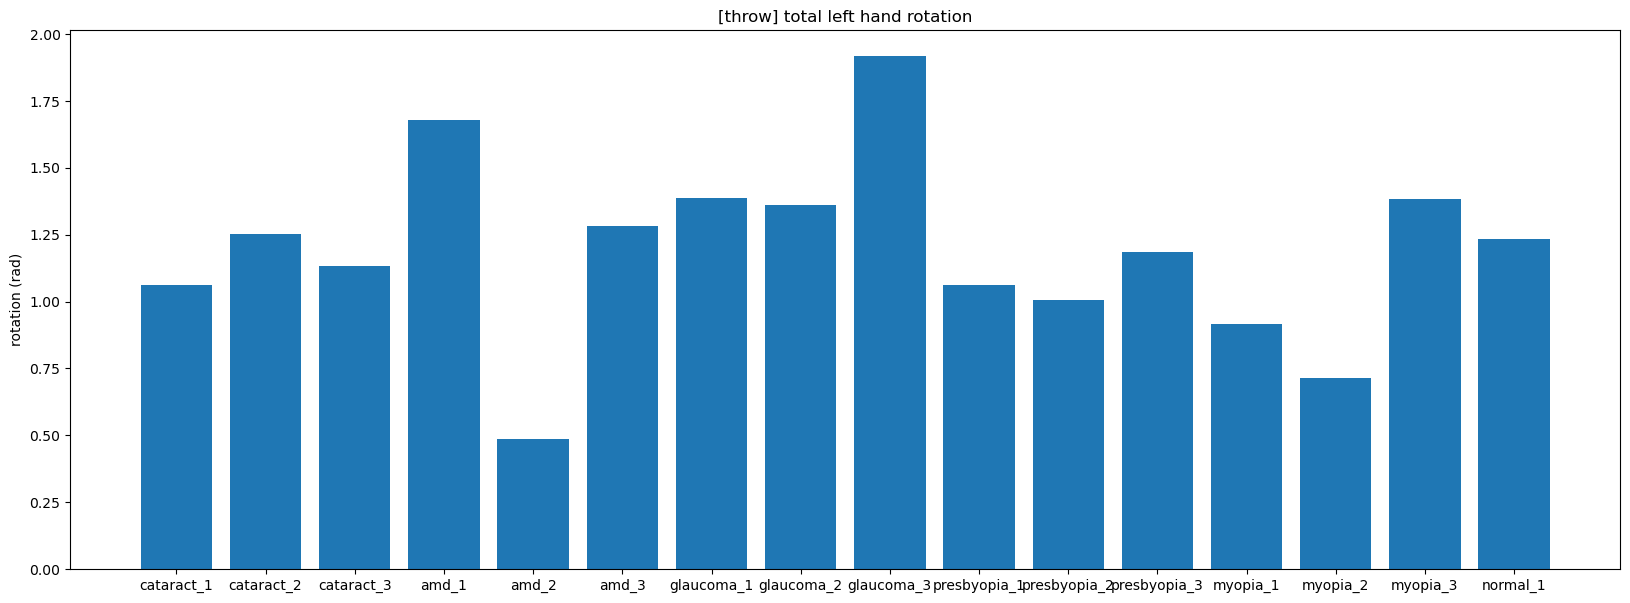

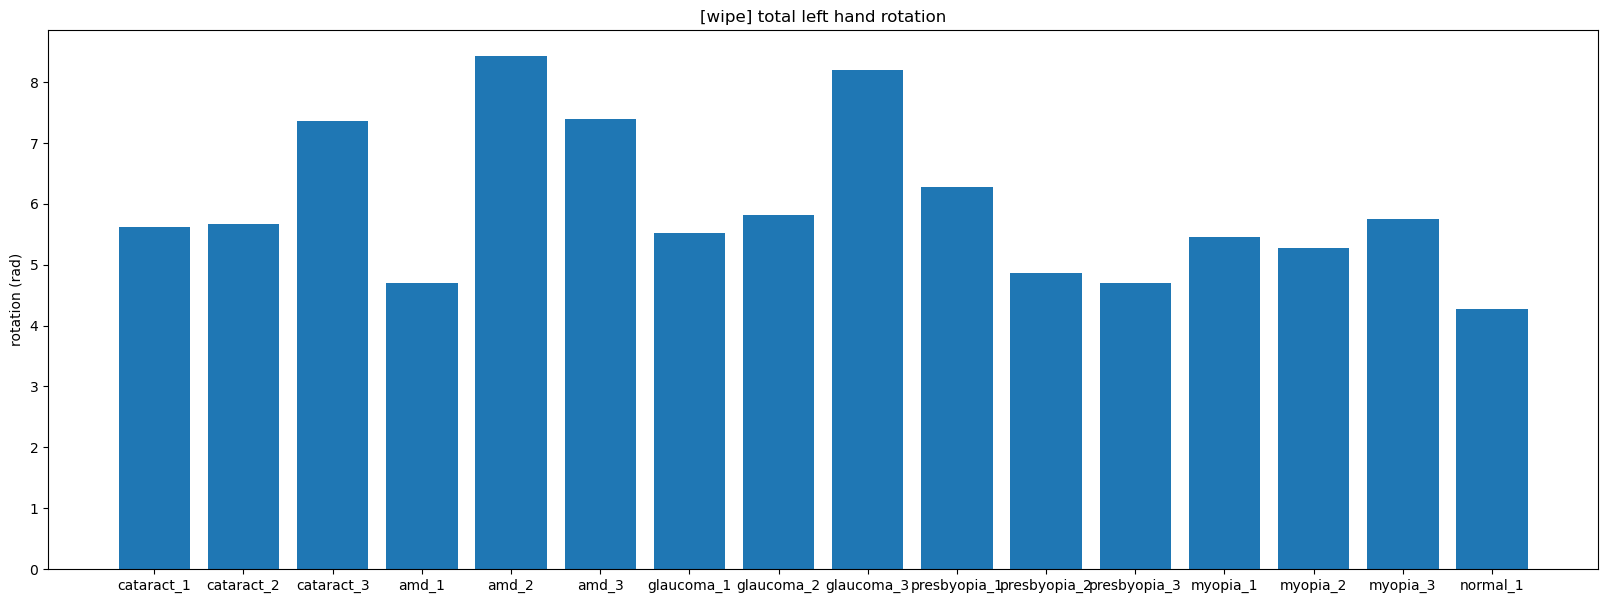

In [21]:
avg_lh_rotation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_lh_rotation_data[task][vi] = []
        for id in ids:
            avg_lh_rotation_data[task][vi].append(np.mean(list(lh_rotation_data[f"{task}_{vi}"][id].values())))
        avg_lh_rotation_data[task][vi] = np.mean(avg_lh_rotation_data[task][vi])
    vi_data.bar_plot(data=list(avg_lh_rotation_data[task].values()), tick_label=vis, title=f"[{task}] total left hand rotation", ylabel="rotation (rad)")

### Right Hand Movements

In [22]:
rh_translation_data = vi_data.get_device_translation(device="right_controller", method=np.sum)
rh_rotation_data = vi_data.get_device_rotation(device="right_controller", method=np.sum)

if save_json:
    with open(f"{data_path}/json/dv2/total_right_hand_translation.json", "w") as f:
        json.dump(rh_translation_data, f)
    with open(f"{data_path}/json/dv2/total_right_hand_rotation.json", "w") as f:
        json.dump(rh_rotation_data, f)

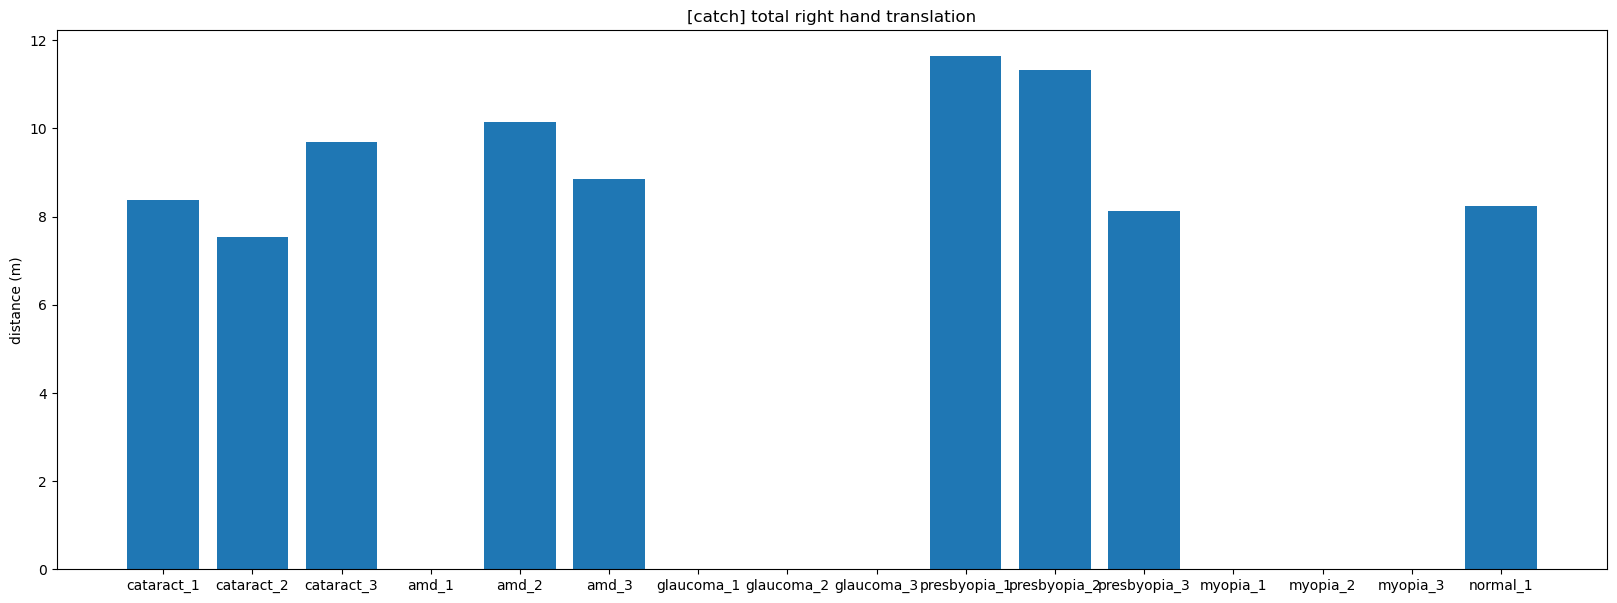

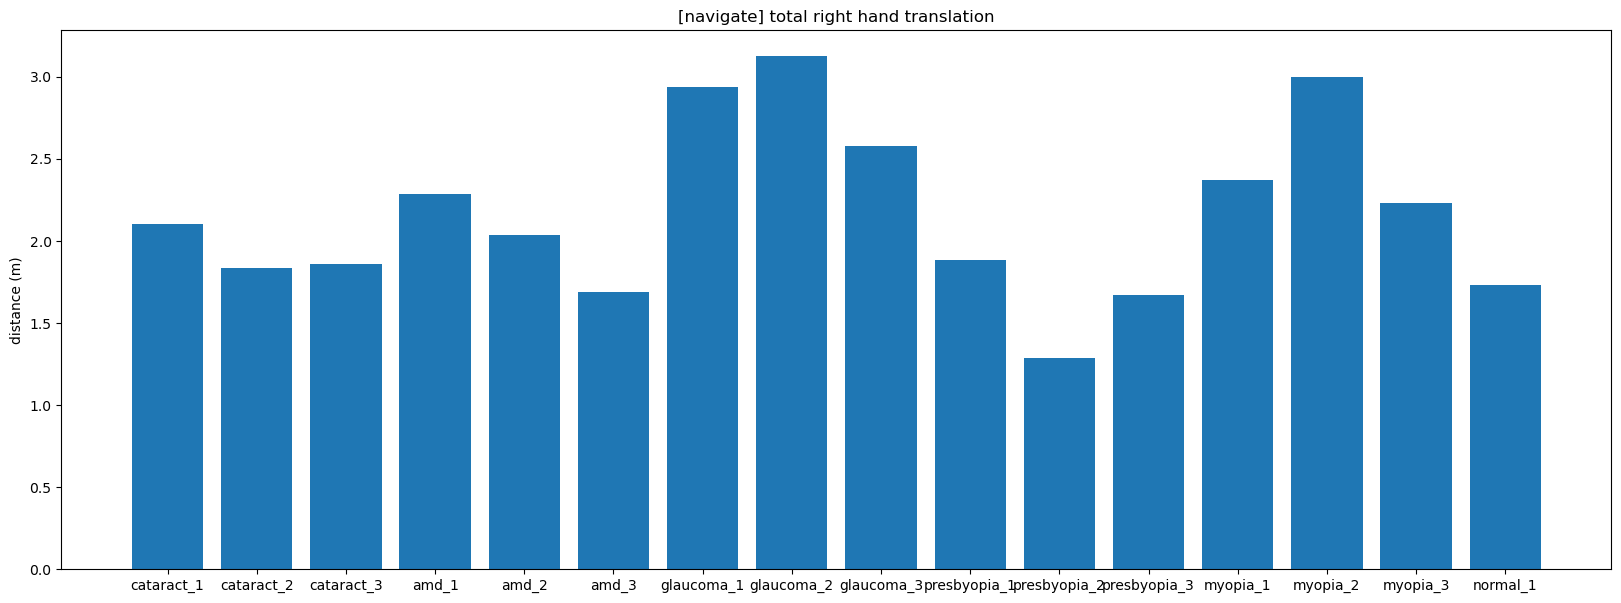

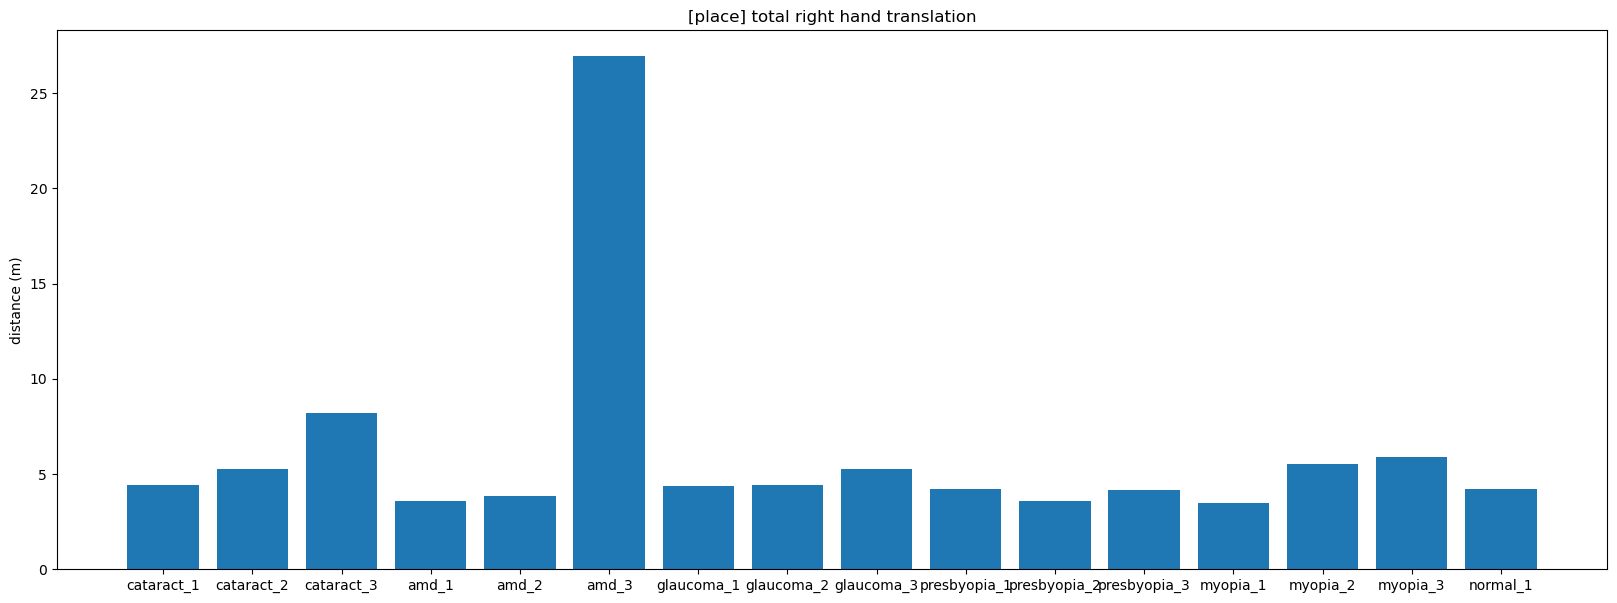

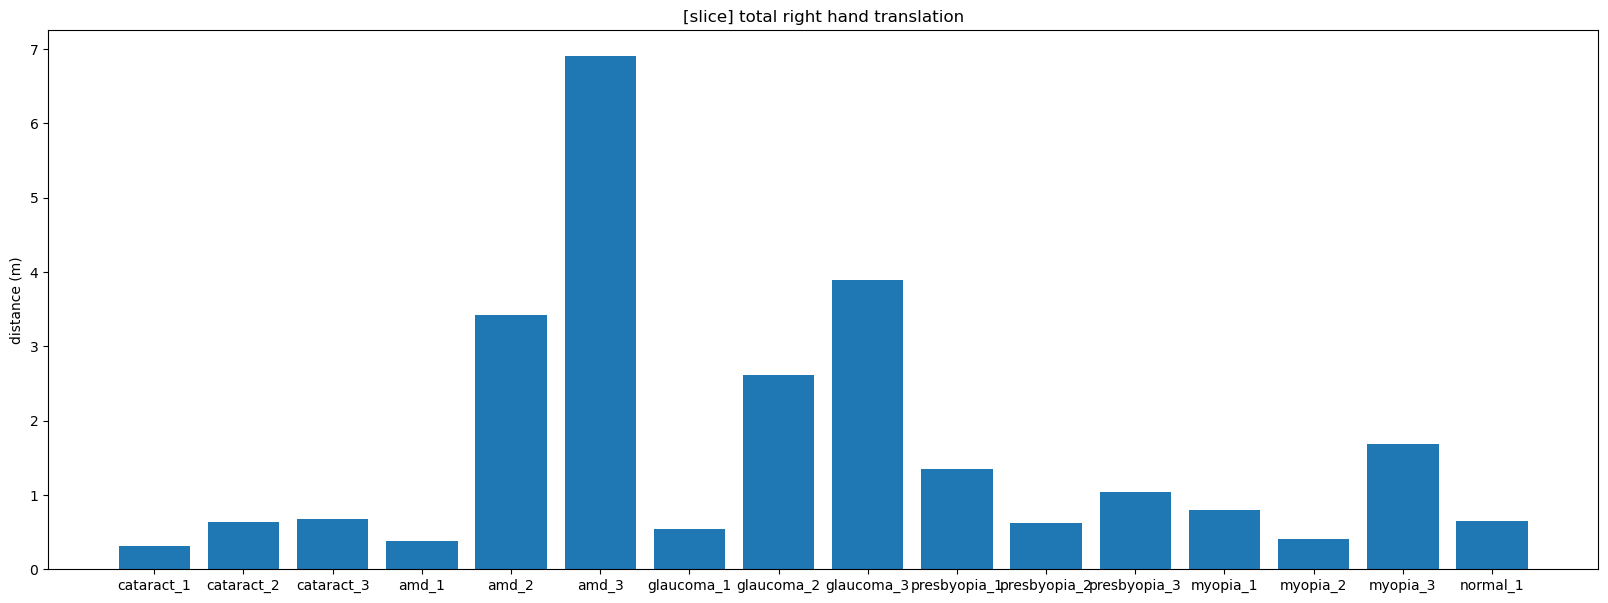

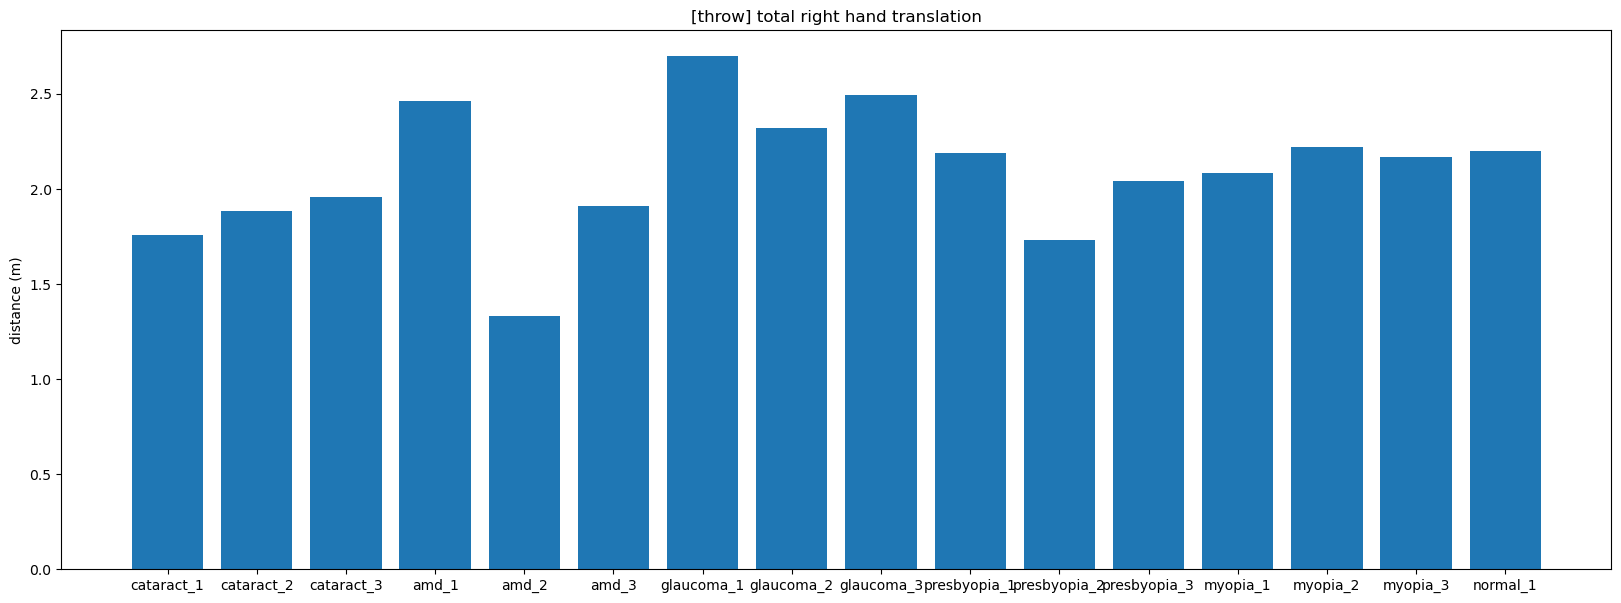

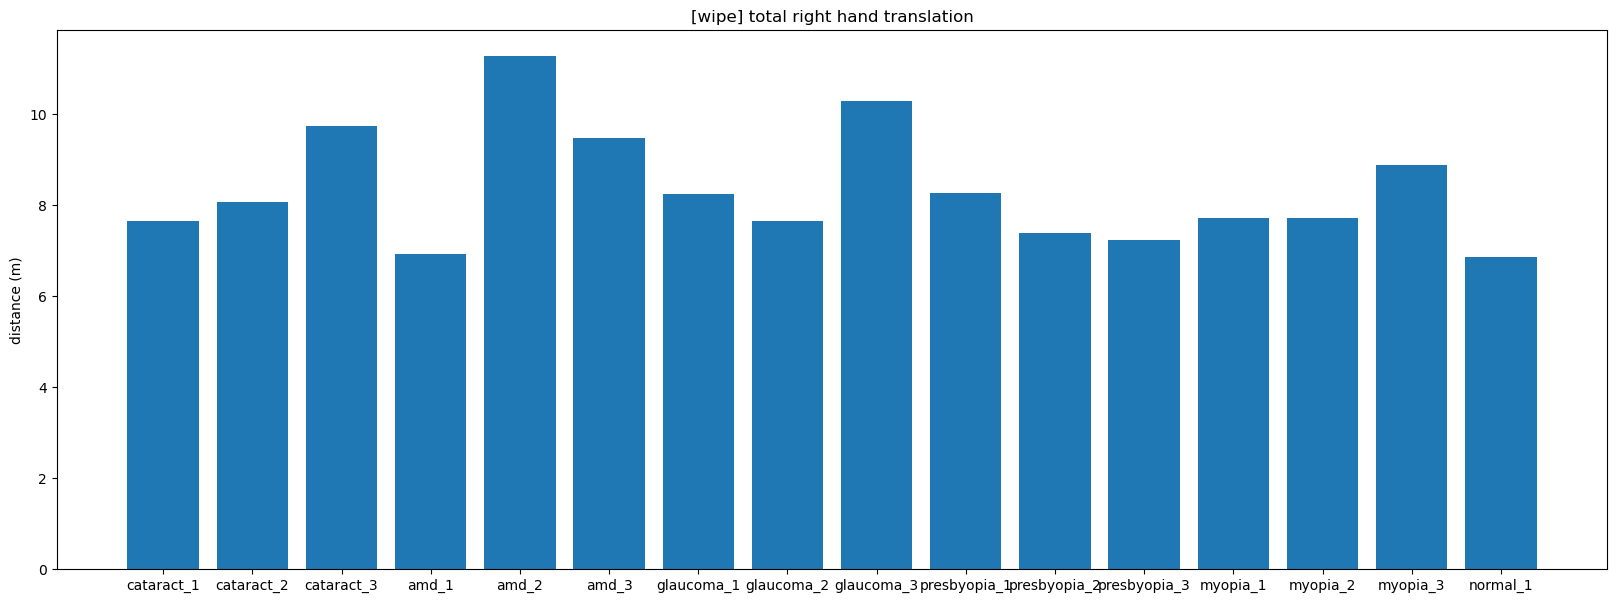

In [23]:
avg_rh_translation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_rh_translation_data[task][vi] = []
        for id in ids:
            avg_rh_translation_data[task][vi].append(np.mean(list(rh_translation_data[f"{task}_{vi}"][id].values())))
        avg_rh_translation_data[task][vi] = np.mean(avg_rh_translation_data[task][vi])
    vi_data.bar_plot(data=list(avg_rh_translation_data[task].values()), tick_label=vis, title=f"[{task}] total right hand translation", ylabel="distance (m)")

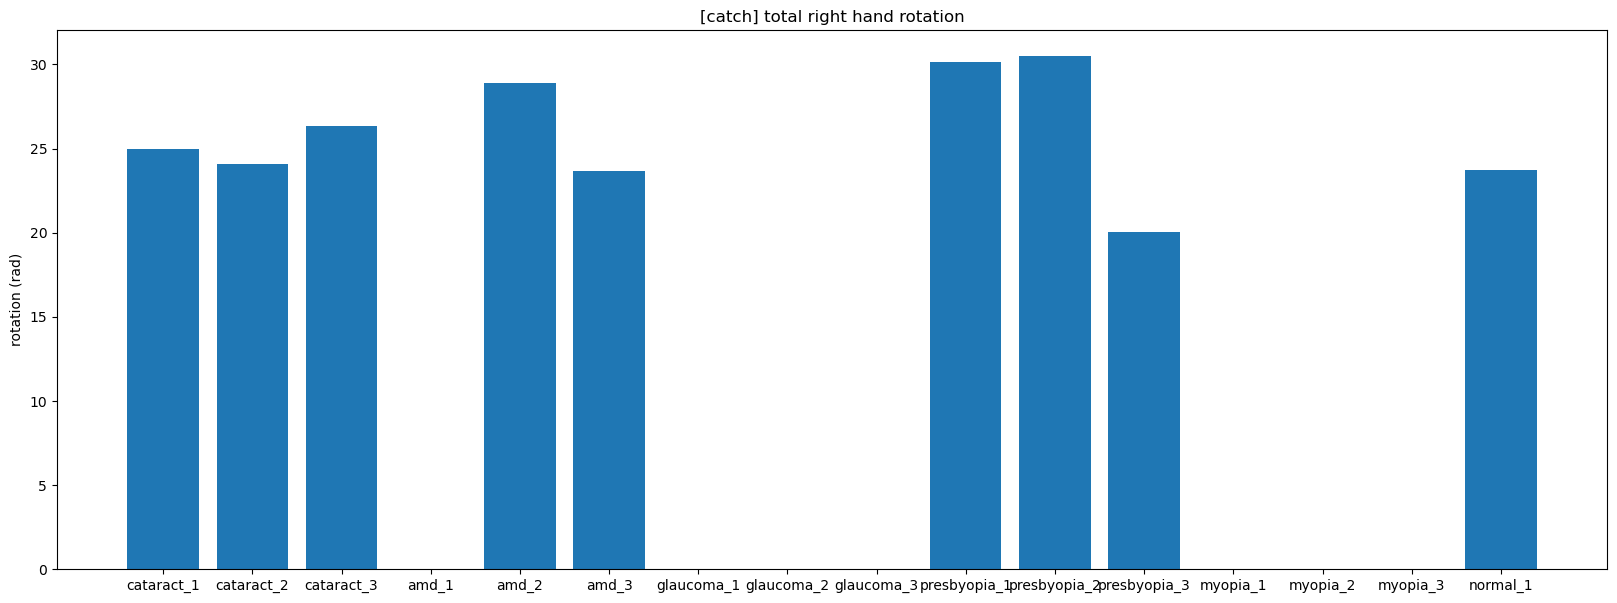

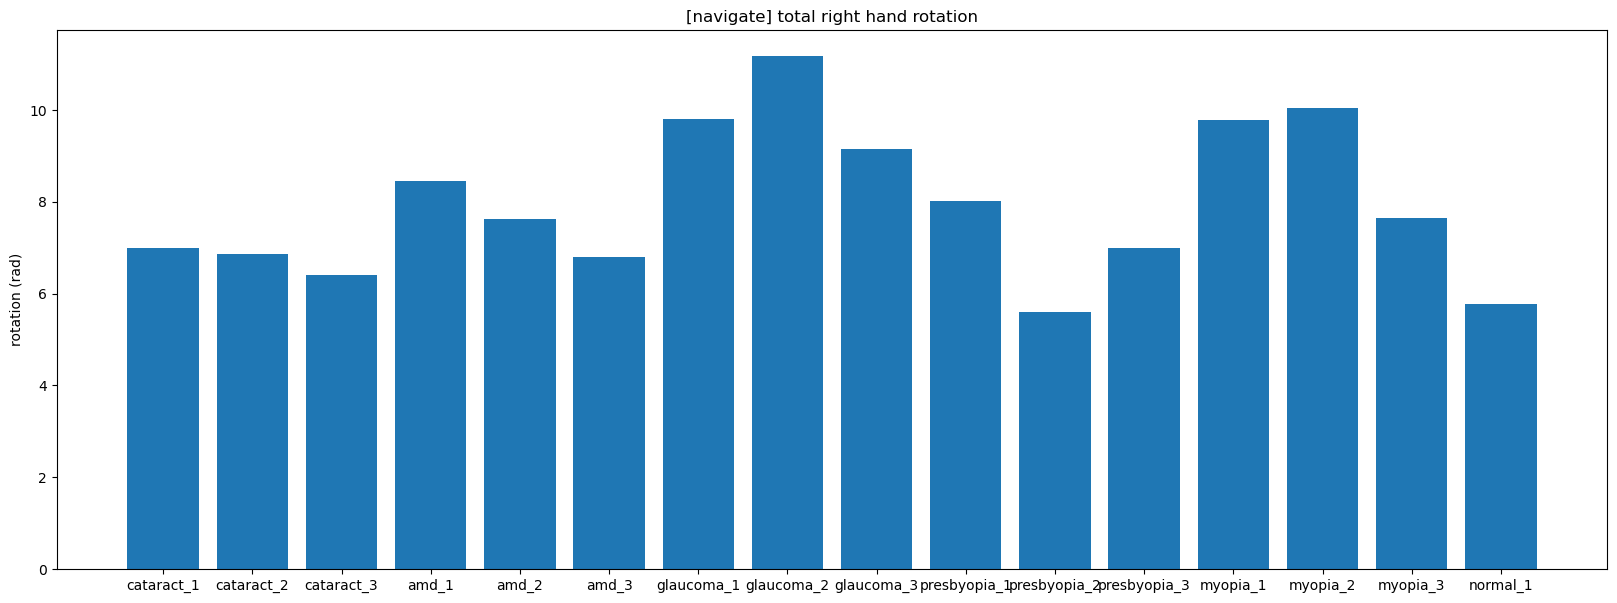

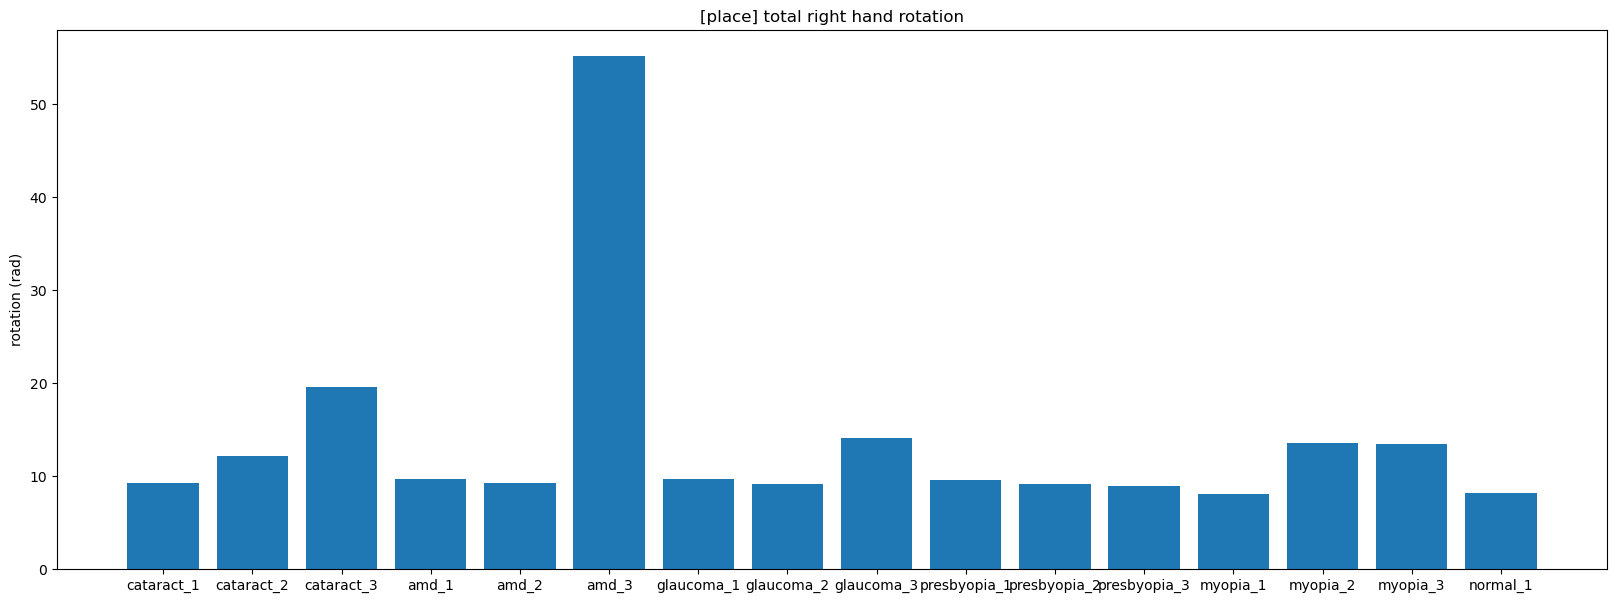

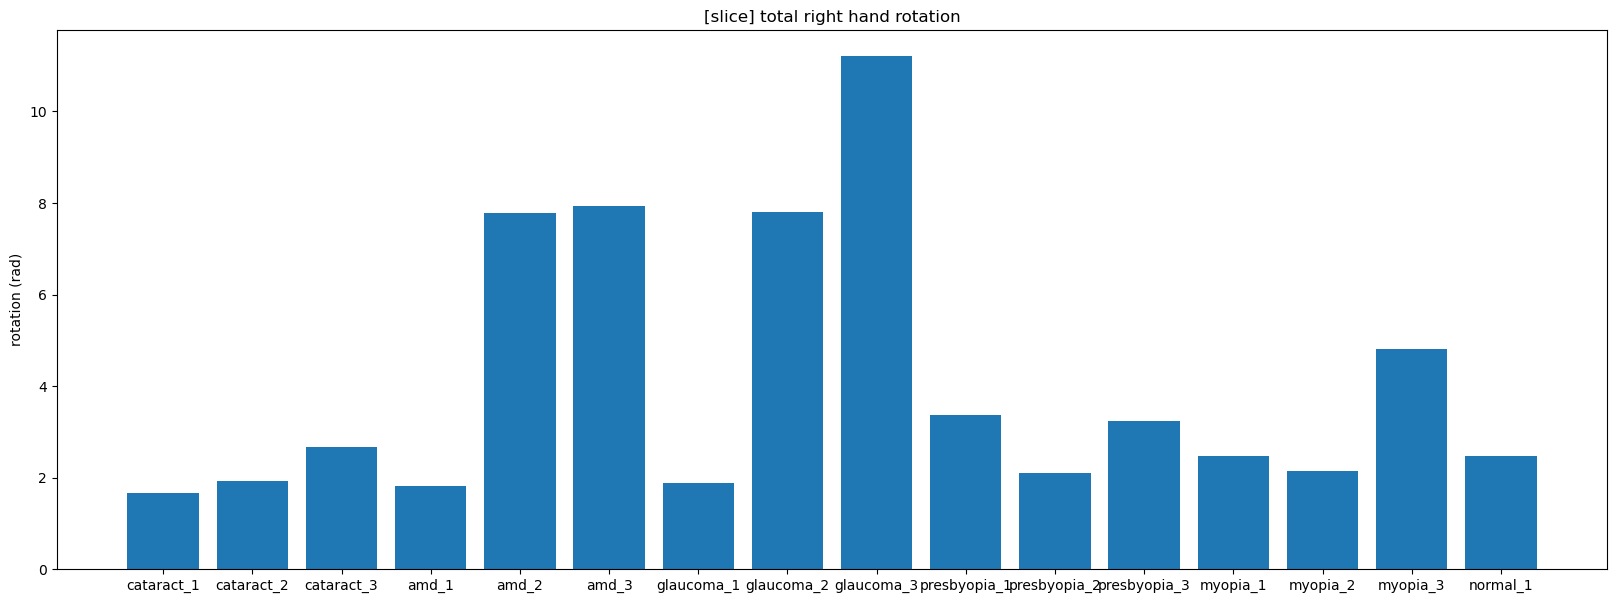

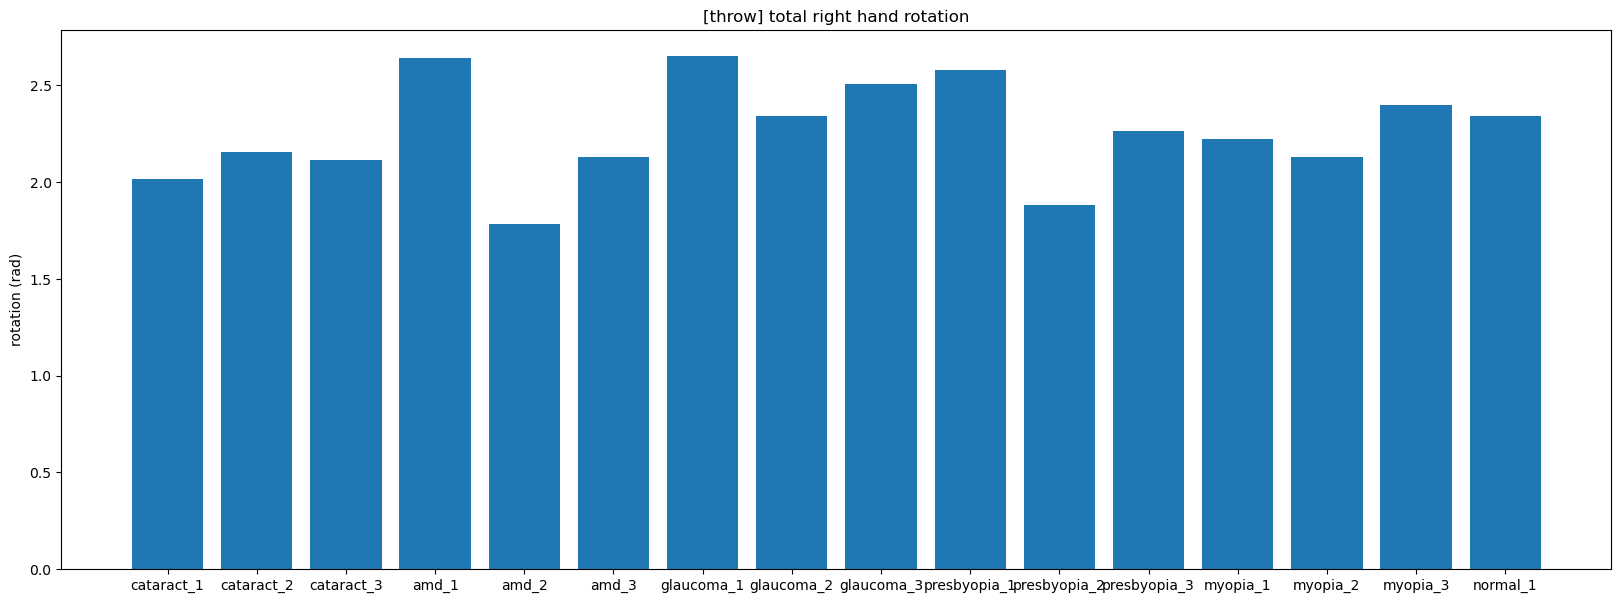

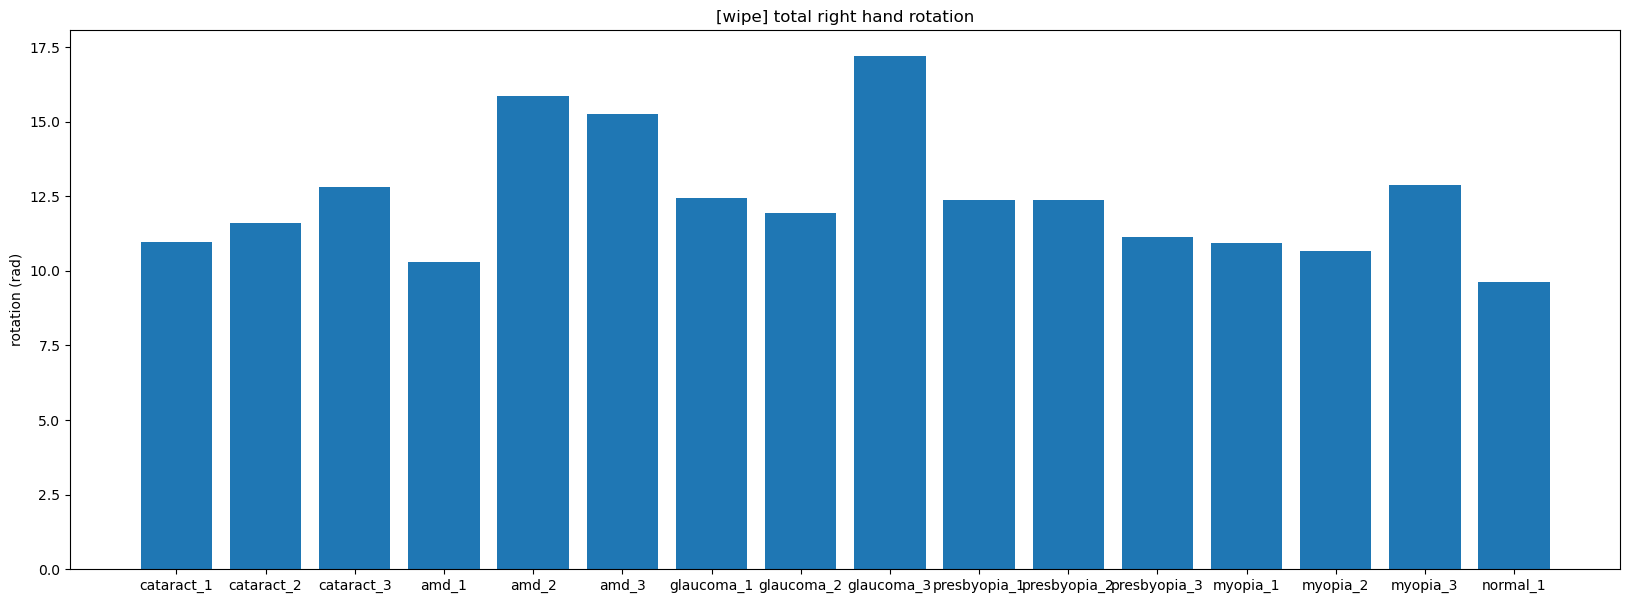

In [24]:
avg_rh_rotation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_rh_rotation_data[task][vi] = []
        for id in ids:
            avg_rh_rotation_data[task][vi].append(np.mean(list(rh_rotation_data[f"{task}_{vi}"][id].values())))
        avg_rh_rotation_data[task][vi] = np.mean(avg_rh_rotation_data[task][vi])
    vi_data.bar_plot(data=list(avg_rh_rotation_data[task].values()), tick_label=vis, title=f"[{task}] total right hand rotation", ylabel="rotation (rad)")

## Others

### Failure Rate (FR) for catch and throw

In [25]:
fr = vi_data.get_attr(key="/metadata/success", cond_id=[f"{task}_{vi}" for task, vi in product(["catch", "throw"], vis)])

# catch
fr_catch = {vi: {} for vi in vis}
for vi in vis:
    for id in ids:
        fr_catch[vi][id] = np.round(1 - np.mean(list(fr[f"catch_{vi}"][id].values())), decimals=2)

# throw
fr_throw = {vi: {} for vi in vis}
for vi in vis:
    for id in ids:
        fr_throw[vi][id] = np.round(1 - np.mean(list(fr[f"throw_{vi}"][id].values())), decimals=2)

if save_json:
    with open(f"{data_path}/json/dv1/catch_failure_rate.json", "w") as f:
        json.dump(fr_catch, f)
    with open(f"{data_path}/json/dv1/throw_failure_rate.json", "w") as f:
        json.dump(fr_throw, f)
    with open(f"{data_path}/json/dv1/raw_failure_rate.json", "w") as f:
        json.dump(fr, f)


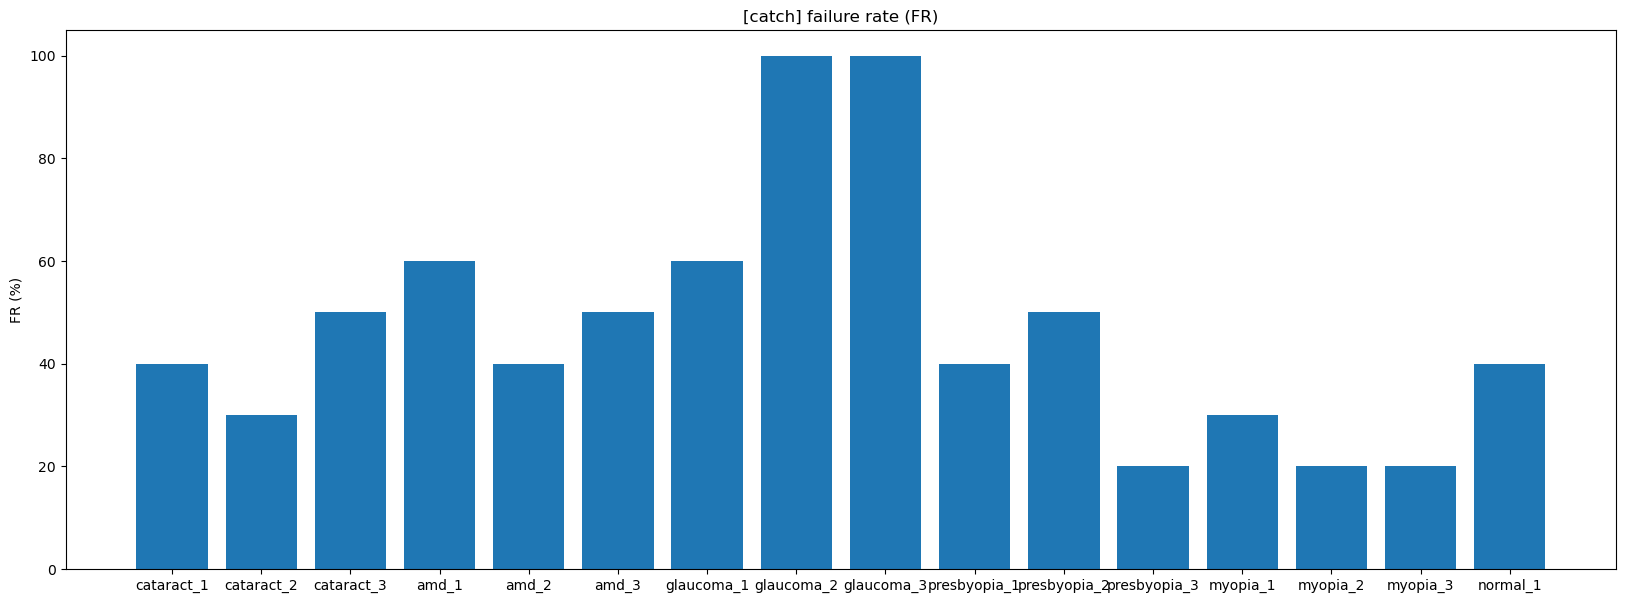

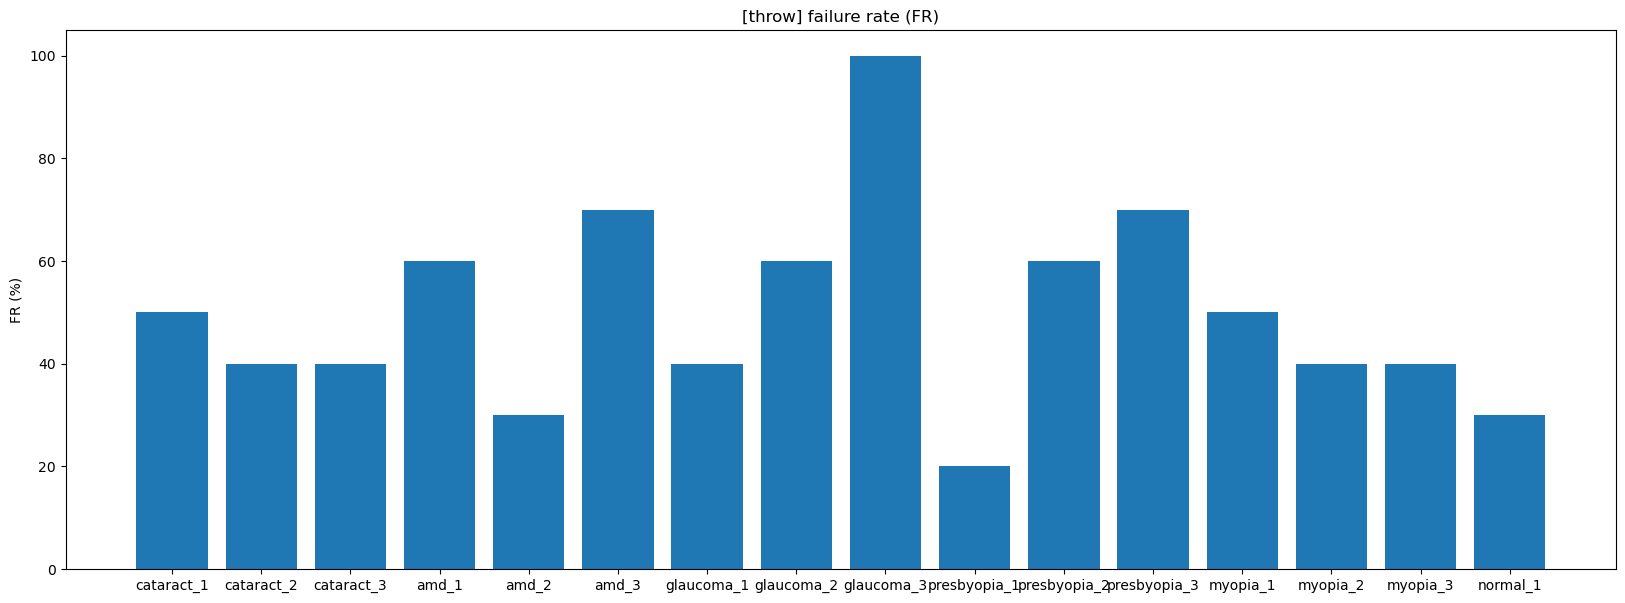

In [26]:
vi_data.bar_plot(data=np.array([np.mean(list(fr_catch[cond].values())) for cond in fr_catch.keys()])*100, tick_label=vis, title="[catch] failure rate (FR)", ylabel="FR (%)")
vi_data.bar_plot(data=np.array([np.mean(list(fr_throw[cond].values())) for cond in fr_throw.keys()])*100, tick_label=vis, title="[throw] failure rate (FR)", ylabel="FR (%)")

### Distance between ball and target

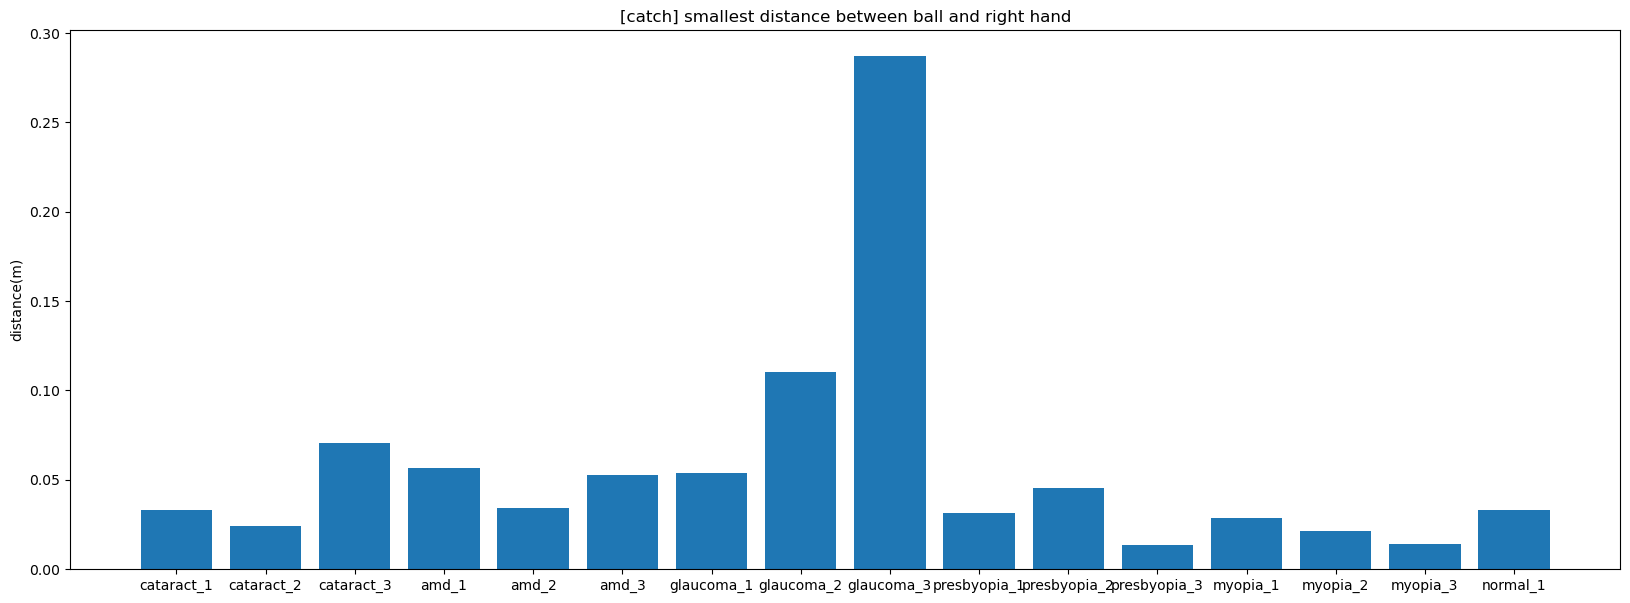

In [27]:
# Catch
distance_precision_catch = vi_data.get_catch_distance_precision()

if save_json:
    with open(f"{data_path}/json/dv1/catch_distance_from_ball_to_target.json", "w") as f:
        json.dump(distance_precision_catch, f)

avg_distance_catch = {}
for vi in vis:
    avg_distance_catch[vi] = []
    for id in ids:
        avg_distance_catch[vi].append(np.mean(list(distance_precision_catch[f"catch_{vi}"][id].values())))
    avg_distance_catch[vi] = np.mean(avg_distance_catch[vi])
vi_data.bar_plot(data=avg_distance_catch.values(), tick_label=vis, title=f"[catch] smallest distance between ball and right hand", ylabel="distance(m)")

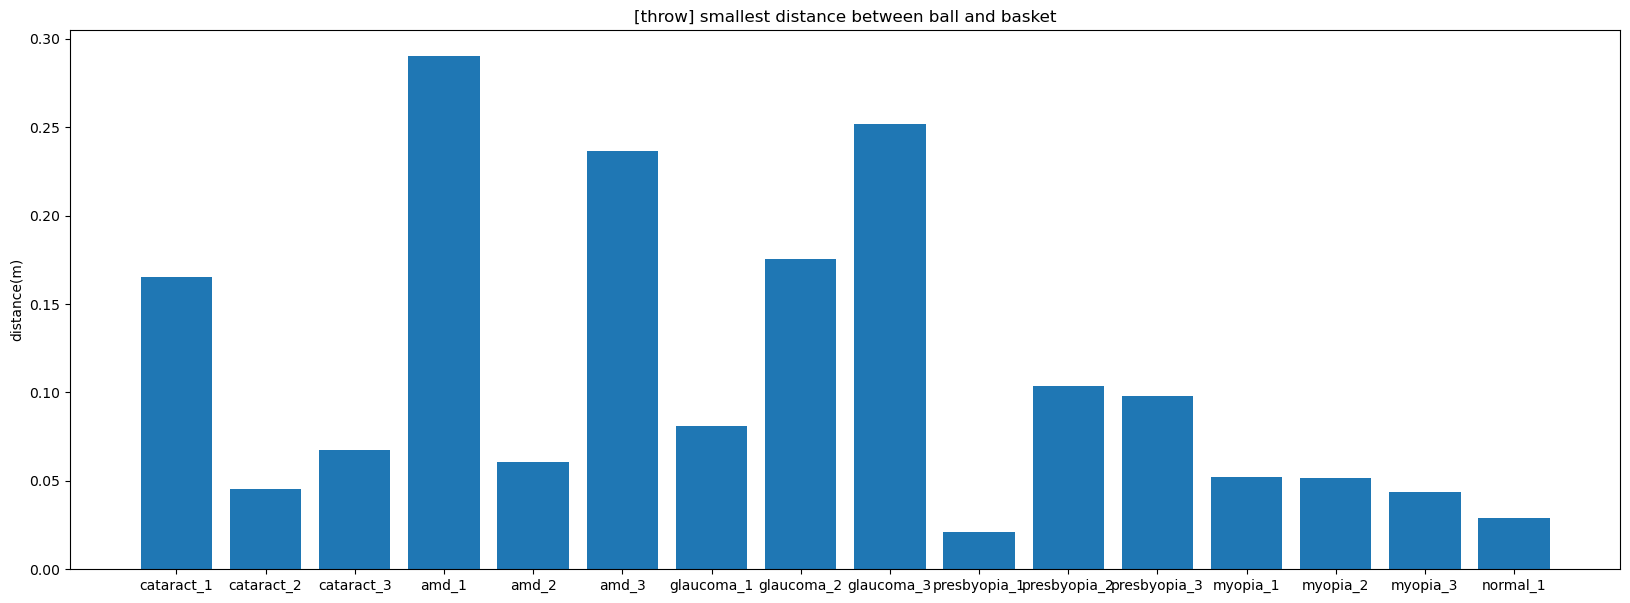

In [28]:
# Throw
distance_precision_throw = vi_data.get_throw_distance_precision()

if save_json:
    with open(f"{data_path}/json/dv1/throw_distance_from_ball_to_target.json", "w") as f:
        json.dump(distance_precision_throw, f)

avg_distance_throw = {}
for vi in vis:
    avg_distance_throw[vi] = []
    for id in ids:
        avg_distance_throw[vi].append(np.mean(list(distance_precision_throw[f"throw_{vi}"][id].values())))
    avg_distance_throw[vi] = np.mean(avg_distance_throw[vi])
vi_data.bar_plot(data=avg_distance_throw.values(), tick_label=vis, title=f"[throw] smallest distance between ball and basket", ylabel="distance(m)")

### Total movement of all objects of place

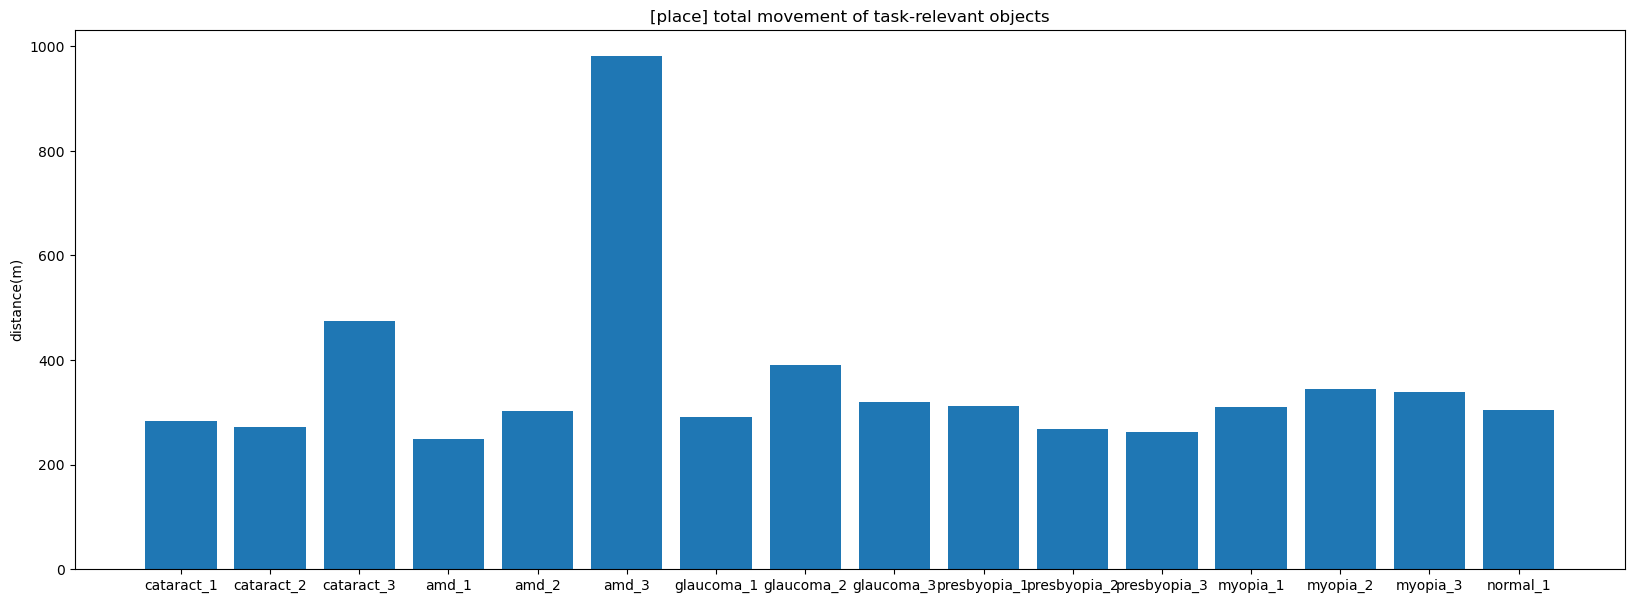

In [29]:
# from analysis, the object id of baskets and cubes are 13-20
total_obj_movements = vi_data.get_object_translation(object_id=range(13, 21), cond_id=[f"place_{vi}" for vi in vis], method=np.sum)
avg_obj_movement = {}
for vi in vis:
    avg_obj_movement[vi] = []
    for id in ids:
        avg_obj_movement[vi].append(np.mean(list(total_obj_movements[f"place_{vi}"][id].values())))  
    avg_obj_movement[vi] = np.mean(avg_obj_movement[vi]) 
vi_data.bar_plot(data=np.array(list(avg_obj_movement.values()))*100, tick_label=vis, title=f"[place] total movement of task-relevant objects", ylabel="distance(m)")

### collisions for navigate and wipe

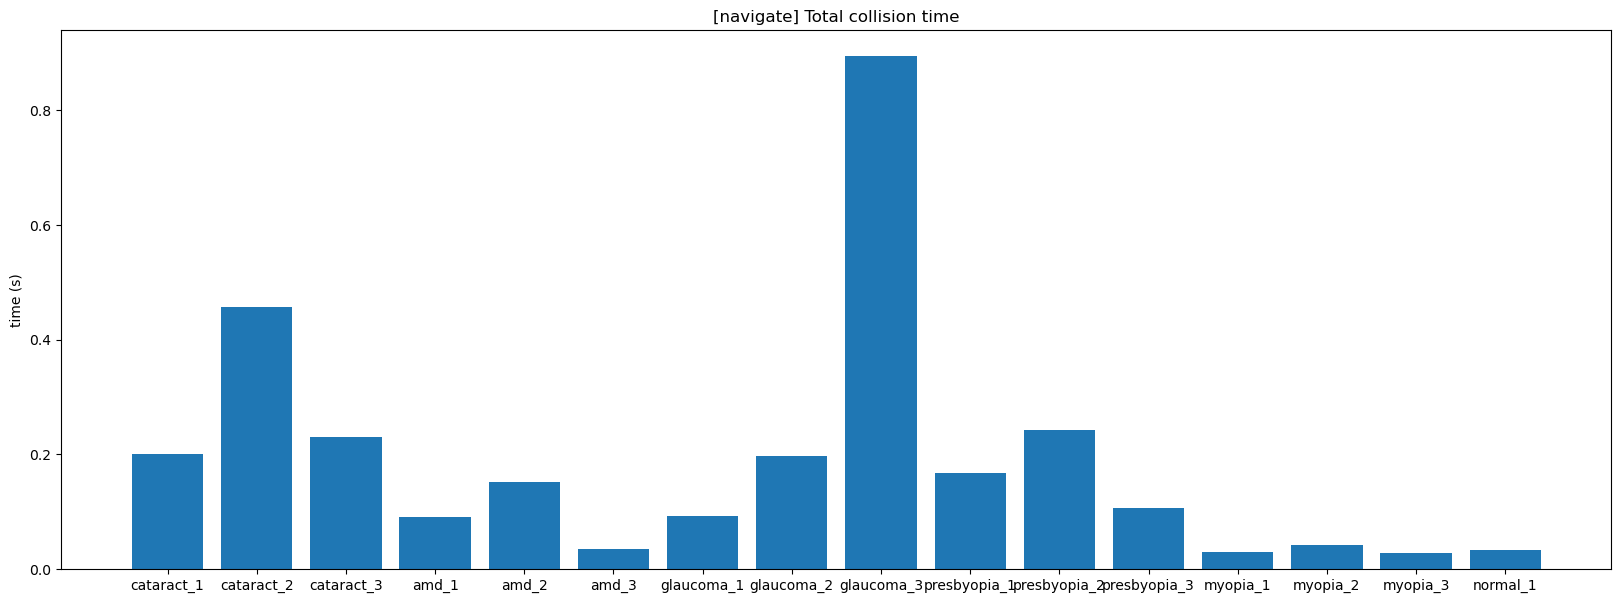

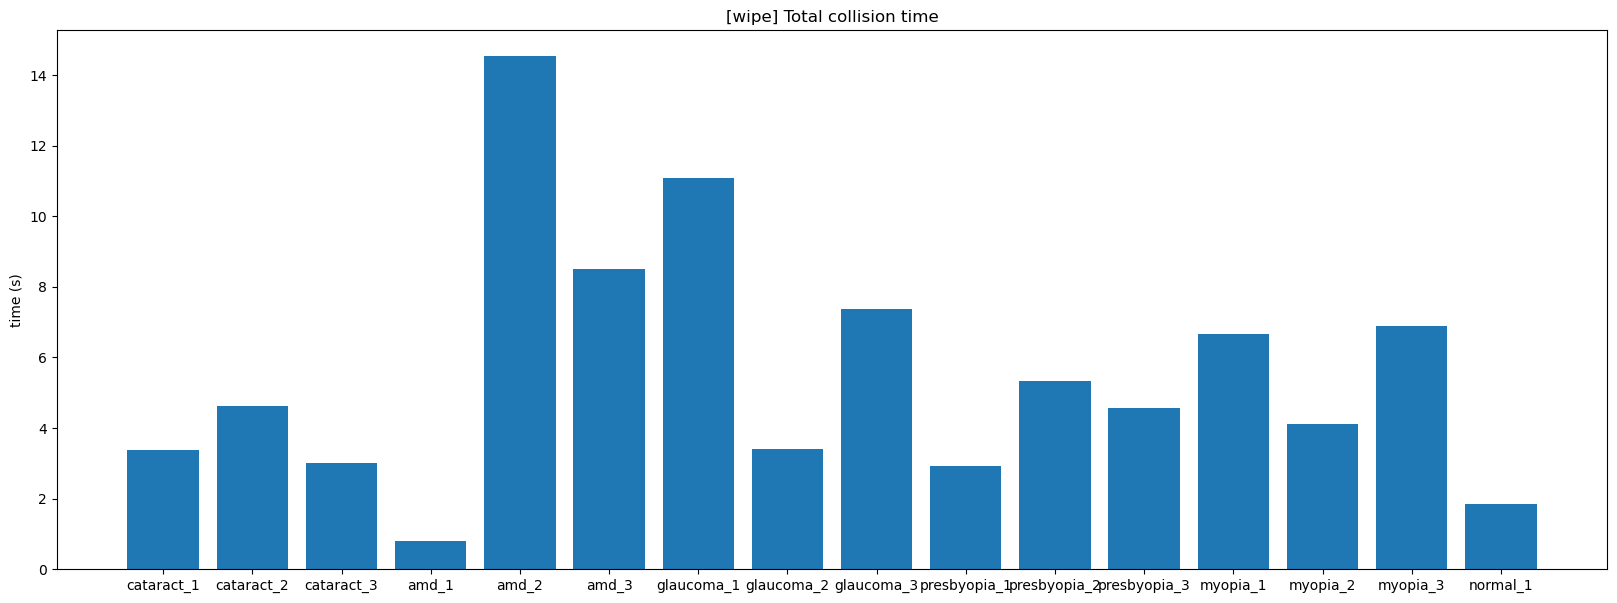

In [30]:
collision_time = vi_data.get_data(key="/vr/vr_event_data/collisions", cond_id=[f"navigate_{vi}" for vi in vis] + [f"wipe_{vi}" for vi in vis], method=lambda x: np.sum(np.any(x, axis=1)))
for cond in collision_time:
    for id in collision_time[cond]:
        for trial in collision_time[cond][id]:
            collision_time[cond][id][trial]  /= vi_data.fps[cond][id][trial]
            
if save_json:
    with open(f"{data_path}/json/dv1/total_collision_time.json", "w") as f:
        json.dump(collision_time, f)

avg_collision_time = {}
for task in ["navigate", "wipe"]:
    for vi in vis:
        avg_collision_time[vi] = []
        for id in ids:
            avg_collision_time[vi].append(np.mean(list(collision_time[f"{task}_{vi}"][id].values())))
        avg_collision_time[vi] = np.mean(avg_collision_time[vi])
    vi_data.bar_plot(data=list(avg_collision_time.values()), tick_label=vis, title=f"[{task}] Total collision time", ylabel="time (s)")

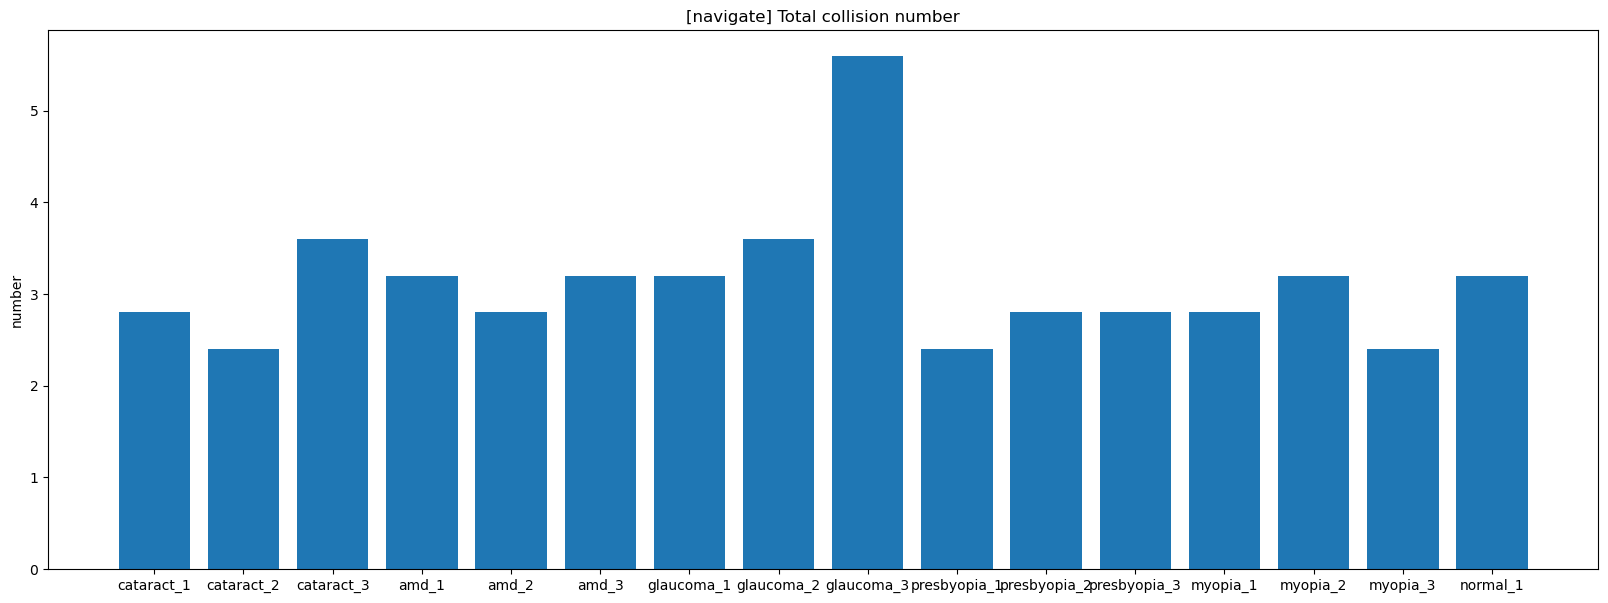

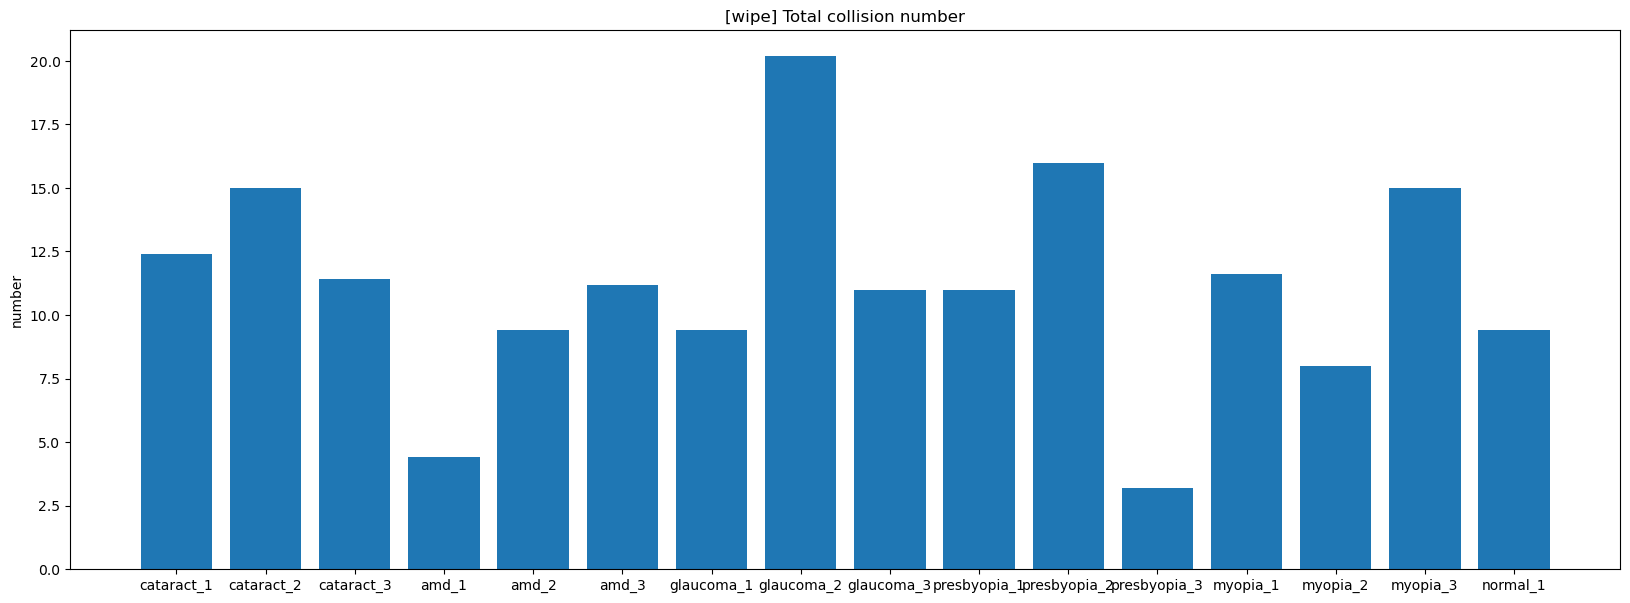

In [31]:
collision_num = vi_data.get_data(key="/vr/vr_event_data/collisions", cond_id=[f"navigate_{vi}" for vi in vis] + [f"wipe_{vi}" for vi in vis], method=lambda x: int(np.cumsum(np.insert(np.diff(np.any(x, axis=1)), 0, 0))[-1]))
            
if save_json:
    with open(f"{data_path}/json/dv1/num_collisions.json", "w") as f:
        json.dump(collision_num, f)

avg_collision_num = {}
for task in ["navigate", "wipe"]:
    for vi in vis:
        avg_collision_num[vi] = []
        for id in ids:
            avg_collision_num[vi].append(np.mean(list(collision_num[f"{task}_{vi}"][id].values())))
        avg_collision_num[vi] = np.mean(avg_collision_num[vi])
    vi_data.bar_plot(data=list(avg_collision_num.values()), tick_label=vis, title=f"[{task}] Total collision number", ylabel="number")

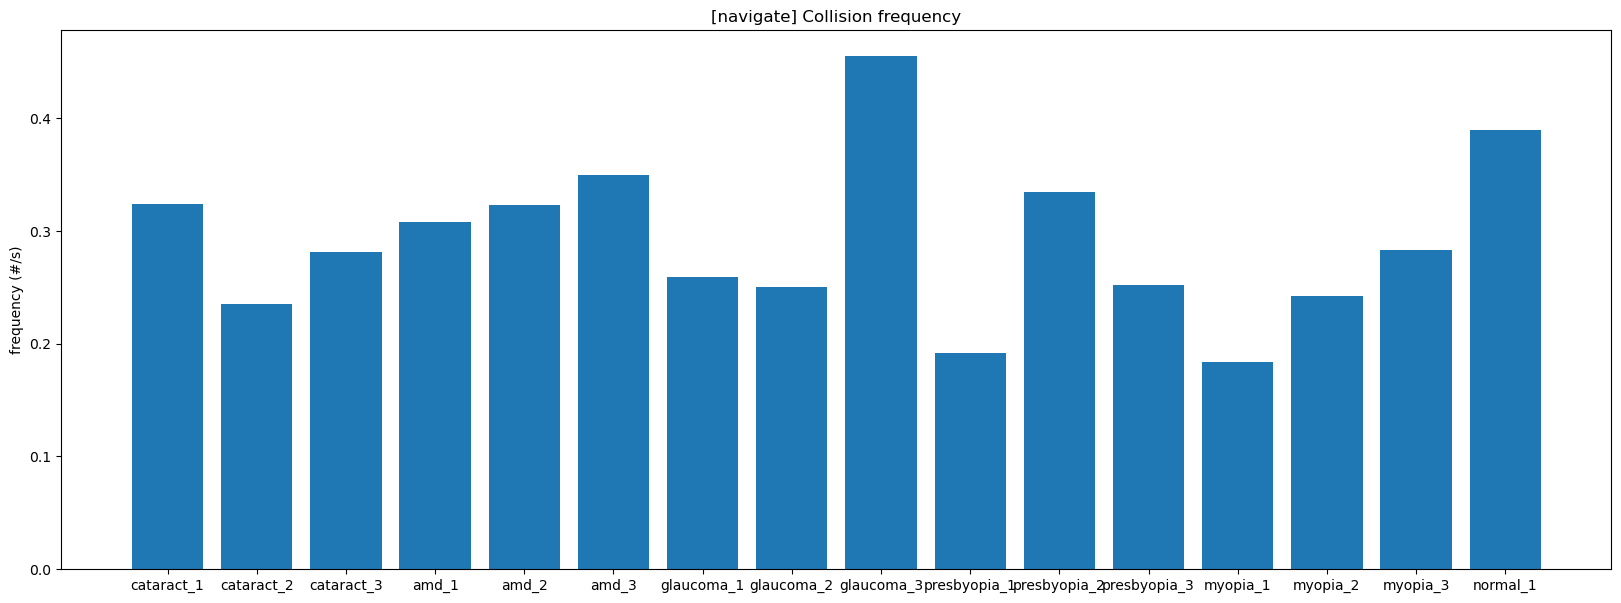

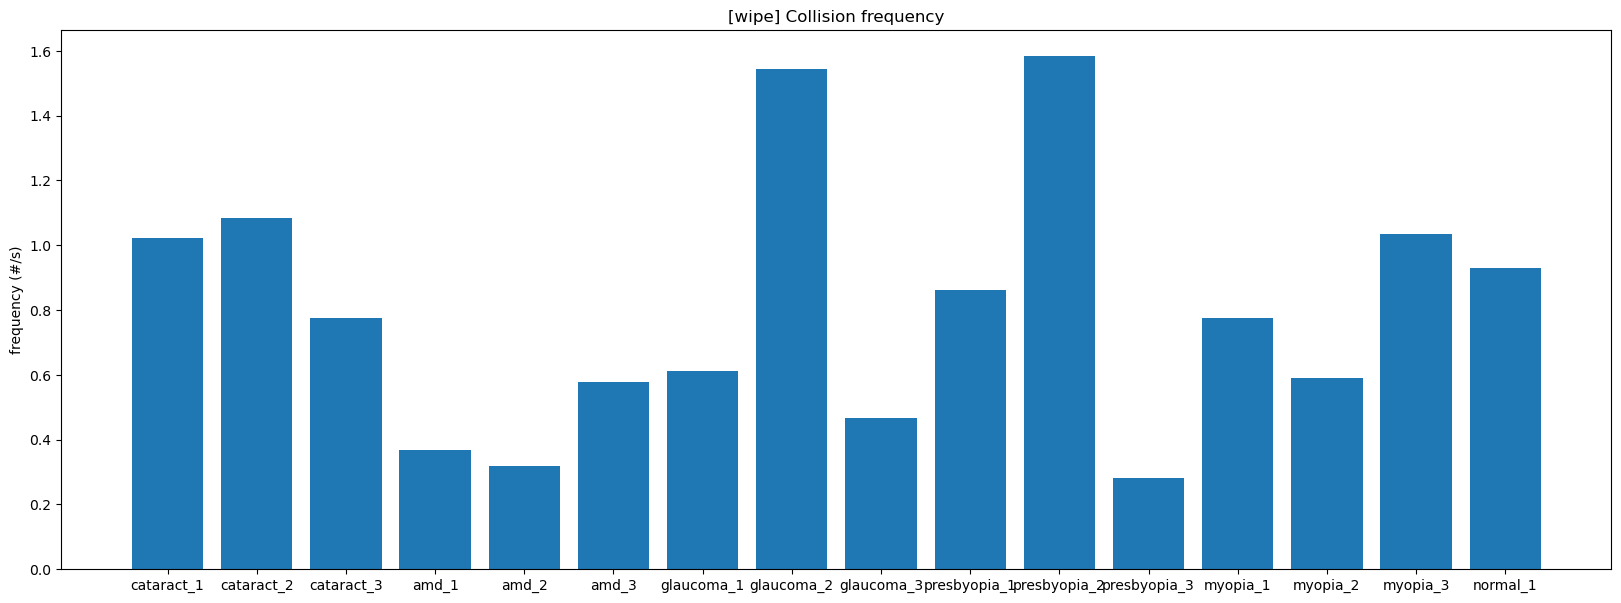

In [32]:
completion_time = vi_data.get_attr('/metadata/task_completion_time')   
collision_freq = {}
for task in ["navigate", "wipe"]:
    for vi in vis:
        collision_freq[f"{task}_{vi}"] = {}
        for id in ids:
            collision_freq[f"{task}_{vi}"][id] = {}
            for trial in collision_num[f"{task}_{vi}"][id]:
                collision_freq[f"{task}_{vi}"][id][trial] = collision_num[f"{task}_{vi}"][id][trial] / completion_time[f"{task}_{vi}"][id][trial]
if save_json:
    with open(f"{data_path}/json/dv1/collision_freq.json", "w") as f:
        json.dump(collision_num, f)

avg_collision_freq = {}
for task in ["navigate", "wipe"]:
    for vi in vis:
        avg_collision_freq[vi] = []
        for id in ids:
            avg_collision_freq[vi].append(np.mean(list(collision_freq[f"{task}_{vi}"][id].values())))
        avg_collision_freq[vi] = np.mean(avg_collision_freq[vi])
    vi_data.bar_plot(data=list(avg_collision_freq.values()), tick_label=vis, title=f"[{task}] Collision frequency", ylabel="frequency (#/s)")

### irrelavant objects movement and brushing time for wipe

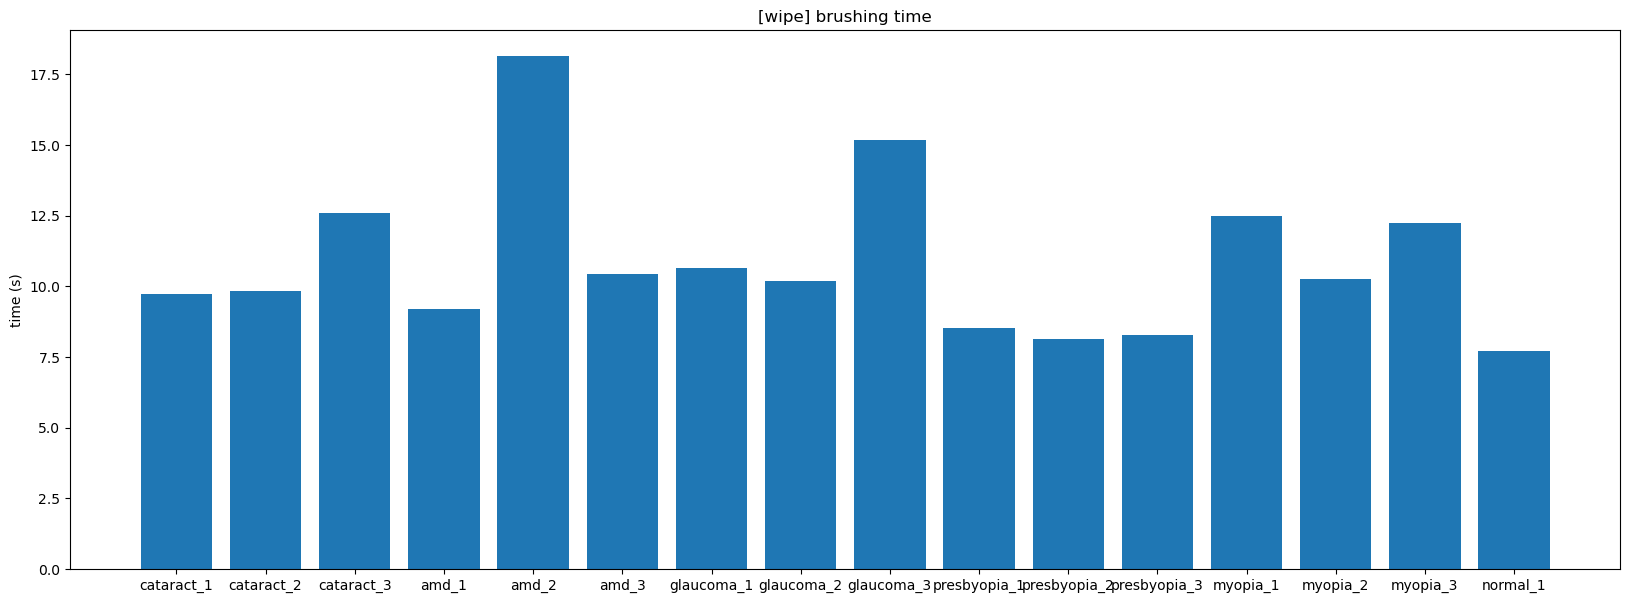

In [33]:
brushing_time = vi_data.get_attr(key="/task_specific/total_brushing_time", cond_id=[f"wipe_{vi}" for vi in vis])
avg_brushing_time = {}
for vi in vis:
    avg_brushing_time[vi] = []
    for id in ids:
        avg_brushing_time[vi].append(np.mean(list(brushing_time[f"wipe_{vi}"][id].values())))
    avg_brushing_time[vi] = np.mean(avg_brushing_time[vi])
vi_data.bar_plot(data=list(avg_brushing_time.values()), tick_label=vis, title="[wipe] brushing time", ylabel="time (s)")

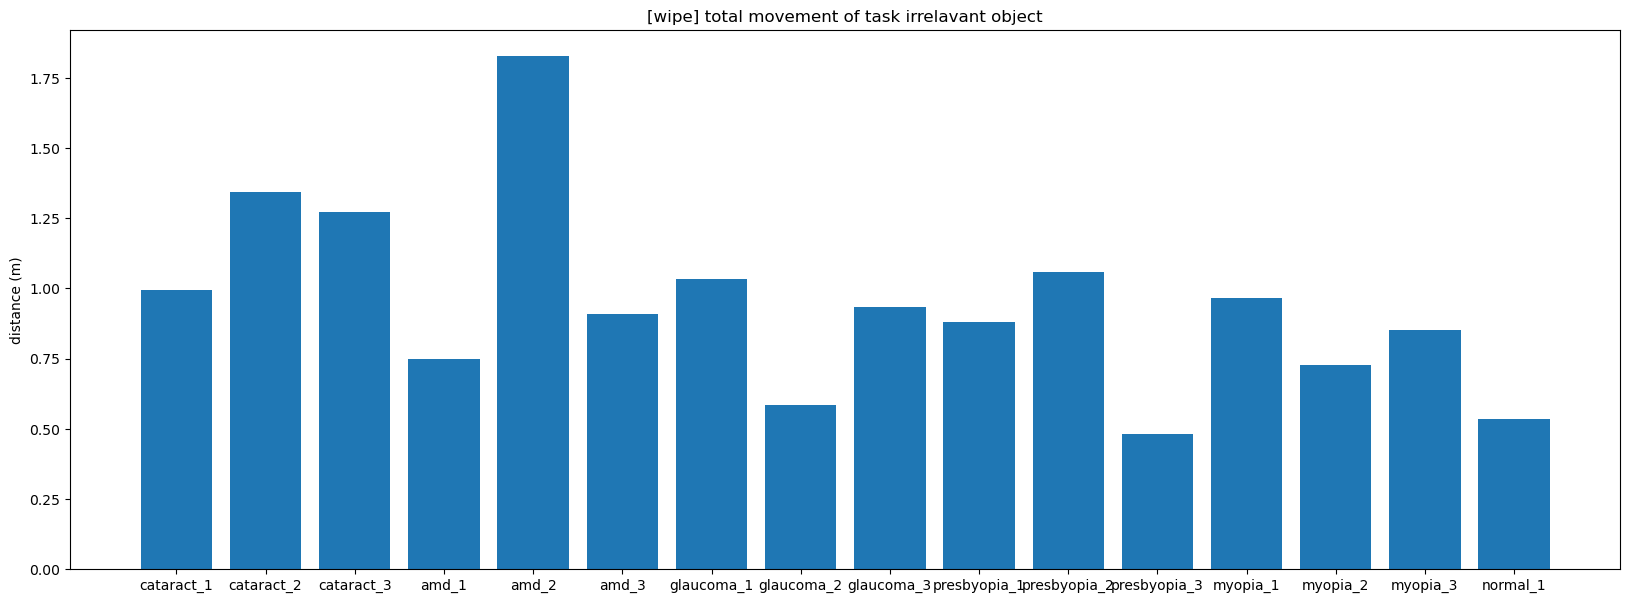

In [34]:
irre_movement = vi_data.get_data(key="/total_movement_of_irrelavant_objs", cond_id=[f"wipe_{vi}" for vi in vis], method=lambda x:x[-1][0])
if save_json:
    with open(f"{data_path}/json/dv1/wipe_total_irrevalant_objects_disarrangement.json", "w") as f:
        json.dump(irre_movement, f)
avg_irre_movement = {}
for vi in vis:
    avg_irre_movement[vi] = []
    for id in ids:
        avg_irre_movement[vi].append(np.mean(list(irre_movement[f"wipe_{vi}"][id].values())))
    avg_irre_movement[vi] = np.mean(avg_irre_movement[vi])
vi_data.bar_plot(data=list(avg_irre_movement.values()), tick_label=vis, title="[wipe] total movement of task irrelavant object", ylabel="distance (m)")

## Real World Experiment

In [35]:
place_real_world_data = {
    "place_amd_1": {
        1: {
            0: 21, 
            1: 12, 
            2: 14
        },
        2: {
            0: 19, 
            1: 14, 
            2: 22
        },
        3: {
            0: 10, 
            1: 9, 
            2: 15
        },
        4: {
            0: 25, 
            1: 33, 
            2: 14,
        },
        5: {
            0: 19, 
            1: 23, 
            2: 30
        },
        6: {
            0: 22, 
            1: 21, 
            2: 12,
        },
        7: {
            0: 28, 
            1: 15, 
            2: 45
        },
        8: {
            0: 26, 
            1: 14, 
            2: 19,
        },
        9: {
            0: 18, 
            1: 11, 
            2: 12
        },
        10: {
            0: 13, 
            1: 25, 
            2: 26
        },
    },
    "place_amd_2": {
        1: {
            0: 37, 
            1: 18, 
            2: 24
        },
        2: {
            0: 18, 
            1: 16, 
            2: 27
        },
        3: {
            0: 16, 
            1: 12, 
            2: 16
        },
        4: {
            0: 39, 
            1: 16, 
            2: 32,
        },
        6: {
            0: 17, 
            1: 17, 
            2: 17,
        },
        5: {
            0: 79, 
            1: 43, 
            2: 90
        },
        7: {
            0: 25, 
            1: 35, 
            2: 42
        },
        8: {
            0: 31, 
            1: 19, 
            2: 21,
        },
        9: {
            0: 17, 
            1: 14, 
            2: 13
        },
        10: {
            0: 25, 
            1: 24, 
            2: 44
        },
    },
    "place_amd_3": {
        1: {
            0: 90, 
            1: 90, 
            2: 90
        },
        2: {
            0: 62, 
            1: 73, 
            2: 49
        },
        3: {
            0: 58, 
            1: 33, 
            2: 32
        },
        4: {
            0: 90, 
            1: 90, 
            2: 30,
        },
        6: {
            0: 47, 
            1: 53, 
            2: 39,
        },
        5: {
            0: 90, 
            1: 90, 
            2: 90
        },
        7: {
            0: 90, 
            1: 90, 
            2: 90
        },
        8: {
            0: 85, 
            1: 54, 
            2: 90,
        },
        9: {
            0: 62, 
            1: 88, 
            2: 67
        },
        10: {
            0: 90, 
            1: 90, 
            2: 90
        },
    },
    "place_glaucoma_1": {
        1: {
            0: 13, 
            1: 24, 
            2: 50
        },
        2: {
            0: 12, 
            1: 18, 
            2: 13
        },
        3: {
            0: 17, 
            1: 15, 
            2: 12
        },
        4: {
            0: 19, 
            1: 22, 
            2: 15,
        },
        5: {
            0: 23, 
            1: 35, 
            2: 36
        },
        6: {
            0: 23, 
            1: 13, 
            2: 16,
        },
        7: {
            0: 25, 
            1: 33, 
            2: 22
        },
        8: {
            0: 28, 
            1: 13, 
            2: 12,
        },
        9: {
            0: 12, 
            1: 17, 
            2: 13
        },
        10: {
            0: 20, 
            1: 16, 
            2: 14
        },
    },
    "place_glaucoma_2": {
        1: {
            0: 74, 
            1: 55, 
            2: 40
        },
        2: {
            0: 18, 
            1: 18, 
            2: 20
        },
        3: {
            0: 14, 
            1: 11, 
            2: 11
        },
        4: {
            0: 17, 
            1: 11, 
            2: 22,
        },
        6: {
            0: 19, 
            1: 25, 
            2: 15,
        },
        5: {
            0: 37, 
            1: 47, 
            2: 43
        },
        7: {
            0: 27, 
            1: 25, 
            2: 33
        },
        8: {
            0: 20, 
            1: 16, 
            2: 19,
        },
        9: {
            0: 18, 
            1: 18, 
            2: 19
        },
        10: {
            0: 30, 
            1: 29, 
            2: 27
        },
    },
    "place_glaucoma_3": {
        1: {
            0: 52, 
            1: 90, 
            2: 90
        },
        2: {
            0: 35, 
            1: 41, 
            2: 29
        },
        3: {
            0: 35, 
            1: 25, 
            2: 22
        },
        4: {
            0: 90, 
            1: 60, 
            2: 63,
        },
        5: {
            0: 58, 
            1: 68, 
            2: 62
        },
        6: {
            0: 31, 
            1: 31, 
            2: 54,
        },
        7: {
            0: 89, 
            1: 90, 
            2: 90
        },
        8: {
            0: 65, 
            1: 30, 
            2: 80,
        },
        9: {
            0: 73, 
            1: 36, 
            2: 25
        },
        10: {
            0: 51, 
            1: 68, 
            2: 40
        },
    },
    "place_normal_1": {
        1: {
            0: 24, 
            1: 25, 
            2: 22
        },
        2: {
            0: 11, 
            1: 11, 
            2: 22
        },
        3: {
            0: 16, 
            1: 9, 
            2: 11,
        },
        4: {
            0: 13, 
            1: 18, 
            2: 13,
        },
        5: {
            0: 31, 
            1: 16, 
            2: 40,
        },
        6: {
            0: 15, 
            1: 14, 
            2: 15,
        },
        7: {
            0: 19, 
            1: 14, 
            2: 10,
        },
        8: {
            0: 18, 
            1: 14, 
            2: 22,
        },
        9: {
            0: 14, 
            1: 13, 
            2: 15
        },
        10: {
            0: 23, 
            1: 19, 
            2: 15
        },
    }
}

In [36]:
if save_json:
    with open(f"{data_path}/json/place_real_world_data.json", "w") as f:
        json.dump(place_real_world_data, f)

In [37]:
total_time = 0
for i in place_real_world_data:
    for j in place_real_world_data[i]:
        for k in place_real_world_data[i][j]:
            total_time += place_real_world_data[i][j][k]
print(total_time / 60)

119.78333333333333


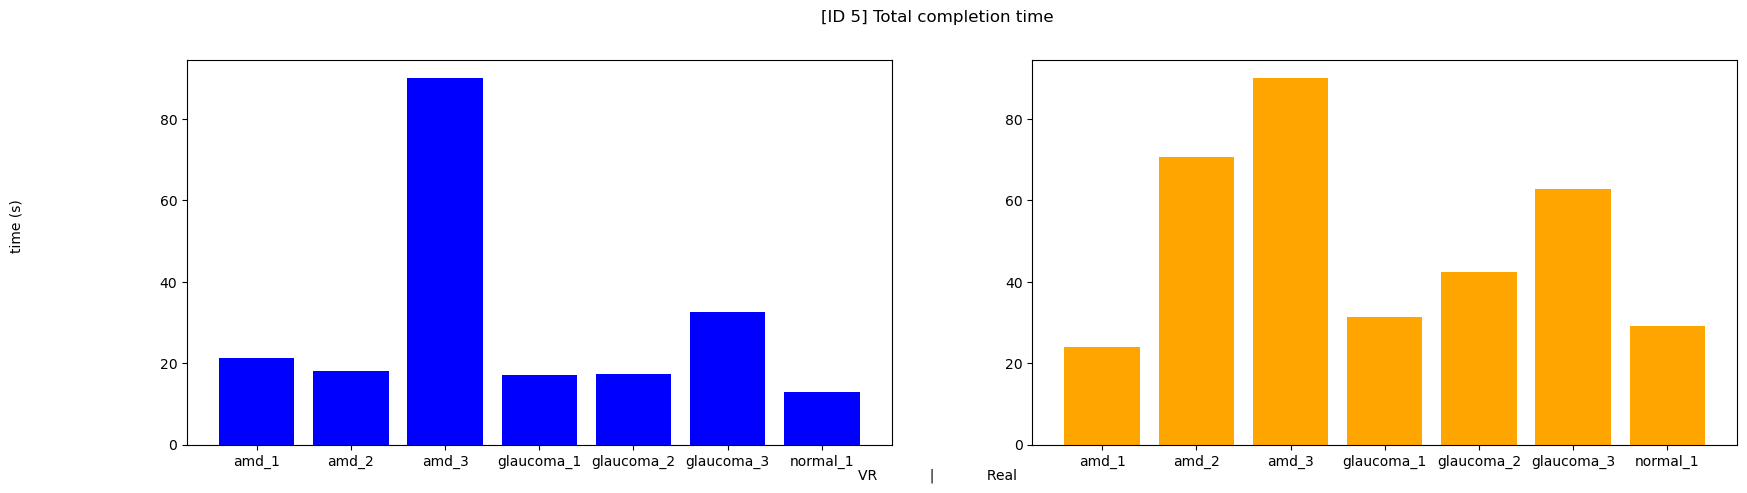

In [38]:
real_vis = ["amd_1", "amd_2", "amd_3", "glaucoma_1", "glaucoma_2", "glaucoma_3", "normal_1"]
with open(f"{data_path}/json/place_vr_data.json", "r") as f:
    place_vr_data = json.load(f)
avg_place_data_vr, avg_place_data_real = {vi: {} for vi in real_vis}, {vi: {} for vi in real_vis}

for id in ids:
    for vi in real_vis:
        avg_place_data_vr[vi][id] = np.mean(list(place_vr_data[f"place_{vi}"][f"{id}"].values()))
        avg_place_data_real[vi][id] = np.mean(list(place_real_world_data[f"place_{vi}"][id].values()))
    # for vi in real_vis:
    #     avg_place_data_vr[vi][id] = avg_place_data_vr[vi][id] / avg_place_data_vr["normal_1"][id]
    #     avg_place_data_real[vi][id] = avg_place_data_real[vi][id] / avg_place_data_real["normal_1"][id]
    vi_data.plot_comparison_bar(
        data_vr=[avg_place_data_vr[vi][id] for vi in real_vis], data_real=[avg_place_data_real[vi][id] for vi in real_vis], tick_label=real_vis, title=f"[ID {id}] Total completion time", ylabel="time (s)"
    )

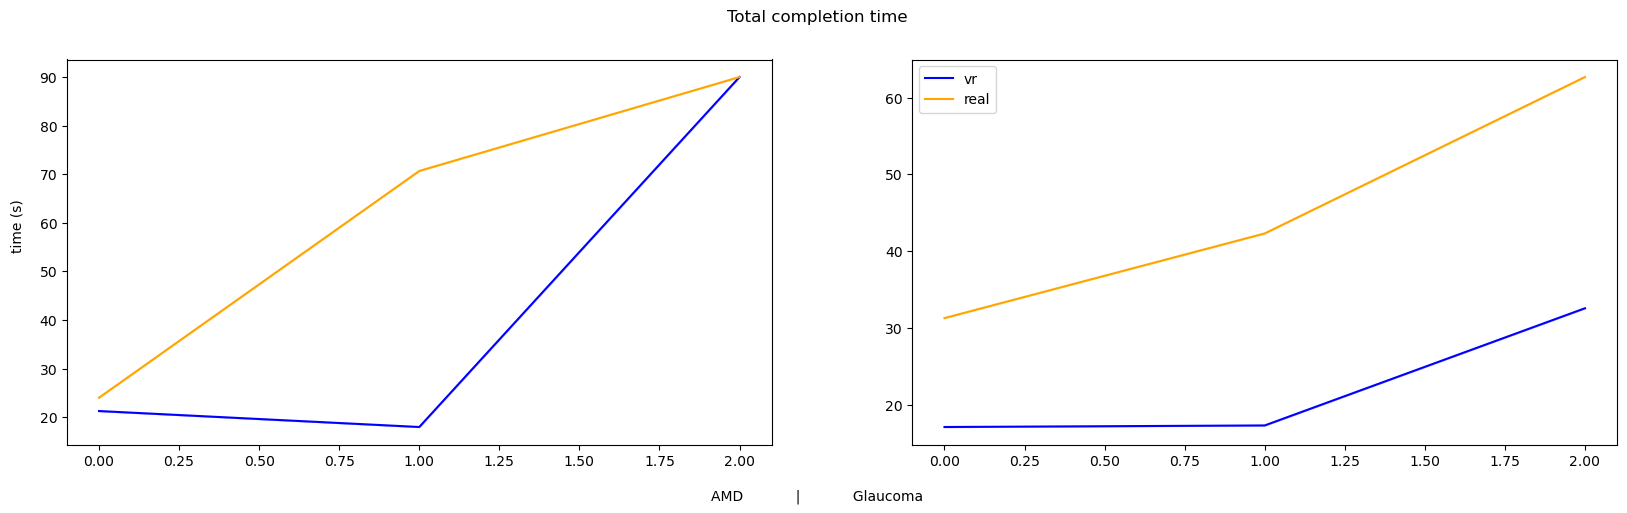

In [39]:
real_place_mean = np.array([np.mean(list(avg_place_data_real[vi].values())) for vi in real_vis])
real_place_std = np.array([np.std(list(avg_place_data_real[vi].values())) for vi in real_vis])

vr_place_mean = np.array([np.mean(list(avg_place_data_vr[vi].values())) for vi in real_vis])
vr_place_std = np.array([np.std(list(avg_place_data_vr[vi].values())) for vi in real_vis])

vi_data.plot_comparison_line(vr_place_mean, real_place_mean, vr_place_std, real_place_std, tick_label=real_vis, title="Total completion time", ylabel="time (s)")

{'amd': [0.6976494514612337], 'glaucoma': [0.9421339993739409]}


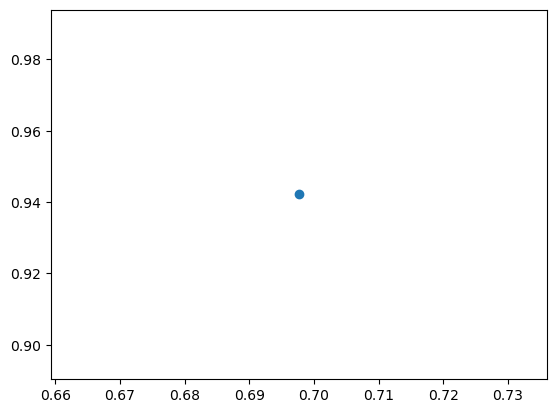

In [40]:
# Compute correlation
corr = {"amd": [], "glaucoma": []}
for id in ids:
    for i, vi in enumerate(["amd", "glaucoma"]):
        corr[vi].append(np.corrcoef([d[id] for d in list(avg_place_data_vr.values())[i*3: (i+1)*3]], [d[id] for d in list(avg_place_data_real.values())[i*3: (i+1)*3]])[0, 1])
plt.scatter(corr["amd"], corr["glaucoma"])
print(corr)

In [41]:
print(np.mean(corr["amd"]), np.mean(corr["glaucoma"]), np.std(corr["amd"]), np.std(corr["glaucoma"]))

0.6976494514612337 0.9421339993739409 0.0 0.0


## Subject Difficulty Rating

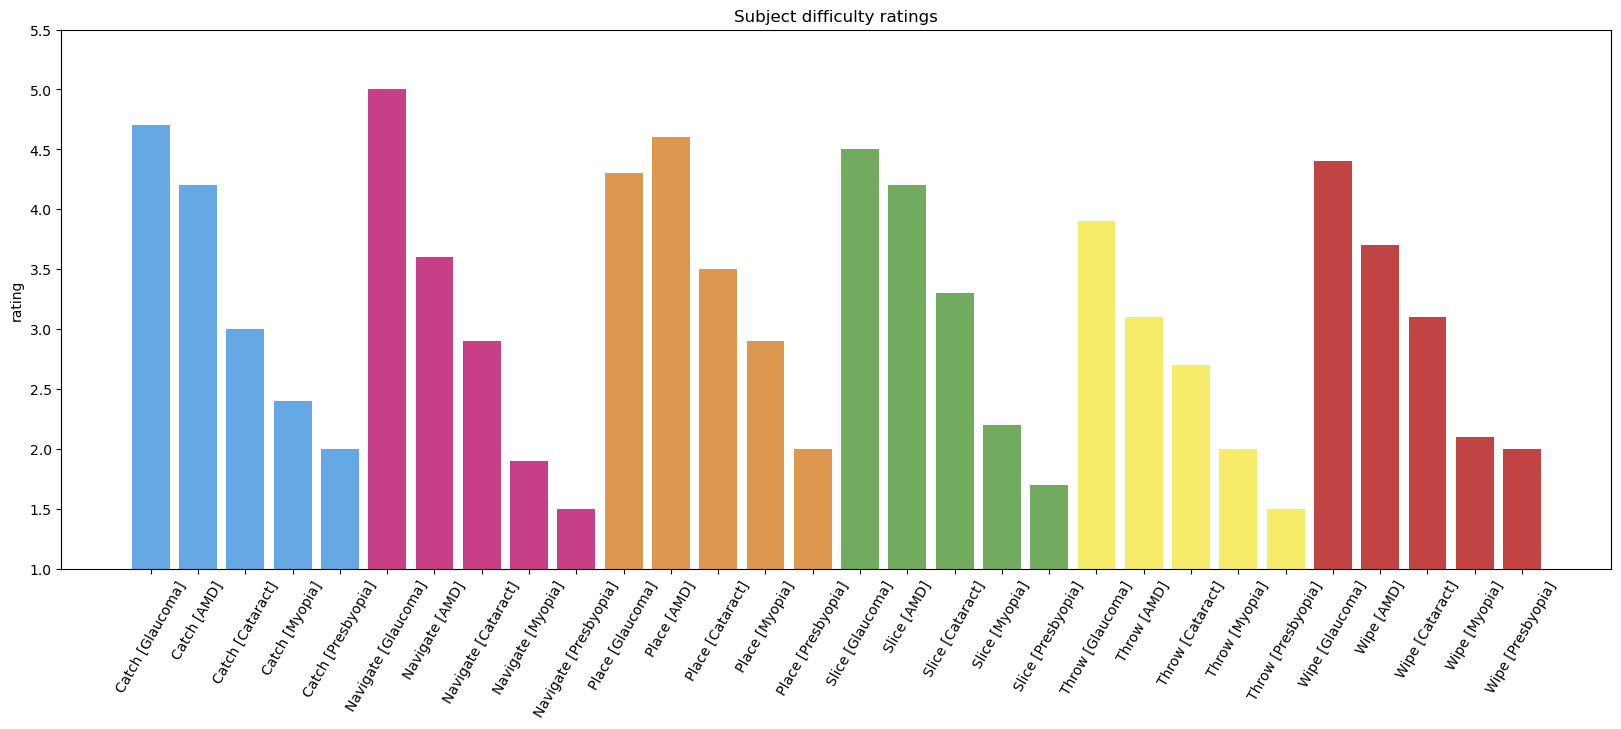

In [11]:
import csv
s_tasks = ["Catch", "Navigate", "Place", "Slice", "Throw", "Wipe"]
s_vis = [ "Glaucoma", "AMD", "Cataract", "Myopia", "Presbyopia"]
subject_ratings = {}
with open(f"{data_path}/json/subject_ratings.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        for task in s_tasks:
            for s_vi in s_vis:
                if f"{task} [{s_vi}]" not in subject_ratings:
                    subject_ratings[f"{task} [{s_vi}]"] = {}
                subject_ratings[f"{task} [{s_vi}]"][int(row["ID"])] = float(row[f"{task} [{s_vi}]"])
for key in subject_ratings:
    subject_ratings[key] = np.mean(list(subject_ratings[key].values()))
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(7)
c = ['#66a8e4'] * 5 + ['#c73f87'] * 5 + ['#dd974f'] * 5 + ['#72aa5f'] * 5 + ['#f7eb6a'] * 5 + ['#c14344'] * 5
plt.bar(subject_ratings.keys(), subject_ratings.values(), color=c)
plt.title("Subject difficulty ratings")
plt.ylabel("rating")
plt.xticks(rotation=60)
plt.ylim(1, 5.5)
plt.show()

In [43]:
with open(f"{data_path}/json/subject_ratings.json", "w") as f:
    json.dump(subject_ratings, f)

## Finally close hdf files

In [44]:
del vi_data